In [1]:
# %% Load the required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import networkx as nx
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sage import SAGEConv
import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Using backend: pytorch


In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

In [3]:
# %% data loading and pre-processing

df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
features = pd.Series(X.satisfaction) 
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

TEST = pd.read_csv('TEST_DF')
test_features = pd.Series(TEST.satisfaction)
test_vars = TEST.drop(columns=['Unnamed: 0','satisfaction'])
test_vars.Class = test_vars.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
test_wd = pd.get_dummies(data=test_vars,columns=['Customer Type','Type of Travel','Gender'])
test_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(test_wd[['Age','Departure Delay in Minutes','Flight Distance']])

In [4]:
# %%  load graph data

A = np.loadtxt('adjacency_matrix.csv', delimiter=',')
G = nx.from_numpy_matrix(A)
A_test = np.loadtxt('adjacency_matrix_test_graph.csv', delimiter=',')
G_test = nx.from_numpy_matrix(A_test)

In [ ]:
# Node2Vec for Test Graph

from node2vec import Node2Vec

node2vec = Node2Vec(G_test, dimensions=2, walk_length=8, num_walks=100, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=2)
model.wv.save_word2vec_format('embeddings_test')

Computing transition probabilities:   0%|          | 0/6000 [00:00<?, ?it/s]

In [25]:
# %% Normalization function

def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

In [6]:
# %% GraphSage Class

class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, agg_type):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.LogSoftmax(dim=1)))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [7]:
# %% SumSage Class for sum-pooling

class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.LogSoftmax(dim=1)))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [8]:
# %% Simulation function

def Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'pool',sum_sage=False):

    train_acc_exp = []
    val_acc_exp = []
    exp_losses_train = []
    exp_losses_val = []
    test_acc = []
    plot_loss_test = []
    

    G_dgl_test = dgl.from_networkx(G_test)
    feat_test = TEST.drop(columns=['satisfaction'])
    feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
    feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

    G_dgl_test.ndata['feat'] =  torch.tensor(test_wd.values,dtype=torch.float)
    G_dgl_test.ndata['label'] = torch.tensor(test_features)
    
    node_features_test = G_dgl_test.ndata['feat']
    node_labels_test = G_dgl_test.ndata['label']
    test_nids = G_dgl_test.nodes()
    n_features_test = node_features_test.shape[1]
    n_labels_test = int(node_labels_test.max().item() + 1)
    
    G_dgl = dgl.from_networkx(G)
    G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
    G_dgl.ndata['label'] = torch.tensor(features)
    
    for n in range(nExp):
        print('Experiment: {}'.format(n))
        
        G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)

        G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
        for i in range(len(G_dgl.ndata['train_mask'])):
            if G_dgl.ndata['train_mask'][i] == True:
                G_dgl.ndata['val_mask'][i] = False
            else:
                G_dgl.ndata['val_mask'][i] = True

        G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

        node_features = G_dgl.ndata['feat']
        node_labels = G_dgl.ndata['label']
        train_mask = G_dgl.ndata['train_mask']
        valid_mask = G_dgl.ndata['val_mask']
        n_features = node_features.shape[1]
        n_labels = int(node_labels.max().item() + 1)

        train_nodes = (train_mask == True).nonzero(as_tuple=False)
        train_nids = torch.reshape(train_nodes,(-1,))
        valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
        valid_nids = torch.reshape(valid_nodes,(-1,))

        batch_size = 50
        sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
        train_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, train_nids, sampler,
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=0
        )

        batch_size = len(valid_nids)
        valid_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, valid_nids, sampler,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=0
        )

        if sum_sage is True:
            model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
        else:
            model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type) #n_layers
        opt = torch.optim.Adam(model.parameters(), lr=0.002)


        best_accuracy = 0
        epoch_losses_train = []
        plot_loss_valid = []
        train_acc = []
        valid_acc = []
        dur = []

        for epoch in range(400):
            t0 = time.time()
            model.train()
            loss_epoch = 0
            accuracy_epoch = 0
            for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
                inputs = node_features[input_nodes]
                labels = node_labels[output_nodes]
                predictions = model(bipartites, inputs)

                loss = F.cross_entropy(predictions, labels)
                loss_epoch += loss.detach().item()
                opt.zero_grad()
                loss.backward()
                opt.step()

                accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
                accuracy_epoch += accuracy
            accuracy_epoch /= (step + 1)
            loss_epoch /= (step + 1)
            epoch_losses_train.append(loss_epoch)
            train_acc.append(accuracy_epoch)
            print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
            model.eval()
    
            predictions = []
            labels = []
            with torch.no_grad():
                for input_nodes, output_nodes, bipartites in valid_dataloader:
                    inputs = node_features[input_nodes]
                    labels.append(node_labels[output_nodes].numpy())
                    predictions.append(model(bipartites, inputs).argmax(1).numpy())
                    valid_pred = model(bipartites, inputs)
                    valid_labels = node_labels[output_nodes]
                    valid_loss = F.cross_entropy(valid_pred, valid_labels)

                predictions = np.concatenate(predictions)
                labels = np.concatenate(labels)
        
                accuracy = accuracy_score(labels, predictions)
                dur.append(time.time() - t0)
                print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
                valid_acc.append(accuracy.item())
                plot_loss_valid.append(valid_loss.item())

        train_acc_exp.append(train_acc[-1])
        val_acc_exp.append(valid_acc[-1])
        exp_losses_train.append(epoch_losses_train[-1])
        exp_losses_val.append(plot_loss_valid[-1])
        
        batch_size = len(test_nids)
        test_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl_test, test_nids, sampler,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=0
        )
        
        test_predictions = []
        test_labels = []
        with torch.no_grad():
            for input_nodes, output_nodes, bipartites in test_dataloader:
                inputs = node_features_test[input_nodes]
                test_labels.append(node_labels_test[output_nodes].numpy())
                test_predictions.append(model(bipartites, inputs).argmax(1).numpy())
                test_pred = model(bipartites, inputs)
                test_lab = node_labels_test[output_nodes]
                test_loss = F.cross_entropy(test_pred, test_lab)

            test_predictions = np.concatenate(test_predictions)
            test_labels = np.concatenate(test_labels)
        
            test_accuracy = accuracy_score(test_labels, test_predictions)
            print('Epoch: {}, Test Accuracy: {:.3f}, Test Loss: {:.3f}'.format(epoch, test_accuracy, test_loss.item()))
            test_acc.append(test_accuracy.item())
            plot_loss_test.append(test_loss.item())
        

    return (train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_acc, plot_loss_test)


In [9]:
# %% Run Experiments mean

nExp = 100
train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_accuracy_exp, test_loss_exp = Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'pool',sum_sage=False)

Experiment: 0
Epoch: 0, Training Accuracy: 0.665, Training Loss: 0.627
Epoch: 0, Validation Accuracy: 0.788, Validation Loss: 0.548, Time: 1.3090
Epoch: 1, Training Accuracy: 0.815, Training Loss: 0.514
Epoch: 1, Validation Accuracy: 0.819, Validation Loss: 0.499, Time: 1.2313
Epoch: 2, Training Accuracy: 0.838, Training Loss: 0.486
Epoch: 2, Validation Accuracy: 0.829, Validation Loss: 0.487, Time: 1.2688
Epoch: 3, Training Accuracy: 0.846, Training Loss: 0.473
Epoch: 3, Validation Accuracy: 0.845, Validation Loss: 0.469, Time: 1.2402
Epoch: 4, Training Accuracy: 0.848, Training Loss: 0.467
Epoch: 4, Validation Accuracy: 0.854, Validation Loss: 0.462, Time: 1.2243
Epoch: 5, Training Accuracy: 0.854, Training Loss: 0.460
Epoch: 5, Validation Accuracy: 0.846, Validation Loss: 0.466, Time: 1.2162
Epoch: 6, Training Accuracy: 0.867, Training Loss: 0.450
Epoch: 6, Validation Accuracy: 0.860, Validation Loss: 0.457, Time: 1.1873
Epoch: 7, Training Accuracy: 0.863, Training Loss: 0.453
Epoch

Epoch: 62, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 62, Validation Accuracy: 0.903, Validation Loss: 0.407, Time: 1.3873
Epoch: 63, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 63, Validation Accuracy: 0.912, Validation Loss: 0.399, Time: 1.3869
Epoch: 64, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 64, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.3847
Epoch: 65, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 65, Validation Accuracy: 0.870, Validation Loss: 0.437, Time: 1.3845
Epoch: 66, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 66, Validation Accuracy: 0.909, Validation Loss: 0.405, Time: 1.3881
Epoch: 67, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 67, Validation Accuracy: 0.905, Validation Loss: 0.406, Time: 1.3900
Epoch: 68, Training Accuracy: 0.915, Training Loss: 0.399
Epoch: 68, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.3893
Epoch: 69, Training Accuracy: 0.913, Training Loss: 0.398
Epoc

Epoch: 123, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 123, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.4470
Epoch: 124, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 124, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.4477
Epoch: 125, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 125, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.4483
Epoch: 126, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 126, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.4458
Epoch: 127, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 127, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.4425
Epoch: 128, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 128, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.4389
Epoch: 129, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 129, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4352
Epoch: 130, Training Accuracy: 0.934, Training L

Epoch: 184, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 184, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.3705
Epoch: 185, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 185, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.3721
Epoch: 186, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 186, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3724
Epoch: 187, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 187, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3712
Epoch: 188, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 188, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.3716
Epoch: 189, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 189, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.3716
Epoch: 190, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 190, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3709
Epoch: 191, Training Accuracy: 0.941, Training L

Epoch: 245, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 245, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.3644
Epoch: 246, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 246, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.3636
Epoch: 247, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 247, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.3621
Epoch: 248, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 248, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.3606
Epoch: 249, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 249, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.3593
Epoch: 250, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 250, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.3595
Epoch: 251, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 251, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.3621
Epoch: 252, Training Accuracy: 0.941, Training L

Epoch: 306, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 306, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.3375
Epoch: 307, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 307, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3371
Epoch: 308, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 308, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.3370
Epoch: 309, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 309, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.3369
Epoch: 310, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 310, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.3365
Epoch: 311, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 311, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.3365
Epoch: 312, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 312, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.3376
Epoch: 313, Training Accuracy: 0.946, Training L

Epoch: 367, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 367, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.3412
Epoch: 368, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 368, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3415
Epoch: 369, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 369, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3420
Epoch: 370, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 370, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3414
Epoch: 371, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 371, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.3404
Epoch: 372, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 372, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.3398
Epoch: 373, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 373, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.3397
Epoch: 374, Training Accuracy: 0.939, Training L

Epoch: 28, Training Accuracy: 0.878, Training Loss: 0.432
Epoch: 28, Validation Accuracy: 0.885, Validation Loss: 0.424, Time: 1.5759
Epoch: 29, Training Accuracy: 0.878, Training Loss: 0.433
Epoch: 29, Validation Accuracy: 0.883, Validation Loss: 0.431, Time: 1.5782
Epoch: 30, Training Accuracy: 0.885, Training Loss: 0.428
Epoch: 30, Validation Accuracy: 0.900, Validation Loss: 0.415, Time: 1.5760
Epoch: 31, Training Accuracy: 0.886, Training Loss: 0.426
Epoch: 31, Validation Accuracy: 0.898, Validation Loss: 0.413, Time: 1.5754
Epoch: 32, Training Accuracy: 0.882, Training Loss: 0.428
Epoch: 32, Validation Accuracy: 0.889, Validation Loss: 0.424, Time: 1.5759
Epoch: 33, Training Accuracy: 0.884, Training Loss: 0.428
Epoch: 33, Validation Accuracy: 0.910, Validation Loss: 0.404, Time: 1.5732
Epoch: 34, Training Accuracy: 0.886, Training Loss: 0.426
Epoch: 34, Validation Accuracy: 0.886, Validation Loss: 0.425, Time: 1.5727
Epoch: 35, Training Accuracy: 0.886, Training Loss: 0.423
Epoc

Epoch: 90, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 90, Validation Accuracy: 0.910, Validation Loss: 0.397, Time: 1.7457
Epoch: 91, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 91, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.7417
Epoch: 92, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 92, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.7395
Epoch: 93, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 93, Validation Accuracy: 0.913, Validation Loss: 0.396, Time: 1.7358
Epoch: 94, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 94, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.7342
Epoch: 95, Training Accuracy: 0.910, Training Loss: 0.399
Epoch: 95, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.7307
Epoch: 96, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 96, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.7295
Epoch: 97, Training Accuracy: 0.906, Training Loss: 0.404
Epoc

Epoch: 151, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 151, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.5236
Epoch: 152, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 152, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.5208
Epoch: 153, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 153, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.5183
Epoch: 154, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 154, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.5148
Epoch: 155, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 155, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.5129
Epoch: 156, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 156, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.5097
Epoch: 157, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 157, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.5067
Epoch: 158, Training Accuracy: 0.931, Training L

Epoch: 212, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 212, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4199
Epoch: 213, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 213, Validation Accuracy: 0.935, Validation Loss: 0.380, Time: 1.4196
Epoch: 214, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 214, Validation Accuracy: 0.926, Validation Loss: 0.382, Time: 1.4188
Epoch: 215, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 215, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.4173
Epoch: 216, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 216, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4154
Epoch: 217, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 217, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.4133
Epoch: 218, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 218, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.4112
Epoch: 219, Training Accuracy: 0.941, Training L

Epoch: 273, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 273, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.3525
Epoch: 274, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 274, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.3518
Epoch: 275, Training Accuracy: 0.930, Training Loss: 0.379
Epoch: 275, Validation Accuracy: 0.899, Validation Loss: 0.410, Time: 1.3508
Epoch: 276, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 276, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.3504
Epoch: 277, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 277, Validation Accuracy: 0.921, Validation Loss: 0.387, Time: 1.3509
Epoch: 278, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 278, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3513
Epoch: 279, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 279, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.3514
Epoch: 280, Training Accuracy: 0.950, Training L

Epoch: 334, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 334, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3133
Epoch: 335, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 335, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.3126
Epoch: 336, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 336, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.3116
Epoch: 337, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 337, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.3106
Epoch: 338, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 338, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3096
Epoch: 339, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 339, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.3087
Epoch: 340, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 340, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.3076
Epoch: 341, Training Accuracy: 0.947, Training L

Epoch: 395, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 395, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.2722
Epoch: 396, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 396, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2714
Epoch: 397, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 397, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.2706
Epoch: 398, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 398, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2698
Epoch: 399, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 399, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.2691
Epoch: 399, Test Accuracy: 0.897, Test Loss: 0.413
Experiment: 2
Epoch: 0, Training Accuracy: 0.676, Training Loss: 0.629
Epoch: 0, Validation Accuracy: 0.816, Validation Loss: 0.540, Time: 0.9537
Epoch: 1, Training Accuracy: 0.814, Training Loss: 0.515
Epoch: 1, Validation Accuracy: 0.842, Validation Loss: 0.483, Time

Epoch: 56, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 56, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.0851
Epoch: 57, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 57, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.0864
Epoch: 58, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 58, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0885
Epoch: 59, Training Accuracy: 0.929, Training Loss: 0.386
Epoch: 59, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.0897
Epoch: 60, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 60, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.0920
Epoch: 61, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 61, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0925
Epoch: 62, Training Accuracy: 0.931, Training Loss: 0.383
Epoch: 62, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0917
Epoch: 63, Training Accuracy: 0.927, Training Loss: 0.386
Epoc

Epoch: 117, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 117, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1242
Epoch: 118, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 118, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.1238
Epoch: 119, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 119, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.1234
Epoch: 120, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 120, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.1232
Epoch: 121, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 121, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.1241
Epoch: 122, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 122, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.1266
Epoch: 123, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 123, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.1278
Epoch: 124, Training Accuracy: 0.938, Training L

Epoch: 178, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 178, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.1450
Epoch: 179, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 179, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.1440
Epoch: 180, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 180, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.1431
Epoch: 181, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 181, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.1420
Epoch: 182, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 182, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.1412
Epoch: 183, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 183, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.1402
Epoch: 184, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 184, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.1395
Epoch: 185, Training Accuracy: 0.941, Training L

Epoch: 239, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 239, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.1352
Epoch: 240, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 240, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.1349
Epoch: 241, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 241, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1346
Epoch: 242, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 242, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.1349
Epoch: 243, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 243, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1348
Epoch: 244, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 244, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.1350
Epoch: 245, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 245, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.1348
Epoch: 246, Training Accuracy: 0.943, Training L

Epoch: 300, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 300, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1267
Epoch: 301, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 301, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.1263
Epoch: 302, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 302, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.1258
Epoch: 303, Training Accuracy: 0.947, Training Loss: 0.368
Epoch: 303, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.1254
Epoch: 304, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 304, Validation Accuracy: 0.941, Validation Loss: 0.367, Time: 1.1248
Epoch: 305, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 305, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.1242
Epoch: 306, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 306, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.1236
Epoch: 307, Training Accuracy: 0.947, Training L

Epoch: 361, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 361, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.1165
Epoch: 362, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 362, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.1160
Epoch: 363, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 363, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.1156
Epoch: 364, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 364, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.1155
Epoch: 365, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 365, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.1156
Epoch: 366, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 366, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.1163
Epoch: 367, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 367, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.1171
Epoch: 368, Training Accuracy: 0.952, Training L

Epoch: 22, Training Accuracy: 0.886, Training Loss: 0.423
Epoch: 22, Validation Accuracy: 0.906, Validation Loss: 0.407, Time: 1.3561
Epoch: 23, Training Accuracy: 0.894, Training Loss: 0.420
Epoch: 23, Validation Accuracy: 0.862, Validation Loss: 0.445, Time: 1.3469
Epoch: 24, Training Accuracy: 0.892, Training Loss: 0.422
Epoch: 24, Validation Accuracy: 0.900, Validation Loss: 0.412, Time: 1.3365
Epoch: 25, Training Accuracy: 0.895, Training Loss: 0.418
Epoch: 25, Validation Accuracy: 0.897, Validation Loss: 0.418, Time: 1.3331
Epoch: 26, Training Accuracy: 0.890, Training Loss: 0.421
Epoch: 26, Validation Accuracy: 0.908, Validation Loss: 0.407, Time: 1.3577
Epoch: 27, Training Accuracy: 0.885, Training Loss: 0.424
Epoch: 27, Validation Accuracy: 0.889, Validation Loss: 0.423, Time: 1.3643
Epoch: 28, Training Accuracy: 0.891, Training Loss: 0.421
Epoch: 28, Validation Accuracy: 0.911, Validation Loss: 0.403, Time: 1.3639
Epoch: 29, Training Accuracy: 0.897, Training Loss: 0.415
Epoc

Epoch: 84, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 84, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.2731
Epoch: 85, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 85, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.2696
Epoch: 86, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 86, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.2684
Epoch: 87, Training Accuracy: 0.925, Training Loss: 0.390
Epoch: 87, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.2679
Epoch: 88, Training Accuracy: 0.921, Training Loss: 0.393
Epoch: 88, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.2671
Epoch: 89, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 89, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.2663
Epoch: 90, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 90, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2652
Epoch: 91, Training Accuracy: 0.921, Training Loss: 0.393
Epoc

Epoch: 145, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 145, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.2914
Epoch: 146, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 146, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2908
Epoch: 147, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 147, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2897
Epoch: 148, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 148, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.2875
Epoch: 149, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 149, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.2853
Epoch: 150, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 150, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2831
Epoch: 151, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 151, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.2810
Epoch: 152, Training Accuracy: 0.930, Training L

Epoch: 206, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 206, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.2371
Epoch: 207, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 207, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.2367
Epoch: 208, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 208, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2365
Epoch: 209, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 209, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.2360
Epoch: 210, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 210, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2357
Epoch: 211, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 211, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2370
Epoch: 212, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 212, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.2371
Epoch: 213, Training Accuracy: 0.936, Training L

Epoch: 267, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 267, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2722
Epoch: 268, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 268, Validation Accuracy: 0.927, Validation Loss: 0.379, Time: 1.2740
Epoch: 269, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 269, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2737
Epoch: 270, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 270, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.2733
Epoch: 271, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 271, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 1.2732
Epoch: 272, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 272, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2727
Epoch: 273, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 273, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2721
Epoch: 274, Training Accuracy: 0.938, Training L

Epoch: 328, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 328, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.2454
Epoch: 329, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 329, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.2451
Epoch: 330, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 330, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.2450
Epoch: 331, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 331, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.2446
Epoch: 332, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 332, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2443
Epoch: 333, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 333, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2439
Epoch: 334, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 334, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.2436
Epoch: 335, Training Accuracy: 0.942, Training L

Epoch: 389, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 389, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.2318
Epoch: 390, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 390, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.2318
Epoch: 391, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 391, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2316
Epoch: 392, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 392, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.2311
Epoch: 393, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 393, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2309
Epoch: 394, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 394, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.2306
Epoch: 395, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 395, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2305
Epoch: 396, Training Accuracy: 0.936, Training L

Epoch: 50, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 50, Validation Accuracy: 0.906, Validation Loss: 0.409, Time: 1.2966
Epoch: 51, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 51, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 1.2911
Epoch: 52, Training Accuracy: 0.891, Training Loss: 0.418
Epoch: 52, Validation Accuracy: 0.902, Validation Loss: 0.409, Time: 1.2892
Epoch: 53, Training Accuracy: 0.908, Training Loss: 0.406
Epoch: 53, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.2874
Epoch: 54, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 54, Validation Accuracy: 0.915, Validation Loss: 0.395, Time: 1.2856
Epoch: 55, Training Accuracy: 0.899, Training Loss: 0.411
Epoch: 55, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.2835
Epoch: 56, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 56, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.2813
Epoch: 57, Training Accuracy: 0.895, Training Loss: 0.415
Epoc

Epoch: 111, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 111, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.1748
Epoch: 112, Training Accuracy: 0.908, Training Loss: 0.401
Epoch: 112, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.1746
Epoch: 113, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 113, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.1742
Epoch: 114, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 114, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.1724
Epoch: 115, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 115, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.1706
Epoch: 116, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 116, Validation Accuracy: 0.918, Validation Loss: 0.390, Time: 1.1689
Epoch: 117, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 117, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.1672
Epoch: 118, Training Accuracy: 0.911, Training L

Epoch: 172, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 172, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1429
Epoch: 173, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 173, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.1423
Epoch: 174, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 174, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.1414
Epoch: 175, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 175, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.1406
Epoch: 176, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 176, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.1399
Epoch: 177, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 177, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.1414
Epoch: 178, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 178, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.1422
Epoch: 179, Training Accuracy: 0.924, Training L

Epoch: 233, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 233, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 1.1362
Epoch: 234, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 234, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.1365
Epoch: 235, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 235, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1365
Epoch: 236, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 236, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.1359
Epoch: 237, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 237, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.1352
Epoch: 238, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 238, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.1348
Epoch: 239, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 239, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1341
Epoch: 240, Training Accuracy: 0.935, Training L

Epoch: 294, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 294, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.1374
Epoch: 295, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 295, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.1368
Epoch: 296, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 296, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.1365
Epoch: 297, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 297, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.1365
Epoch: 298, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 298, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.1366
Epoch: 299, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 299, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.1367
Epoch: 300, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 300, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.1372
Epoch: 301, Training Accuracy: 0.935, Training L

Epoch: 355, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 355, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1453
Epoch: 356, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 356, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1458
Epoch: 357, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 357, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1467
Epoch: 358, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 358, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.1467
Epoch: 359, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 359, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.1467
Epoch: 360, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 360, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1466
Epoch: 361, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 361, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.1465
Epoch: 362, Training Accuracy: 0.939, Training L

Epoch: 16, Training Accuracy: 0.879, Training Loss: 0.434
Epoch: 16, Validation Accuracy: 0.881, Validation Loss: 0.430, Time: 1.1917
Epoch: 17, Training Accuracy: 0.883, Training Loss: 0.430
Epoch: 17, Validation Accuracy: 0.886, Validation Loss: 0.425, Time: 1.1893
Epoch: 18, Training Accuracy: 0.884, Training Loss: 0.429
Epoch: 18, Validation Accuracy: 0.897, Validation Loss: 0.417, Time: 1.1833
Epoch: 19, Training Accuracy: 0.886, Training Loss: 0.427
Epoch: 19, Validation Accuracy: 0.889, Validation Loss: 0.424, Time: 1.1782
Epoch: 20, Training Accuracy: 0.882, Training Loss: 0.430
Epoch: 20, Validation Accuracy: 0.884, Validation Loss: 0.427, Time: 1.1715
Epoch: 21, Training Accuracy: 0.887, Training Loss: 0.426
Epoch: 21, Validation Accuracy: 0.890, Validation Loss: 0.422, Time: 1.1616
Epoch: 22, Training Accuracy: 0.868, Training Loss: 0.442
Epoch: 22, Validation Accuracy: 0.892, Validation Loss: 0.424, Time: 1.1645
Epoch: 23, Training Accuracy: 0.887, Training Loss: 0.427
Epoc

Epoch: 78, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 78, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 1.1882
Epoch: 79, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 79, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 1.1854
Epoch: 80, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 80, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.1835
Epoch: 81, Training Accuracy: 0.913, Training Loss: 0.396
Epoch: 81, Validation Accuracy: 0.889, Validation Loss: 0.417, Time: 1.1820
Epoch: 82, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 82, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 1.1809
Epoch: 83, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 83, Validation Accuracy: 0.915, Validation Loss: 0.392, Time: 1.1797
Epoch: 84, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 84, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.1770
Epoch: 85, Training Accuracy: 0.920, Training Loss: 0.394
Epoc

Epoch: 139, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 139, Validation Accuracy: 0.882, Validation Loss: 0.429, Time: 1.1499
Epoch: 140, Training Accuracy: 0.904, Training Loss: 0.406
Epoch: 140, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.1492
Epoch: 141, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 141, Validation Accuracy: 0.923, Validation Loss: 0.391, Time: 1.1491
Epoch: 142, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 142, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.1501
Epoch: 143, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 143, Validation Accuracy: 0.918, Validation Loss: 0.395, Time: 1.1508
Epoch: 144, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 144, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.1515
Epoch: 145, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 145, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.1525
Epoch: 146, Training Accuracy: 0.916, Training L

Epoch: 200, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 200, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1308
Epoch: 201, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 201, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.1306
Epoch: 202, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 202, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1300
Epoch: 203, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 203, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.1301
Epoch: 204, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 204, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.1298
Epoch: 205, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 205, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.1301
Epoch: 206, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 206, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.1295
Epoch: 207, Training Accuracy: 0.927, Training L

Epoch: 261, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 261, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1250
Epoch: 262, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 262, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.1244
Epoch: 263, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 263, Validation Accuracy: 0.933, Validation Loss: 0.382, Time: 1.1239
Epoch: 264, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 264, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.1240
Epoch: 265, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 265, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.1244
Epoch: 266, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 266, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1248
Epoch: 267, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 267, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.1254
Epoch: 268, Training Accuracy: 0.930, Training L

Epoch: 322, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 322, Validation Accuracy: 0.912, Validation Loss: 0.396, Time: 1.1259
Epoch: 323, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 323, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 1.1256
Epoch: 324, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 324, Validation Accuracy: 0.898, Validation Loss: 0.410, Time: 1.1252
Epoch: 325, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 325, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.1248
Epoch: 326, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 326, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.1244
Epoch: 327, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 327, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1239
Epoch: 328, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 328, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.1236
Epoch: 329, Training Accuracy: 0.928, Training L

Epoch: 383, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 383, Validation Accuracy: 0.921, Validation Loss: 0.387, Time: 1.1225
Epoch: 384, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 384, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 1.1230
Epoch: 385, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 385, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1242
Epoch: 386, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 386, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.1261
Epoch: 387, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 387, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1262
Epoch: 388, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 388, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.1263
Epoch: 389, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 389, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.1259
Epoch: 390, Training Accuracy: 0.936, Training L

Epoch: 44, Training Accuracy: 0.907, Training Loss: 0.403
Epoch: 44, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.1616
Epoch: 45, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 45, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.1960
Epoch: 46, Training Accuracy: 0.898, Training Loss: 0.412
Epoch: 46, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.2220
Epoch: 47, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 47, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 1.2489
Epoch: 48, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 48, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.2534
Epoch: 49, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 49, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.2600
Epoch: 50, Training Accuracy: 0.907, Training Loss: 0.403
Epoch: 50, Validation Accuracy: 0.908, Validation Loss: 0.398, Time: 1.2823
Epoch: 51, Training Accuracy: 0.905, Training Loss: 0.405
Epoc

Epoch: 106, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 106, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.3400
Epoch: 107, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 107, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.3364
Epoch: 108, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 108, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.3328
Epoch: 109, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 109, Validation Accuracy: 0.911, Validation Loss: 0.394, Time: 1.3294
Epoch: 110, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 110, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.3271
Epoch: 111, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 111, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.3251
Epoch: 112, Training Accuracy: 0.918, Training Loss: 0.397
Epoch: 112, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.3237
Epoch: 113, Training Accuracy: 0.922, Training L

Epoch: 167, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 167, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2929
Epoch: 168, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 168, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.2916
Epoch: 169, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 169, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.2923
Epoch: 170, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 170, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.6928
Epoch: 171, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 171, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.6921
Epoch: 172, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 172, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.6933
Epoch: 173, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 173, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.6901
Epoch: 174, Training Accuracy: 0.931, Training L

Epoch: 228, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 228, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.5777
Epoch: 229, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 229, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.5759
Epoch: 230, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 230, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.5738
Epoch: 231, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 231, Validation Accuracy: 0.929, Validation Loss: 0.379, Time: 1.5717
Epoch: 232, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 232, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.5701
Epoch: 233, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 233, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.5695
Epoch: 234, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 234, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.5711
Epoch: 235, Training Accuracy: 0.936, Training L

Epoch: 289, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 289, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.4948
Epoch: 290, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 290, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.4932
Epoch: 291, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 291, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.4914
Epoch: 292, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 292, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.4898
Epoch: 293, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 293, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.4899
Epoch: 294, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 294, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.4931
Epoch: 295, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 295, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4937
Epoch: 296, Training Accuracy: 0.943, Training L

Epoch: 350, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 350, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4764
Epoch: 351, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 351, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.4758
Epoch: 352, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 352, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.4751
Epoch: 353, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 353, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4740
Epoch: 354, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 354, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.4745
Epoch: 355, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 355, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.4746
Epoch: 356, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 356, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.4733
Epoch: 357, Training Accuracy: 0.938, Training L

Epoch: 11, Training Accuracy: 0.866, Training Loss: 0.445
Epoch: 11, Validation Accuracy: 0.880, Validation Loss: 0.438, Time: 1.1071
Epoch: 12, Training Accuracy: 0.874, Training Loss: 0.439
Epoch: 12, Validation Accuracy: 0.870, Validation Loss: 0.443, Time: 1.1238
Epoch: 13, Training Accuracy: 0.874, Training Loss: 0.438
Epoch: 13, Validation Accuracy: 0.872, Validation Loss: 0.436, Time: 1.1293
Epoch: 14, Training Accuracy: 0.873, Training Loss: 0.439
Epoch: 14, Validation Accuracy: 0.880, Validation Loss: 0.432, Time: 1.1271
Epoch: 15, Training Accuracy: 0.877, Training Loss: 0.435
Epoch: 15, Validation Accuracy: 0.878, Validation Loss: 0.430, Time: 1.1190
Epoch: 16, Training Accuracy: 0.879, Training Loss: 0.435
Epoch: 16, Validation Accuracy: 0.887, Validation Loss: 0.426, Time: 1.1106
Epoch: 17, Training Accuracy: 0.877, Training Loss: 0.436
Epoch: 17, Validation Accuracy: 0.896, Validation Loss: 0.419, Time: 1.1031
Epoch: 18, Training Accuracy: 0.880, Training Loss: 0.432
Epoc

Epoch: 73, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 73, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.1261
Epoch: 74, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 74, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.1238
Epoch: 75, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 75, Validation Accuracy: 0.902, Validation Loss: 0.410, Time: 1.1235
Epoch: 76, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 76, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.1242
Epoch: 77, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 77, Validation Accuracy: 0.920, Validation Loss: 0.396, Time: 1.1247
Epoch: 78, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 78, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.1250
Epoch: 79, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 79, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.1256
Epoch: 80, Training Accuracy: 0.913, Training Loss: 0.401
Epoc

Epoch: 134, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 134, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.1563
Epoch: 135, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 135, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.1569
Epoch: 136, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 136, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.1565
Epoch: 137, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 137, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.1563
Epoch: 138, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 138, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.1560
Epoch: 139, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 139, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.1555
Epoch: 140, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 140, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.1549
Epoch: 141, Training Accuracy: 0.928, Training L

Epoch: 195, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 195, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.1624
Epoch: 196, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 196, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.1619
Epoch: 197, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 197, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.1609
Epoch: 198, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 198, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.1598
Epoch: 199, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 199, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.1587
Epoch: 200, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 200, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.1577
Epoch: 201, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 201, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.1567
Epoch: 202, Training Accuracy: 0.937, Training L

Epoch: 256, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 256, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1731
Epoch: 257, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 257, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.1728
Epoch: 258, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 258, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1726
Epoch: 259, Training Accuracy: 0.944, Training Loss: 0.371
Epoch: 259, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.1723
Epoch: 260, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 260, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.1722
Epoch: 261, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 261, Validation Accuracy: 0.929, Validation Loss: 0.378, Time: 1.1732
Epoch: 262, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 262, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.1743
Epoch: 263, Training Accuracy: 0.939, Training L

Epoch: 317, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 317, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.1679
Epoch: 318, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 318, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.1679
Epoch: 319, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 319, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1680
Epoch: 320, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 320, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1685
Epoch: 321, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 321, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.1686
Epoch: 322, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 322, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.1680
Epoch: 323, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 323, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1673
Epoch: 324, Training Accuracy: 0.944, Training L

Epoch: 378, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 378, Validation Accuracy: 0.860, Validation Loss: 0.450, Time: 1.1586
Epoch: 379, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 379, Validation Accuracy: 0.937, Validation Loss: 0.378, Time: 1.1580
Epoch: 380, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 380, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.1575
Epoch: 381, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 381, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.1570
Epoch: 382, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 382, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1565
Epoch: 383, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 383, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1560
Epoch: 384, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 384, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.1556
Epoch: 385, Training Accuracy: 0.946, Training L

Epoch: 39, Training Accuracy: 0.896, Training Loss: 0.415
Epoch: 39, Validation Accuracy: 0.901, Validation Loss: 0.409, Time: 1.0698
Epoch: 40, Training Accuracy: 0.899, Training Loss: 0.415
Epoch: 40, Validation Accuracy: 0.909, Validation Loss: 0.406, Time: 1.0753
Epoch: 41, Training Accuracy: 0.898, Training Loss: 0.413
Epoch: 41, Validation Accuracy: 0.901, Validation Loss: 0.409, Time: 1.0832
Epoch: 42, Training Accuracy: 0.896, Training Loss: 0.414
Epoch: 42, Validation Accuracy: 0.898, Validation Loss: 0.410, Time: 1.0875
Epoch: 43, Training Accuracy: 0.904, Training Loss: 0.410
Epoch: 43, Validation Accuracy: 0.874, Validation Loss: 0.433, Time: 1.0928
Epoch: 44, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 44, Validation Accuracy: 0.898, Validation Loss: 0.415, Time: 1.0970
Epoch: 45, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 45, Validation Accuracy: 0.910, Validation Loss: 0.408, Time: 1.0976
Epoch: 46, Training Accuracy: 0.897, Training Loss: 0.415
Epoc

Epoch: 101, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 101, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.2066
Epoch: 102, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 102, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2067
Epoch: 103, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 103, Validation Accuracy: 0.915, Validation Loss: 0.395, Time: 1.2043
Epoch: 104, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 104, Validation Accuracy: 0.929, Validation Loss: 0.388, Time: 1.2020
Epoch: 105, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 105, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.1996
Epoch: 106, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 106, Validation Accuracy: 0.923, Validation Loss: 0.391, Time: 1.1993
Epoch: 107, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 107, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.1975
Epoch: 108, Training Accuracy: 0.917, Training L

Epoch: 162, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 162, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.1652
Epoch: 163, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 163, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 1.1650
Epoch: 164, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 164, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.1637
Epoch: 165, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 165, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.1634
Epoch: 166, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 166, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.1652
Epoch: 167, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 167, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.1694
Epoch: 168, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 168, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1721
Epoch: 169, Training Accuracy: 0.925, Training L

Epoch: 223, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 223, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.1641
Epoch: 224, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 224, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.1638
Epoch: 225, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 225, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.1645
Epoch: 226, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 226, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.1649
Epoch: 227, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 227, Validation Accuracy: 0.913, Validation Loss: 0.394, Time: 1.1644
Epoch: 228, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 228, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1636
Epoch: 229, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 229, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.1631
Epoch: 230, Training Accuracy: 0.928, Training L

Epoch: 284, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 284, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.1803
Epoch: 285, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 285, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 1.1795
Epoch: 286, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 286, Validation Accuracy: 0.904, Validation Loss: 0.405, Time: 1.1787
Epoch: 287, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 287, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.1781
Epoch: 288, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 288, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.1773
Epoch: 289, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 289, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.1766
Epoch: 290, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 290, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.1759
Epoch: 291, Training Accuracy: 0.926, Training L

Epoch: 345, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 345, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.1747
Epoch: 346, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 346, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.1746
Epoch: 347, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 347, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1745
Epoch: 348, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 348, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.1744
Epoch: 349, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 349, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.1743
Epoch: 350, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 350, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.1743
Epoch: 351, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 351, Validation Accuracy: 0.922, Validation Loss: 0.386, Time: 1.1741
Epoch: 352, Training Accuracy: 0.931, Training L

Epoch: 5, Training Accuracy: 0.847, Training Loss: 0.466
Epoch: 5, Validation Accuracy: 0.862, Validation Loss: 0.460, Time: 1.0852
Epoch: 6, Training Accuracy: 0.849, Training Loss: 0.463
Epoch: 6, Validation Accuracy: 0.867, Validation Loss: 0.455, Time: 1.0855
Epoch: 7, Training Accuracy: 0.862, Training Loss: 0.455
Epoch: 7, Validation Accuracy: 0.865, Validation Loss: 0.449, Time: 1.0967
Epoch: 8, Training Accuracy: 0.864, Training Loss: 0.451
Epoch: 8, Validation Accuracy: 0.858, Validation Loss: 0.450, Time: 1.1037
Epoch: 9, Training Accuracy: 0.863, Training Loss: 0.450
Epoch: 9, Validation Accuracy: 0.858, Validation Loss: 0.453, Time: 1.0946
Epoch: 10, Training Accuracy: 0.860, Training Loss: 0.452
Epoch: 10, Validation Accuracy: 0.876, Validation Loss: 0.435, Time: 1.0917
Epoch: 11, Training Accuracy: 0.871, Training Loss: 0.442
Epoch: 11, Validation Accuracy: 0.873, Validation Loss: 0.439, Time: 1.0959
Epoch: 12, Training Accuracy: 0.863, Training Loss: 0.449
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 67, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.1049
Epoch: 68, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 68, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.1075
Epoch: 69, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 69, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.1098
Epoch: 70, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 70, Validation Accuracy: 0.897, Validation Loss: 0.408, Time: 1.1104
Epoch: 71, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 71, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.1097
Epoch: 72, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 72, Validation Accuracy: 0.905, Validation Loss: 0.408, Time: 1.1086
Epoch: 73, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 73, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.1067
Epoch: 74, Training Accuracy: 0.912, Training Loss: 0.399
Epoc

Epoch: 128, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 128, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.1333
Epoch: 129, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 129, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.1328
Epoch: 130, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 130, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1331
Epoch: 131, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 131, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.1336
Epoch: 132, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 132, Validation Accuracy: 0.925, Validation Loss: 0.383, Time: 1.1343
Epoch: 133, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 133, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1350
Epoch: 134, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 134, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.1355
Epoch: 135, Training Accuracy: 0.931, Training L

Epoch: 189, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 189, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.1232
Epoch: 190, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 190, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1227
Epoch: 191, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 191, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1230
Epoch: 192, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 192, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.1232
Epoch: 193, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 193, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.1228
Epoch: 194, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 194, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.1222
Epoch: 195, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 195, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.1213
Epoch: 196, Training Accuracy: 0.935, Training L

Epoch: 250, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 250, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.1047
Epoch: 251, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 251, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1041
Epoch: 252, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 252, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1040
Epoch: 253, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 253, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.1037
Epoch: 254, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 254, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1034
Epoch: 255, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 255, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.1036
Epoch: 256, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 256, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.1038
Epoch: 257, Training Accuracy: 0.942, Training L

Epoch: 311, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 311, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.1055
Epoch: 312, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 312, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1057
Epoch: 313, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 313, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.1061
Epoch: 314, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 314, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1059
Epoch: 315, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 315, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.1055
Epoch: 316, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 316, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.1050
Epoch: 317, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 317, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.1045
Epoch: 318, Training Accuracy: 0.942, Training L

Epoch: 372, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 372, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0952
Epoch: 373, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 373, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0949
Epoch: 374, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 374, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0948
Epoch: 375, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 375, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0949
Epoch: 376, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 376, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.0951
Epoch: 377, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 377, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0952
Epoch: 378, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 378, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.0955
Epoch: 379, Training Accuracy: 0.941, Training L

Epoch: 33, Training Accuracy: 0.889, Training Loss: 0.423
Epoch: 33, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.0915
Epoch: 34, Training Accuracy: 0.900, Training Loss: 0.414
Epoch: 34, Validation Accuracy: 0.899, Validation Loss: 0.410, Time: 1.0915
Epoch: 35, Training Accuracy: 0.891, Training Loss: 0.421
Epoch: 35, Validation Accuracy: 0.899, Validation Loss: 0.409, Time: 1.0930
Epoch: 36, Training Accuracy: 0.895, Training Loss: 0.416
Epoch: 36, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.0942
Epoch: 37, Training Accuracy: 0.894, Training Loss: 0.416
Epoch: 37, Validation Accuracy: 0.901, Validation Loss: 0.410, Time: 1.0959
Epoch: 38, Training Accuracy: 0.892, Training Loss: 0.418
Epoch: 38, Validation Accuracy: 0.912, Validation Loss: 0.402, Time: 1.0962
Epoch: 39, Training Accuracy: 0.900, Training Loss: 0.413
Epoch: 39, Validation Accuracy: 0.903, Validation Loss: 0.407, Time: 1.0970
Epoch: 40, Training Accuracy: 0.900, Training Loss: 0.413
Epoc

Epoch: 95, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 95, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.0844
Epoch: 96, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 96, Validation Accuracy: 0.911, Validation Loss: 0.398, Time: 1.0848
Epoch: 97, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 97, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.0851
Epoch: 98, Training Accuracy: 0.924, Training Loss: 0.391
Epoch: 98, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0854
Epoch: 99, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 99, Validation Accuracy: 0.927, Validation Loss: 0.388, Time: 1.0852
Epoch: 100, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 100, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.0852
Epoch: 101, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 101, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.0856
Epoch: 102, Training Accuracy: 0.918, Training Loss: 0.394

Epoch: 156, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 156, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0814
Epoch: 157, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 157, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.0809
Epoch: 158, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 158, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.0800
Epoch: 159, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 159, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.0799
Epoch: 160, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 160, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.0801
Epoch: 161, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 161, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.0805
Epoch: 162, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 162, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.0808
Epoch: 163, Training Accuracy: 0.928, Training L

Epoch: 217, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 217, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.1227
Epoch: 218, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 218, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.1219
Epoch: 219, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 219, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1212
Epoch: 220, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 220, Validation Accuracy: 0.928, Validation Loss: 0.387, Time: 1.1209
Epoch: 221, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 221, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.1211
Epoch: 222, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 222, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1214
Epoch: 223, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 223, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.1215
Epoch: 224, Training Accuracy: 0.922, Training L

Epoch: 278, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 278, Validation Accuracy: 0.924, Validation Loss: 0.384, Time: 1.1101
Epoch: 279, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 279, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.1102
Epoch: 280, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 280, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.1104
Epoch: 281, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 281, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1105
Epoch: 282, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 282, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1103
Epoch: 283, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 283, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1116
Epoch: 284, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 284, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.1110
Epoch: 285, Training Accuracy: 0.927, Training L

Epoch: 339, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 339, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.1073
Epoch: 340, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 340, Validation Accuracy: 0.908, Validation Loss: 0.400, Time: 1.1069
Epoch: 341, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 341, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.1064
Epoch: 342, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 342, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1059
Epoch: 343, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 343, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.1056
Epoch: 344, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 344, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1053
Epoch: 345, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 345, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1049
Epoch: 346, Training Accuracy: 0.931, Training L

Epoch: 0, Training Accuracy: 0.663, Training Loss: 0.642
Epoch: 0, Validation Accuracy: 0.793, Validation Loss: 0.545, Time: 1.1484
Epoch: 1, Training Accuracy: 0.823, Training Loss: 0.503
Epoch: 1, Validation Accuracy: 0.834, Validation Loss: 0.483, Time: 1.1615
Epoch: 2, Training Accuracy: 0.842, Training Loss: 0.482
Epoch: 2, Validation Accuracy: 0.863, Validation Loss: 0.457, Time: 1.1524
Epoch: 3, Training Accuracy: 0.843, Training Loss: 0.475
Epoch: 3, Validation Accuracy: 0.860, Validation Loss: 0.457, Time: 1.1938
Epoch: 4, Training Accuracy: 0.848, Training Loss: 0.467
Epoch: 4, Validation Accuracy: 0.866, Validation Loss: 0.447, Time: 1.2613
Epoch: 5, Training Accuracy: 0.856, Training Loss: 0.459
Epoch: 5, Validation Accuracy: 0.855, Validation Loss: 0.454, Time: 1.2765
Epoch: 6, Training Accuracy: 0.850, Training Loss: 0.462
Epoch: 6, Validation Accuracy: 0.885, Validation Loss: 0.435, Time: 1.2744
Epoch: 7, Training Accuracy: 0.860, Training Loss: 0.453
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 62, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.1736
Epoch: 63, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 63, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.1702
Epoch: 64, Training Accuracy: 0.921, Training Loss: 0.393
Epoch: 64, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.1672
Epoch: 65, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 65, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.1664
Epoch: 66, Training Accuracy: 0.919, Training Loss: 0.395
Epoch: 66, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.1715
Epoch: 67, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 67, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.1727
Epoch: 68, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 68, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.1733
Epoch: 69, Training Accuracy: 0.926, Training Loss: 0.388
Epoc

Epoch: 123, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 123, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.1676
Epoch: 124, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 124, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.1685
Epoch: 125, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 125, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.1682
Epoch: 126, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 126, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.1696
Epoch: 127, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 127, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1710
Epoch: 128, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 128, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.1713
Epoch: 129, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 129, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.1711
Epoch: 130, Training Accuracy: 0.939, Training L

Epoch: 184, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 184, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.2232
Epoch: 185, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 185, Validation Accuracy: 0.960, Validation Loss: 0.354, Time: 1.2254
Epoch: 186, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 186, Validation Accuracy: 0.957, Validation Loss: 0.357, Time: 1.2263
Epoch: 187, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 187, Validation Accuracy: 0.960, Validation Loss: 0.357, Time: 1.2296
Epoch: 188, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 188, Validation Accuracy: 0.952, Validation Loss: 0.357, Time: 1.2299
Epoch: 189, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 189, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.2308
Epoch: 190, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 190, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.2304
Epoch: 191, Training Accuracy: 0.939, Training L

Epoch: 245, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 245, Validation Accuracy: 0.961, Validation Loss: 0.352, Time: 1.3389
Epoch: 246, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 246, Validation Accuracy: 0.959, Validation Loss: 0.355, Time: 1.3380
Epoch: 247, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 247, Validation Accuracy: 0.953, Validation Loss: 0.357, Time: 1.3381
Epoch: 248, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 248, Validation Accuracy: 0.956, Validation Loss: 0.355, Time: 1.3394
Epoch: 249, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 249, Validation Accuracy: 0.963, Validation Loss: 0.350, Time: 1.3399
Epoch: 250, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 250, Validation Accuracy: 0.959, Validation Loss: 0.354, Time: 1.3397
Epoch: 251, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 251, Validation Accuracy: 0.965, Validation Loss: 0.351, Time: 1.3399
Epoch: 252, Training Accuracy: 0.941, Training L

Epoch: 306, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 306, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.3479
Epoch: 307, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 307, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.3468
Epoch: 308, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 308, Validation Accuracy: 0.960, Validation Loss: 0.355, Time: 1.3457
Epoch: 309, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 309, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.3446
Epoch: 310, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 310, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.3434
Epoch: 311, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 311, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.3422
Epoch: 312, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 312, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.3426
Epoch: 313, Training Accuracy: 0.943, Training L

Epoch: 367, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 367, Validation Accuracy: 0.959, Validation Loss: 0.353, Time: 1.4025
Epoch: 368, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 368, Validation Accuracy: 0.963, Validation Loss: 0.352, Time: 1.4028
Epoch: 369, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 369, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.4027
Epoch: 370, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 370, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.4017
Epoch: 371, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 371, Validation Accuracy: 0.960, Validation Loss: 0.352, Time: 1.4010
Epoch: 372, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 372, Validation Accuracy: 0.960, Validation Loss: 0.354, Time: 1.4008
Epoch: 373, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 373, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.4000
Epoch: 374, Training Accuracy: 0.951, Training L

Epoch: 28, Training Accuracy: 0.896, Training Loss: 0.416
Epoch: 28, Validation Accuracy: 0.894, Validation Loss: 0.417, Time: 1.3594
Epoch: 29, Training Accuracy: 0.903, Training Loss: 0.411
Epoch: 29, Validation Accuracy: 0.899, Validation Loss: 0.414, Time: 1.3501
Epoch: 30, Training Accuracy: 0.898, Training Loss: 0.415
Epoch: 30, Validation Accuracy: 0.905, Validation Loss: 0.408, Time: 1.3457
Epoch: 31, Training Accuracy: 0.893, Training Loss: 0.417
Epoch: 31, Validation Accuracy: 0.896, Validation Loss: 0.413, Time: 1.3491
Epoch: 32, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 32, Validation Accuracy: 0.910, Validation Loss: 0.406, Time: 1.3392
Epoch: 33, Training Accuracy: 0.902, Training Loss: 0.412
Epoch: 33, Validation Accuracy: 0.903, Validation Loss: 0.410, Time: 1.3310
Epoch: 34, Training Accuracy: 0.895, Training Loss: 0.417
Epoch: 34, Validation Accuracy: 0.899, Validation Loss: 0.413, Time: 1.3479
Epoch: 35, Training Accuracy: 0.909, Training Loss: 0.406
Epoc

Epoch: 90, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 90, Validation Accuracy: 0.907, Validation Loss: 0.402, Time: 1.4373
Epoch: 91, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 91, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.4393
Epoch: 92, Training Accuracy: 0.904, Training Loss: 0.406
Epoch: 92, Validation Accuracy: 0.915, Validation Loss: 0.400, Time: 1.4354
Epoch: 93, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 93, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.4304
Epoch: 94, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 94, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.4288
Epoch: 95, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 95, Validation Accuracy: 0.899, Validation Loss: 0.410, Time: 1.4271
Epoch: 96, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 96, Validation Accuracy: 0.913, Validation Loss: 0.402, Time: 1.4244
Epoch: 97, Training Accuracy: 0.914, Training Loss: 0.397
Epoc

Epoch: 151, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 151, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.3872
Epoch: 152, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 152, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.3858
Epoch: 153, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 153, Validation Accuracy: 0.919, Validation Loss: 0.395, Time: 1.3843
Epoch: 154, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 154, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.3827
Epoch: 155, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 155, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.3811
Epoch: 156, Training Accuracy: 0.917, Training Loss: 0.392
Epoch: 156, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.3801
Epoch: 157, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 157, Validation Accuracy: 0.922, Validation Loss: 0.392, Time: 1.3785
Epoch: 158, Training Accuracy: 0.924, Training L

Epoch: 212, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 212, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.3704
Epoch: 213, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 213, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.3710
Epoch: 214, Training Accuracy: 0.921, Training Loss: 0.388
Epoch: 214, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.3712
Epoch: 215, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 215, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.3716
Epoch: 216, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 216, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 1.3718
Epoch: 217, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 217, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.3708
Epoch: 218, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 218, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.3701
Epoch: 219, Training Accuracy: 0.921, Training L

Epoch: 273, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 273, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.3587
Epoch: 274, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 274, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.3584
Epoch: 275, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 275, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.3580
Epoch: 276, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 276, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.3602
Epoch: 277, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 277, Validation Accuracy: 0.923, Validation Loss: 0.392, Time: 1.3599
Epoch: 278, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 278, Validation Accuracy: 0.919, Validation Loss: 0.396, Time: 1.3592
Epoch: 279, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 279, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.3586
Epoch: 280, Training Accuracy: 0.926, Training L

Epoch: 334, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 334, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.3293
Epoch: 335, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 335, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.3286
Epoch: 336, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 336, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.3284
Epoch: 337, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 337, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.3279
Epoch: 338, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 338, Validation Accuracy: 0.854, Validation Loss: 0.455, Time: 1.3280
Epoch: 339, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 339, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.3290
Epoch: 340, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 340, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.3291
Epoch: 341, Training Accuracy: 0.930, Training L

Epoch: 395, Training Accuracy: 0.915, Training Loss: 0.394
Epoch: 395, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.3112
Epoch: 396, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 396, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 1.3108
Epoch: 397, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 397, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.3101
Epoch: 398, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 398, Validation Accuracy: 0.922, Validation Loss: 0.392, Time: 1.3094
Epoch: 399, Training Accuracy: 0.926, Training Loss: 0.383
Epoch: 399, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.3092
Epoch: 399, Test Accuracy: 0.917, Test Loss: 0.394
Experiment: 13
Epoch: 0, Training Accuracy: 0.697, Training Loss: 0.613
Epoch: 0, Validation Accuracy: 0.823, Validation Loss: 0.513, Time: 1.1877
Epoch: 1, Training Accuracy: 0.823, Training Loss: 0.501
Epoch: 1, Validation Accuracy: 0.857, Validation Loss: 0.472, Tim

Epoch: 56, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 56, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.1540
Epoch: 57, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 57, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.1548
Epoch: 58, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 58, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.1567
Epoch: 59, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 59, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.1622
Epoch: 60, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 60, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.1633
Epoch: 61, Training Accuracy: 0.904, Training Loss: 0.405
Epoch: 61, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.1630
Epoch: 62, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 62, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.1628
Epoch: 63, Training Accuracy: 0.911, Training Loss: 0.401
Epoc

Epoch: 117, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 117, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.1689
Epoch: 118, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 118, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.1717
Epoch: 119, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 119, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.1723
Epoch: 120, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 120, Validation Accuracy: 0.937, Validation Loss: 0.379, Time: 1.1721
Epoch: 121, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 121, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1712
Epoch: 122, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 122, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.1695
Epoch: 123, Training Accuracy: 0.920, Training Loss: 0.389
Epoch: 123, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.1678
Epoch: 124, Training Accuracy: 0.921, Training L

Epoch: 178, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 178, Validation Accuracy: 0.917, Validation Loss: 0.391, Time: 1.1986
Epoch: 179, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 179, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.2022
Epoch: 180, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 180, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 1.2028
Epoch: 181, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 181, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2023
Epoch: 182, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 182, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.2029
Epoch: 183, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 183, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.2020
Epoch: 184, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 184, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.2010
Epoch: 185, Training Accuracy: 0.919, Training L

Epoch: 239, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 239, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.2112
Epoch: 240, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 240, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2113
Epoch: 241, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 241, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.2118
Epoch: 242, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 242, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.2120
Epoch: 243, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 243, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.2125
Epoch: 244, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 244, Validation Accuracy: 0.900, Validation Loss: 0.409, Time: 1.2135
Epoch: 245, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 245, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.2135
Epoch: 246, Training Accuracy: 0.925, Training L

Epoch: 300, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 300, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.2393
Epoch: 301, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 301, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2406
Epoch: 302, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 302, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.2418
Epoch: 303, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 303, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2432
Epoch: 304, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 304, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.2445
Epoch: 305, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 305, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2443
Epoch: 306, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 306, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.2441
Epoch: 307, Training Accuracy: 0.930, Training L

Epoch: 361, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 361, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.2593
Epoch: 362, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 362, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.2611
Epoch: 363, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 363, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.2629
Epoch: 364, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 364, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 1.2624
Epoch: 365, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 365, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.2616
Epoch: 366, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 366, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.2610
Epoch: 367, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 367, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2602
Epoch: 368, Training Accuracy: 0.930, Training L

Epoch: 22, Training Accuracy: 0.877, Training Loss: 0.434
Epoch: 22, Validation Accuracy: 0.900, Validation Loss: 0.413, Time: 1.2476
Epoch: 23, Training Accuracy: 0.878, Training Loss: 0.436
Epoch: 23, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 1.2396
Epoch: 24, Training Accuracy: 0.885, Training Loss: 0.429
Epoch: 24, Validation Accuracy: 0.897, Validation Loss: 0.416, Time: 1.2315
Epoch: 25, Training Accuracy: 0.881, Training Loss: 0.433
Epoch: 25, Validation Accuracy: 0.887, Validation Loss: 0.427, Time: 1.2215
Epoch: 26, Training Accuracy: 0.877, Training Loss: 0.434
Epoch: 26, Validation Accuracy: 0.894, Validation Loss: 0.418, Time: 1.2124
Epoch: 27, Training Accuracy: 0.875, Training Loss: 0.439
Epoch: 27, Validation Accuracy: 0.895, Validation Loss: 0.418, Time: 1.2054
Epoch: 28, Training Accuracy: 0.880, Training Loss: 0.432
Epoch: 28, Validation Accuracy: 0.902, Validation Loss: 0.411, Time: 1.1991
Epoch: 29, Training Accuracy: 0.883, Training Loss: 0.427
Epoc

Epoch: 84, Training Accuracy: 0.922, Training Loss: 0.393
Epoch: 84, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.1414
Epoch: 85, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 85, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.1418
Epoch: 86, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 86, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.1438
Epoch: 87, Training Accuracy: 0.927, Training Loss: 0.388
Epoch: 87, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.1464
Epoch: 88, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 88, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.1496
Epoch: 89, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 89, Validation Accuracy: 0.937, Validation Loss: 0.379, Time: 1.1488
Epoch: 90, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 90, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.1469
Epoch: 91, Training Accuracy: 0.924, Training Loss: 0.389
Epoc

Epoch: 145, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 145, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.1383
Epoch: 146, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 146, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.1380
Epoch: 147, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 147, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.1376
Epoch: 148, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 148, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.1373
Epoch: 149, Training Accuracy: 0.926, Training Loss: 0.383
Epoch: 149, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1363
Epoch: 150, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 150, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.1366
Epoch: 151, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 151, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1368
Epoch: 152, Training Accuracy: 0.931, Training L

Epoch: 206, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 206, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.1817
Epoch: 207, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 207, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.1932
Epoch: 208, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 208, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.1954
Epoch: 209, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 209, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.2034
Epoch: 210, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 210, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2041
Epoch: 211, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 211, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.2060
Epoch: 212, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 212, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2071
Epoch: 213, Training Accuracy: 0.942, Training L

Epoch: 267, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 267, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2673
Epoch: 268, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 268, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.2674
Epoch: 269, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 269, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2677
Epoch: 270, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 270, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.2667
Epoch: 271, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 271, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.2662
Epoch: 272, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 272, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.2659
Epoch: 273, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 273, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2659
Epoch: 274, Training Accuracy: 0.935, Training L

Epoch: 328, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 328, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.3229
Epoch: 329, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 329, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.3219
Epoch: 330, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 330, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.3211
Epoch: 331, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 331, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.3206
Epoch: 332, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 332, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.3196
Epoch: 333, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 333, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3187
Epoch: 334, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 334, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.3194
Epoch: 335, Training Accuracy: 0.944, Training L

Epoch: 389, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 389, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.3676
Epoch: 390, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 390, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.3676
Epoch: 391, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 391, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3672
Epoch: 392, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 392, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.3666
Epoch: 393, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 393, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.3656
Epoch: 394, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 394, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.3646
Epoch: 395, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 395, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.3636
Epoch: 396, Training Accuracy: 0.944, Training L

Epoch: 50, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 50, Validation Accuracy: 0.898, Validation Loss: 0.412, Time: 1.5876
Epoch: 51, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 51, Validation Accuracy: 0.909, Validation Loss: 0.405, Time: 1.5878
Epoch: 52, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 52, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.5777
Epoch: 53, Training Accuracy: 0.907, Training Loss: 0.407
Epoch: 53, Validation Accuracy: 0.911, Validation Loss: 0.404, Time: 1.5665
Epoch: 54, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 54, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.5573
Epoch: 55, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 55, Validation Accuracy: 0.904, Validation Loss: 0.406, Time: 1.5478
Epoch: 56, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 56, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 1.5388
Epoch: 57, Training Accuracy: 0.908, Training Loss: 0.404
Epoc

Epoch: 111, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 111, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 1.4112
Epoch: 112, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 112, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.4109
Epoch: 113, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 113, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 1.4080
Epoch: 114, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 114, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.4174
Epoch: 115, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 115, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.4144
Epoch: 116, Training Accuracy: 0.908, Training Loss: 0.400
Epoch: 116, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.4168
Epoch: 117, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 117, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.4437
Epoch: 118, Training Accuracy: 0.915, Training L

Epoch: 172, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 172, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.4452
Epoch: 173, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 173, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.4491
Epoch: 174, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 174, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.4567
Epoch: 175, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 175, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.4586
Epoch: 176, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 176, Validation Accuracy: 0.923, Validation Loss: 0.391, Time: 1.4578
Epoch: 177, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 177, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.4569
Epoch: 178, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 178, Validation Accuracy: 0.915, Validation Loss: 0.392, Time: 1.4570
Epoch: 179, Training Accuracy: 0.917, Training L

Epoch: 233, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 233, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 1.4826
Epoch: 234, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 234, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.4853
Epoch: 235, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 235, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.4859
Epoch: 236, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 236, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.4869
Epoch: 237, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 237, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.4860
Epoch: 238, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 238, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.4842
Epoch: 239, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 239, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.4825
Epoch: 240, Training Accuracy: 0.925, Training L

Epoch: 294, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 294, Validation Accuracy: 0.918, Validation Loss: 0.390, Time: 1.5750
Epoch: 295, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 295, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.5765
Epoch: 296, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 296, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.5779
Epoch: 297, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 297, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.5872
Epoch: 298, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 298, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.5897
Epoch: 299, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 299, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.5879
Epoch: 300, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 300, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.5884
Epoch: 301, Training Accuracy: 0.916, Training L

Epoch: 355, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 355, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.5692
Epoch: 356, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 356, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.5683
Epoch: 357, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 357, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.5674
Epoch: 358, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 358, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.5672
Epoch: 359, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 359, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.5661
Epoch: 360, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 360, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.5648
Epoch: 361, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 361, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.5635
Epoch: 362, Training Accuracy: 0.932, Training L

Epoch: 16, Training Accuracy: 0.883, Training Loss: 0.431
Epoch: 16, Validation Accuracy: 0.880, Validation Loss: 0.431, Time: 1.5335
Epoch: 17, Training Accuracy: 0.880, Training Loss: 0.430
Epoch: 17, Validation Accuracy: 0.898, Validation Loss: 0.417, Time: 1.5074
Epoch: 18, Training Accuracy: 0.886, Training Loss: 0.426
Epoch: 18, Validation Accuracy: 0.897, Validation Loss: 0.415, Time: 1.4888
Epoch: 19, Training Accuracy: 0.888, Training Loss: 0.424
Epoch: 19, Validation Accuracy: 0.897, Validation Loss: 0.413, Time: 1.4903
Epoch: 20, Training Accuracy: 0.890, Training Loss: 0.422
Epoch: 20, Validation Accuracy: 0.906, Validation Loss: 0.410, Time: 1.4784
Epoch: 21, Training Accuracy: 0.889, Training Loss: 0.425
Epoch: 21, Validation Accuracy: 0.890, Validation Loss: 0.417, Time: 1.4553
Epoch: 22, Training Accuracy: 0.895, Training Loss: 0.418
Epoch: 22, Validation Accuracy: 0.903, Validation Loss: 0.405, Time: 1.4523
Epoch: 23, Training Accuracy: 0.890, Training Loss: 0.422
Epoc

Epoch: 78, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 78, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.4655
Epoch: 79, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 79, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.4989
Epoch: 80, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 80, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.4956
Epoch: 81, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 81, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.4925
Epoch: 82, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 82, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.4928
Epoch: 83, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 83, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.4962
Epoch: 84, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 84, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.4942
Epoch: 85, Training Accuracy: 0.914, Training Loss: 0.398
Epoc

Epoch: 139, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 139, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.4006
Epoch: 140, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 140, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.3990
Epoch: 141, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 141, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.3999
Epoch: 142, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 142, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3996
Epoch: 143, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 143, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.3982
Epoch: 144, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 144, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.3974
Epoch: 145, Training Accuracy: 0.938, Training Loss: 0.377
Epoch: 145, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.4001
Epoch: 146, Training Accuracy: 0.941, Training L

Epoch: 200, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 200, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.3604
Epoch: 201, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 201, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.3598
Epoch: 202, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 202, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.3588
Epoch: 203, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 203, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.3580
Epoch: 204, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 204, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.3570
Epoch: 205, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 205, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3554
Epoch: 206, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 206, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.3536
Epoch: 207, Training Accuracy: 0.939, Training L

Epoch: 261, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 261, Validation Accuracy: 0.948, Validation Loss: 0.362, Time: 1.3116
Epoch: 262, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 262, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.3111
Epoch: 263, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 263, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3104
Epoch: 264, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 264, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.3095
Epoch: 265, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 265, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.3091
Epoch: 266, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 266, Validation Accuracy: 0.957, Validation Loss: 0.357, Time: 1.3087
Epoch: 267, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 267, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.3084
Epoch: 268, Training Accuracy: 0.941, Training L

Epoch: 322, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 322, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.2872
Epoch: 323, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 323, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2870
Epoch: 324, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 324, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.2876
Epoch: 325, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 325, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2879
Epoch: 326, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 326, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.2878
Epoch: 327, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 327, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.2886
Epoch: 328, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 328, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.2879
Epoch: 329, Training Accuracy: 0.940, Training L

Epoch: 383, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 383, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.2631
Epoch: 384, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 384, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.2626
Epoch: 385, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 385, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2622
Epoch: 386, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 386, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.2618
Epoch: 387, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 387, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2611
Epoch: 388, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 388, Validation Accuracy: 0.957, Validation Loss: 0.357, Time: 1.2603
Epoch: 389, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 389, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2596
Epoch: 390, Training Accuracy: 0.952, Training L

Epoch: 44, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 44, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.1165
Epoch: 45, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 45, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.1168
Epoch: 46, Training Accuracy: 0.908, Training Loss: 0.402
Epoch: 46, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.1161
Epoch: 47, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 47, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 1.1135
Epoch: 48, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 48, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.1100
Epoch: 49, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 49, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.1078
Epoch: 50, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 50, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.1078
Epoch: 51, Training Accuracy: 0.906, Training Loss: 0.405
Epoc

Epoch: 106, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 106, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.1047
Epoch: 107, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 107, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 1.1051
Epoch: 108, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 108, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.1053
Epoch: 109, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 109, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.1052
Epoch: 110, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 110, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.1041
Epoch: 111, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 111, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.1028
Epoch: 112, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 112, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.1013
Epoch: 113, Training Accuracy: 0.935, Training L

Epoch: 167, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 167, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.0973
Epoch: 168, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 168, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0964
Epoch: 169, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 169, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0957
Epoch: 170, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 170, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0949
Epoch: 171, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 171, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0941
Epoch: 172, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 172, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0935
Epoch: 173, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 173, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0932
Epoch: 174, Training Accuracy: 0.939, Training L

Epoch: 228, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 228, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2068
Epoch: 229, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 229, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.2090
Epoch: 230, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 230, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.2107
Epoch: 231, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 231, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.2140
Epoch: 232, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 232, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.2187
Epoch: 233, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 233, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2235
Epoch: 234, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 234, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.2236
Epoch: 235, Training Accuracy: 0.933, Training L

Epoch: 289, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 289, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.2975
Epoch: 290, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 290, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2966
Epoch: 291, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 291, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.2999
Epoch: 292, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 292, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.3014
Epoch: 293, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 293, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.3037
Epoch: 294, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 294, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.3062
Epoch: 295, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 295, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.3174
Epoch: 296, Training Accuracy: 0.937, Training L

Epoch: 350, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 350, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.3850
Epoch: 351, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 351, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.3859
Epoch: 352, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 352, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.3856
Epoch: 353, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 353, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.3856
Epoch: 354, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 354, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.3859
Epoch: 355, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 355, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.3894
Epoch: 356, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 356, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.3936
Epoch: 357, Training Accuracy: 0.949, Training L

Epoch: 11, Training Accuracy: 0.863, Training Loss: 0.449
Epoch: 11, Validation Accuracy: 0.880, Validation Loss: 0.432, Time: 1.5133
Epoch: 12, Training Accuracy: 0.861, Training Loss: 0.451
Epoch: 12, Validation Accuracy: 0.885, Validation Loss: 0.425, Time: 1.4873
Epoch: 13, Training Accuracy: 0.870, Training Loss: 0.443
Epoch: 13, Validation Accuracy: 0.893, Validation Loss: 0.420, Time: 1.4721
Epoch: 14, Training Accuracy: 0.865, Training Loss: 0.444
Epoch: 14, Validation Accuracy: 0.890, Validation Loss: 0.422, Time: 1.4581
Epoch: 15, Training Accuracy: 0.870, Training Loss: 0.442
Epoch: 15, Validation Accuracy: 0.885, Validation Loss: 0.423, Time: 1.4494
Epoch: 16, Training Accuracy: 0.868, Training Loss: 0.445
Epoch: 16, Validation Accuracy: 0.890, Validation Loss: 0.424, Time: 1.4452
Epoch: 17, Training Accuracy: 0.868, Training Loss: 0.444
Epoch: 17, Validation Accuracy: 0.893, Validation Loss: 0.422, Time: 1.4315
Epoch: 18, Training Accuracy: 0.872, Training Loss: 0.438
Epoc

Epoch: 73, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 73, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.4810
Epoch: 74, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 74, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.4778
Epoch: 75, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 75, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.4815
Epoch: 76, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 76, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.4836
Epoch: 77, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 77, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.4832
Epoch: 78, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 78, Validation Accuracy: 0.933, Validation Loss: 0.383, Time: 1.4814
Epoch: 79, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 79, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.4823
Epoch: 80, Training Accuracy: 0.909, Training Loss: 0.402
Epoc

Epoch: 134, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 134, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.4293
Epoch: 135, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 135, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.4361
Epoch: 136, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 136, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.4392
Epoch: 137, Training Accuracy: 0.911, Training Loss: 0.398
Epoch: 137, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.4406
Epoch: 138, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 138, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.4435
Epoch: 139, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 139, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.4482
Epoch: 140, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 140, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.4496
Epoch: 141, Training Accuracy: 0.918, Training L

Epoch: 195, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 195, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.4415
Epoch: 196, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 196, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.4472
Epoch: 197, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 197, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.4465
Epoch: 198, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 198, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.4452
Epoch: 199, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 199, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.4437
Epoch: 200, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 200, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.4421
Epoch: 201, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 201, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.4407
Epoch: 202, Training Accuracy: 0.921, Training L

Epoch: 256, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 256, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.4496
Epoch: 257, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 257, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.4497
Epoch: 258, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 258, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.4486
Epoch: 259, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 259, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.4473
Epoch: 260, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 260, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.4461
Epoch: 261, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 261, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.4450
Epoch: 262, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 262, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.4445
Epoch: 263, Training Accuracy: 0.926, Training L

Epoch: 317, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 317, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.4636
Epoch: 318, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 318, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.4628
Epoch: 319, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 319, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.4619
Epoch: 320, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 320, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.4607
Epoch: 321, Training Accuracy: 0.925, Training Loss: 0.389
Epoch: 321, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.4600
Epoch: 322, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 322, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.4592
Epoch: 323, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 323, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.4585
Epoch: 324, Training Accuracy: 0.927, Training L

Epoch: 378, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 378, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.4697
Epoch: 379, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 379, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.4697
Epoch: 380, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 380, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.4725
Epoch: 381, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 381, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.4738
Epoch: 382, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 382, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.4744
Epoch: 383, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 383, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.4752
Epoch: 384, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 384, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.4750
Epoch: 385, Training Accuracy: 0.936, Training L

Epoch: 39, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 39, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.8739
Epoch: 40, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 40, Validation Accuracy: 0.914, Validation Loss: 0.401, Time: 1.8683
Epoch: 41, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 41, Validation Accuracy: 0.910, Validation Loss: 0.403, Time: 1.8714
Epoch: 42, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 42, Validation Accuracy: 0.913, Validation Loss: 0.401, Time: 1.9133
Epoch: 43, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 43, Validation Accuracy: 0.915, Validation Loss: 0.399, Time: 1.9854
Epoch: 44, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 44, Validation Accuracy: 0.906, Validation Loss: 0.407, Time: 1.9747
Epoch: 45, Training Accuracy: 0.905, Training Loss: 0.409
Epoch: 45, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.9782
Epoch: 46, Training Accuracy: 0.905, Training Loss: 0.407
Epoc

Epoch: 101, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 101, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.6756
Epoch: 102, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 102, Validation Accuracy: 0.930, Validation Loss: 0.386, Time: 1.6705
Epoch: 103, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 103, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.6655
Epoch: 104, Training Accuracy: 0.916, Training Loss: 0.390
Epoch: 104, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.6604
Epoch: 105, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 105, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.6717
Epoch: 106, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 106, Validation Accuracy: 0.941, Validation Loss: 0.375, Time: 1.6664
Epoch: 107, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 107, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.6600
Epoch: 108, Training Accuracy: 0.923, Training L

Epoch: 162, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 162, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.4922
Epoch: 163, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 163, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.4903
Epoch: 164, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 164, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.4882
Epoch: 165, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 165, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.4855
Epoch: 166, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 166, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.4824
Epoch: 167, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 167, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4800
Epoch: 168, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 168, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.4773
Epoch: 169, Training Accuracy: 0.938, Training L

Epoch: 223, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 223, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.3929
Epoch: 224, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 224, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.3914
Epoch: 225, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 225, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.3896
Epoch: 226, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 226, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.3885
Epoch: 227, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 227, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.3881
Epoch: 228, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 228, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.3879
Epoch: 229, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 229, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.3889
Epoch: 230, Training Accuracy: 0.927, Training L

Epoch: 284, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 284, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.3586
Epoch: 285, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 285, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.3573
Epoch: 286, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 286, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.3565
Epoch: 287, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 287, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.3571
Epoch: 288, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 288, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.3577
Epoch: 289, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 289, Validation Accuracy: 0.917, Validation Loss: 0.391, Time: 1.3581
Epoch: 290, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 290, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.3583
Epoch: 291, Training Accuracy: 0.936, Training L

Epoch: 345, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 345, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.3304
Epoch: 346, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 346, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.3295
Epoch: 347, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 347, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.3284
Epoch: 348, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 348, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.3273
Epoch: 349, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 349, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.3263
Epoch: 350, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 350, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.3258
Epoch: 351, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 351, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.3253
Epoch: 352, Training Accuracy: 0.935, Training L

Epoch: 5, Training Accuracy: 0.854, Training Loss: 0.461
Epoch: 5, Validation Accuracy: 0.853, Validation Loss: 0.463, Time: 1.2201
Epoch: 6, Training Accuracy: 0.847, Training Loss: 0.466
Epoch: 6, Validation Accuracy: 0.861, Validation Loss: 0.448, Time: 1.2220
Epoch: 7, Training Accuracy: 0.863, Training Loss: 0.451
Epoch: 7, Validation Accuracy: 0.869, Validation Loss: 0.441, Time: 1.2193
Epoch: 8, Training Accuracy: 0.870, Training Loss: 0.447
Epoch: 8, Validation Accuracy: 0.870, Validation Loss: 0.443, Time: 1.2289
Epoch: 9, Training Accuracy: 0.865, Training Loss: 0.446
Epoch: 9, Validation Accuracy: 0.853, Validation Loss: 0.455, Time: 1.2284
Epoch: 10, Training Accuracy: 0.868, Training Loss: 0.445
Epoch: 10, Validation Accuracy: 0.868, Validation Loss: 0.440, Time: 1.2496
Epoch: 11, Training Accuracy: 0.863, Training Loss: 0.448
Epoch: 11, Validation Accuracy: 0.865, Validation Loss: 0.439, Time: 1.2388
Epoch: 12, Training Accuracy: 0.869, Training Loss: 0.441
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.916, Training Loss: 0.398
Epoch: 67, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.1536
Epoch: 68, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 68, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.1542
Epoch: 69, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 69, Validation Accuracy: 0.918, Validation Loss: 0.389, Time: 1.1538
Epoch: 70, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 70, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.1533
Epoch: 71, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 71, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.1530
Epoch: 72, Training Accuracy: 0.888, Training Loss: 0.421
Epoch: 72, Validation Accuracy: 0.906, Validation Loss: 0.401, Time: 1.1522
Epoch: 73, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 73, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.1522
Epoch: 74, Training Accuracy: 0.914, Training Loss: 0.401
Epoc

Epoch: 128, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 128, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1963
Epoch: 129, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 129, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.1970
Epoch: 130, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 130, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.1978
Epoch: 131, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 131, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1982
Epoch: 132, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 132, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.1998
Epoch: 133, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 133, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.1995
Epoch: 134, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 134, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1980
Epoch: 135, Training Accuracy: 0.933, Training L

Epoch: 189, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 189, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.1776
Epoch: 190, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 190, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.1770
Epoch: 191, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 191, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.1765
Epoch: 192, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 192, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.1768
Epoch: 193, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 193, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.1759
Epoch: 194, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 194, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1752
Epoch: 195, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 195, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.1753
Epoch: 196, Training Accuracy: 0.934, Training L

Epoch: 250, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 250, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.1617
Epoch: 251, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 251, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.1618
Epoch: 252, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 252, Validation Accuracy: 0.941, Validation Loss: 0.367, Time: 1.1626
Epoch: 253, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 253, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.1628
Epoch: 254, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 254, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1623
Epoch: 255, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 255, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.1617
Epoch: 256, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 256, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.1610
Epoch: 257, Training Accuracy: 0.947, Training L

Epoch: 311, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 311, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.1532
Epoch: 312, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 312, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.1536
Epoch: 313, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 313, Validation Accuracy: 0.956, Validation Loss: 0.356, Time: 1.1531
Epoch: 314, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 314, Validation Accuracy: 0.961, Validation Loss: 0.353, Time: 1.1527
Epoch: 315, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 315, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 1.1526
Epoch: 316, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 316, Validation Accuracy: 0.874, Validation Loss: 0.435, Time: 1.1529
Epoch: 317, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 317, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.1532
Epoch: 318, Training Accuracy: 0.944, Training L

Epoch: 372, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 372, Validation Accuracy: 0.965, Validation Loss: 0.350, Time: 1.1484
Epoch: 373, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 373, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.1486
Epoch: 374, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 374, Validation Accuracy: 0.947, Validation Loss: 0.361, Time: 1.1483
Epoch: 375, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 375, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.1480
Epoch: 376, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 376, Validation Accuracy: 0.962, Validation Loss: 0.352, Time: 1.1476
Epoch: 377, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 377, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.1471
Epoch: 378, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 378, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.1466
Epoch: 379, Training Accuracy: 0.948, Training L

Epoch: 33, Training Accuracy: 0.893, Training Loss: 0.417
Epoch: 33, Validation Accuracy: 0.893, Validation Loss: 0.418, Time: 1.2850
Epoch: 34, Training Accuracy: 0.899, Training Loss: 0.414
Epoch: 34, Validation Accuracy: 0.884, Validation Loss: 0.427, Time: 1.2768
Epoch: 35, Training Accuracy: 0.891, Training Loss: 0.418
Epoch: 35, Validation Accuracy: 0.887, Validation Loss: 0.421, Time: 1.2692
Epoch: 36, Training Accuracy: 0.897, Training Loss: 0.414
Epoch: 36, Validation Accuracy: 0.897, Validation Loss: 0.412, Time: 1.2660
Epoch: 37, Training Accuracy: 0.896, Training Loss: 0.416
Epoch: 37, Validation Accuracy: 0.890, Validation Loss: 0.420, Time: 1.2618
Epoch: 38, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 38, Validation Accuracy: 0.899, Validation Loss: 0.414, Time: 1.2558
Epoch: 39, Training Accuracy: 0.900, Training Loss: 0.410
Epoch: 39, Validation Accuracy: 0.884, Validation Loss: 0.424, Time: 1.2526
Epoch: 40, Training Accuracy: 0.899, Training Loss: 0.414
Epoc

Epoch: 95, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 95, Validation Accuracy: 0.932, Validation Loss: 0.383, Time: 1.2124
Epoch: 96, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 96, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2139
Epoch: 97, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 97, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.2159
Epoch: 98, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 98, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.2175
Epoch: 99, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 99, Validation Accuracy: 0.931, Validation Loss: 0.384, Time: 1.2196
Epoch: 100, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 100, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.2214
Epoch: 101, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 101, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.2229
Epoch: 102, Training Accuracy: 0.932, Training Loss: 0.381

Epoch: 156, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 156, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.2291
Epoch: 157, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 157, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.2292
Epoch: 158, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 158, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.2288
Epoch: 159, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 159, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.2290
Epoch: 160, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 160, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2289
Epoch: 161, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 161, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.2280
Epoch: 162, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 162, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2271
Epoch: 163, Training Accuracy: 0.936, Training L

Epoch: 217, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 217, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.2332
Epoch: 218, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 218, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.2349
Epoch: 219, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 219, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2367
Epoch: 220, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 220, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2414
Epoch: 221, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 221, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.2423
Epoch: 222, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 222, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.2429
Epoch: 223, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 223, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.2469
Epoch: 224, Training Accuracy: 0.936, Training L

Epoch: 278, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 278, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.2761
Epoch: 279, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 279, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.2760
Epoch: 280, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 280, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.2759
Epoch: 281, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 281, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2749
Epoch: 282, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 282, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2741
Epoch: 283, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 283, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 1.2738
Epoch: 284, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 284, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2729
Epoch: 285, Training Accuracy: 0.941, Training L

Epoch: 339, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 339, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2600
Epoch: 340, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 340, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.2597
Epoch: 341, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 341, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2604
Epoch: 342, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 342, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.2608
Epoch: 343, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 343, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.2604
Epoch: 344, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 344, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.2595
Epoch: 345, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 345, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.2590
Epoch: 346, Training Accuracy: 0.939, Training L

Epoch: 0, Training Accuracy: 0.656, Training Loss: 0.637
Epoch: 0, Validation Accuracy: 0.814, Validation Loss: 0.534, Time: 1.0414
Epoch: 1, Training Accuracy: 0.822, Training Loss: 0.504
Epoch: 1, Validation Accuracy: 0.859, Validation Loss: 0.471, Time: 1.0195
Epoch: 2, Training Accuracy: 0.836, Training Loss: 0.482
Epoch: 2, Validation Accuracy: 0.853, Validation Loss: 0.464, Time: 1.0116
Epoch: 3, Training Accuracy: 0.845, Training Loss: 0.471
Epoch: 3, Validation Accuracy: 0.876, Validation Loss: 0.450, Time: 1.0134
Epoch: 4, Training Accuracy: 0.851, Training Loss: 0.465
Epoch: 4, Validation Accuracy: 0.866, Validation Loss: 0.445, Time: 1.0251
Epoch: 5, Training Accuracy: 0.856, Training Loss: 0.459
Epoch: 5, Validation Accuracy: 0.880, Validation Loss: 0.440, Time: 1.0499
Epoch: 6, Training Accuracy: 0.858, Training Loss: 0.455
Epoch: 6, Validation Accuracy: 0.874, Validation Loss: 0.444, Time: 1.0760
Epoch: 7, Training Accuracy: 0.865, Training Loss: 0.450
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 62, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.1181
Epoch: 63, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 63, Validation Accuracy: 0.914, Validation Loss: 0.392, Time: 1.1188
Epoch: 64, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 64, Validation Accuracy: 0.928, Validation Loss: 0.389, Time: 1.1176
Epoch: 65, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 65, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.1152
Epoch: 66, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 66, Validation Accuracy: 0.912, Validation Loss: 0.395, Time: 1.1139
Epoch: 67, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 67, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.1148
Epoch: 68, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 68, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.1136
Epoch: 69, Training Accuracy: 0.913, Training Loss: 0.399
Epoc

Epoch: 123, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 123, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1207
Epoch: 124, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 124, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.1198
Epoch: 125, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 125, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1198
Epoch: 126, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 126, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.1201
Epoch: 127, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 127, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.1206
Epoch: 128, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 128, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.1207
Epoch: 129, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 129, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.1230
Epoch: 130, Training Accuracy: 0.939, Training L

Epoch: 184, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 184, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1192
Epoch: 185, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 185, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.1185
Epoch: 186, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 186, Validation Accuracy: 0.915, Validation Loss: 0.393, Time: 1.1184
Epoch: 187, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 187, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1197
Epoch: 188, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 188, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1210
Epoch: 189, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 189, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1226
Epoch: 190, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 190, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.1246
Epoch: 191, Training Accuracy: 0.935, Training L

Epoch: 245, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 245, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.1494
Epoch: 246, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 246, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.1502
Epoch: 247, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 247, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.1510
Epoch: 248, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 248, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.1523
Epoch: 249, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 249, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1530
Epoch: 250, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 250, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1548
Epoch: 251, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 251, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.1577
Epoch: 252, Training Accuracy: 0.943, Training L

Epoch: 306, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 306, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.1579
Epoch: 307, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 307, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.1588
Epoch: 308, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 308, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.1591
Epoch: 309, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 309, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.1590
Epoch: 310, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 310, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1589
Epoch: 311, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 311, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.1591
Epoch: 312, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 312, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.1592
Epoch: 313, Training Accuracy: 0.938, Training L

Epoch: 367, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 367, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.1654
Epoch: 368, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 368, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.1658
Epoch: 369, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 369, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.1661
Epoch: 370, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 370, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.1658
Epoch: 371, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 371, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.1653
Epoch: 372, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 372, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1648
Epoch: 373, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 373, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.1643
Epoch: 374, Training Accuracy: 0.946, Training L

Epoch: 28, Training Accuracy: 0.896, Training Loss: 0.415
Epoch: 28, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.0995
Epoch: 29, Training Accuracy: 0.895, Training Loss: 0.416
Epoch: 29, Validation Accuracy: 0.907, Validation Loss: 0.408, Time: 1.0956
Epoch: 30, Training Accuracy: 0.886, Training Loss: 0.427
Epoch: 30, Validation Accuracy: 0.895, Validation Loss: 0.423, Time: 1.0954
Epoch: 31, Training Accuracy: 0.889, Training Loss: 0.424
Epoch: 31, Validation Accuracy: 0.911, Validation Loss: 0.405, Time: 1.0942
Epoch: 32, Training Accuracy: 0.899, Training Loss: 0.414
Epoch: 32, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 1.0989
Epoch: 33, Training Accuracy: 0.894, Training Loss: 0.419
Epoch: 33, Validation Accuracy: 0.908, Validation Loss: 0.406, Time: 1.1019
Epoch: 34, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 34, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.1083
Epoch: 35, Training Accuracy: 0.897, Training Loss: 0.413
Epoc

Epoch: 90, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 90, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.1229
Epoch: 91, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 91, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1213
Epoch: 92, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 92, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.1195
Epoch: 93, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 93, Validation Accuracy: 0.932, Validation Loss: 0.383, Time: 1.1184
Epoch: 94, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 94, Validation Accuracy: 0.908, Validation Loss: 0.400, Time: 1.1177
Epoch: 95, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 95, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.1170
Epoch: 96, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 96, Validation Accuracy: 0.929, Validation Loss: 0.386, Time: 1.1161
Epoch: 97, Training Accuracy: 0.926, Training Loss: 0.389
Epoc

Epoch: 151, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 151, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.1268
Epoch: 152, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 152, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.1274
Epoch: 153, Training Accuracy: 0.919, Training Loss: 0.390
Epoch: 153, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1285
Epoch: 154, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 154, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.1299
Epoch: 155, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 155, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.1310
Epoch: 156, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 156, Validation Accuracy: 0.921, Validation Loss: 0.385, Time: 1.1320
Epoch: 157, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 157, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.1322
Epoch: 158, Training Accuracy: 0.918, Training L

Epoch: 212, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 212, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1346
Epoch: 213, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 213, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.1350
Epoch: 214, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 214, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1349
Epoch: 215, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 215, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1353
Epoch: 216, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 216, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.1362
Epoch: 217, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 217, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.1365
Epoch: 218, Training Accuracy: 0.925, Training Loss: 0.384
Epoch: 218, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.1367
Epoch: 219, Training Accuracy: 0.927, Training L

Epoch: 273, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 273, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.1396
Epoch: 274, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 274, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1391
Epoch: 275, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 275, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.1393
Epoch: 276, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 276, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1389
Epoch: 277, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 277, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.1383
Epoch: 278, Training Accuracy: 0.927, Training Loss: 0.383
Epoch: 278, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.1378
Epoch: 279, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 279, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.1371
Epoch: 280, Training Accuracy: 0.931, Training L

Epoch: 334, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 334, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.1500
Epoch: 335, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 335, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.1502
Epoch: 336, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 336, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.1514
Epoch: 337, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 337, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.1515
Epoch: 338, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 338, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1521
Epoch: 339, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 339, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.1526
Epoch: 340, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 340, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1530
Epoch: 341, Training Accuracy: 0.935, Training L

Epoch: 395, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 395, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1588
Epoch: 396, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 396, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.1588
Epoch: 397, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 397, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1592
Epoch: 398, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 398, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.1589
Epoch: 399, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 399, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.1589
Epoch: 399, Test Accuracy: 0.908, Test Loss: 0.401
Experiment: 24
Epoch: 0, Training Accuracy: 0.672, Training Loss: 0.626
Epoch: 0, Validation Accuracy: 0.786, Validation Loss: 0.535, Time: 1.0322
Epoch: 1, Training Accuracy: 0.810, Training Loss: 0.512
Epoch: 1, Validation Accuracy: 0.841, Validation Loss: 0.485, Tim

Epoch: 56, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 56, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.2078
Epoch: 57, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 57, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.2082
Epoch: 58, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 58, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.2090
Epoch: 59, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 59, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.2085
Epoch: 60, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 60, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.2066
Epoch: 61, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 61, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.2045
Epoch: 62, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 62, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.2007
Epoch: 63, Training Accuracy: 0.911, Training Loss: 0.400
Epoc

Epoch: 117, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 117, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 1.1561
Epoch: 118, Training Accuracy: 0.917, Training Loss: 0.391
Epoch: 118, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.1548
Epoch: 119, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 119, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.1531
Epoch: 120, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 120, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.1516
Epoch: 121, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 121, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.1500
Epoch: 122, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 122, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.1484
Epoch: 123, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 123, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.1482
Epoch: 124, Training Accuracy: 0.919, Training L

Epoch: 178, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 178, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.1480
Epoch: 179, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 179, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.1485
Epoch: 180, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 180, Validation Accuracy: 0.931, Validation Loss: 0.378, Time: 1.1487
Epoch: 181, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 181, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1484
Epoch: 182, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 182, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.1481
Epoch: 183, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 183, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.1475
Epoch: 184, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 184, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.1473
Epoch: 185, Training Accuracy: 0.931, Training L

Epoch: 239, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 239, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.1343
Epoch: 240, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 240, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.1338
Epoch: 241, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 241, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1331
Epoch: 242, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 242, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.1324
Epoch: 243, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 243, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1317
Epoch: 244, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 244, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1320
Epoch: 245, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 245, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.1323
Epoch: 246, Training Accuracy: 0.935, Training L

Epoch: 300, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 300, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1424
Epoch: 301, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 301, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.1425
Epoch: 302, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 302, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1426
Epoch: 303, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 303, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.1426
Epoch: 304, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 304, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.1421
Epoch: 305, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 305, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.1417
Epoch: 306, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 306, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.1415
Epoch: 307, Training Accuracy: 0.929, Training L

Epoch: 361, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 361, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.1464
Epoch: 362, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 362, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1465
Epoch: 363, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 363, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.1468
Epoch: 364, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 364, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.1466
Epoch: 365, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 365, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.1461
Epoch: 366, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 366, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.1455
Epoch: 367, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 367, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.1451
Epoch: 368, Training Accuracy: 0.930, Training L

Epoch: 22, Training Accuracy: 0.884, Training Loss: 0.429
Epoch: 22, Validation Accuracy: 0.889, Validation Loss: 0.423, Time: 1.2044
Epoch: 23, Training Accuracy: 0.887, Training Loss: 0.424
Epoch: 23, Validation Accuracy: 0.895, Validation Loss: 0.420, Time: 1.2086
Epoch: 24, Training Accuracy: 0.886, Training Loss: 0.424
Epoch: 24, Validation Accuracy: 0.893, Validation Loss: 0.420, Time: 1.2128
Epoch: 25, Training Accuracy: 0.890, Training Loss: 0.420
Epoch: 25, Validation Accuracy: 0.889, Validation Loss: 0.419, Time: 1.2179
Epoch: 26, Training Accuracy: 0.891, Training Loss: 0.421
Epoch: 26, Validation Accuracy: 0.893, Validation Loss: 0.418, Time: 1.2248
Epoch: 27, Training Accuracy: 0.892, Training Loss: 0.419
Epoch: 27, Validation Accuracy: 0.881, Validation Loss: 0.430, Time: 1.2329
Epoch: 28, Training Accuracy: 0.896, Training Loss: 0.417
Epoch: 28, Validation Accuracy: 0.905, Validation Loss: 0.411, Time: 1.2372
Epoch: 29, Training Accuracy: 0.891, Training Loss: 0.419
Epoc

Epoch: 84, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 84, Validation Accuracy: 0.912, Validation Loss: 0.396, Time: 1.2377
Epoch: 85, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 85, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 1.2367
Epoch: 86, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 86, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.2360
Epoch: 87, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 87, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.2353
Epoch: 88, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 88, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 1.2339
Epoch: 89, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 89, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.2328
Epoch: 90, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 90, Validation Accuracy: 0.909, Validation Loss: 0.399, Time: 1.2317
Epoch: 91, Training Accuracy: 0.919, Training Loss: 0.392
Epoc

Epoch: 145, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 145, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.2441
Epoch: 146, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 146, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.2434
Epoch: 147, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 147, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.2436
Epoch: 148, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 148, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.2477
Epoch: 149, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 149, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.2473
Epoch: 150, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 150, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.2464
Epoch: 151, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 151, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2459
Epoch: 152, Training Accuracy: 0.936, Training L

Epoch: 206, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 206, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2161
Epoch: 207, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 207, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2158
Epoch: 208, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 208, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2159
Epoch: 209, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 209, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.2163
Epoch: 210, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 210, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2180
Epoch: 211, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 211, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2182
Epoch: 212, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 212, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.2181
Epoch: 213, Training Accuracy: 0.938, Training L

Epoch: 267, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 267, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.1993
Epoch: 268, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 268, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.1986
Epoch: 269, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 269, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1978
Epoch: 270, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 270, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.1973
Epoch: 271, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 271, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1973
Epoch: 272, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 272, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.1969
Epoch: 273, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 273, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.1971
Epoch: 274, Training Accuracy: 0.940, Training L

Epoch: 328, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 328, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.2016
Epoch: 329, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 329, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.2024
Epoch: 330, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 330, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2024
Epoch: 331, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 331, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2026
Epoch: 332, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 332, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.2025
Epoch: 333, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 333, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2020
Epoch: 334, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 334, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.2014
Epoch: 335, Training Accuracy: 0.931, Training L

Epoch: 389, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 389, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.1924
Epoch: 390, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 390, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.1924
Epoch: 391, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 391, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.1923
Epoch: 392, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 392, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1924
Epoch: 393, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 393, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.1923
Epoch: 394, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 394, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1924
Epoch: 395, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 395, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.1923
Epoch: 396, Training Accuracy: 0.938, Training L

Epoch: 50, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 50, Validation Accuracy: 0.907, Validation Loss: 0.407, Time: 1.1534
Epoch: 51, Training Accuracy: 0.892, Training Loss: 0.417
Epoch: 51, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.1511
Epoch: 52, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 52, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.1493
Epoch: 53, Training Accuracy: 0.906, Training Loss: 0.407
Epoch: 53, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.1554
Epoch: 54, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 54, Validation Accuracy: 0.923, Validation Loss: 0.391, Time: 1.1650
Epoch: 55, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 55, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1737
Epoch: 56, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 56, Validation Accuracy: 0.925, Validation Loss: 0.391, Time: 1.1806
Epoch: 57, Training Accuracy: 0.909, Training Loss: 0.403
Epoc

Epoch: 111, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 111, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.1944
Epoch: 112, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 112, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2003
Epoch: 113, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 113, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2113
Epoch: 114, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 114, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.2161
Epoch: 115, Training Accuracy: 0.927, Training Loss: 0.383
Epoch: 115, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2195
Epoch: 116, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 116, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.2221
Epoch: 117, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 117, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.2215
Epoch: 118, Training Accuracy: 0.937, Training L

Epoch: 172, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 172, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.2799
Epoch: 173, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 173, Validation Accuracy: 0.948, Validation Loss: 0.362, Time: 1.2789
Epoch: 174, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 174, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2789
Epoch: 175, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 175, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.2791
Epoch: 176, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 176, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.2788
Epoch: 177, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 177, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.2794
Epoch: 178, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 178, Validation Accuracy: 0.921, Validation Loss: 0.387, Time: 1.2797
Epoch: 179, Training Accuracy: 0.938, Training L

Epoch: 233, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 233, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.2885
Epoch: 234, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 234, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.2892
Epoch: 235, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 235, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.2902
Epoch: 236, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 236, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.2900
Epoch: 237, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 237, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2901
Epoch: 238, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 238, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2899
Epoch: 239, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 239, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.2899
Epoch: 240, Training Accuracy: 0.945, Training L

Epoch: 294, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 294, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2781
Epoch: 295, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 295, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.2779
Epoch: 296, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 296, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.2776
Epoch: 297, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 297, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.2782
Epoch: 298, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 298, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.2783
Epoch: 299, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 299, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.2780
Epoch: 300, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 300, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2773
Epoch: 301, Training Accuracy: 0.940, Training L

Epoch: 355, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2549
Epoch: 356, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 356, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.2541
Epoch: 357, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 357, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.2534
Epoch: 358, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 358, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.2527
Epoch: 359, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 359, Validation Accuracy: 0.951, Validation Loss: 0.366, Time: 1.2518
Epoch: 360, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 360, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.2511
Epoch: 361, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 361, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.2523
Epoch: 362, Training Accuracy: 0.942, Training L

Epoch: 16, Training Accuracy: 0.882, Training Loss: 0.429
Epoch: 16, Validation Accuracy: 0.866, Validation Loss: 0.444, Time: 1.2187
Epoch: 17, Training Accuracy: 0.885, Training Loss: 0.428
Epoch: 17, Validation Accuracy: 0.880, Validation Loss: 0.428, Time: 1.2357
Epoch: 18, Training Accuracy: 0.886, Training Loss: 0.425
Epoch: 18, Validation Accuracy: 0.873, Validation Loss: 0.435, Time: 1.2373
Epoch: 19, Training Accuracy: 0.888, Training Loss: 0.424
Epoch: 19, Validation Accuracy: 0.875, Validation Loss: 0.435, Time: 1.2262
Epoch: 20, Training Accuracy: 0.889, Training Loss: 0.424
Epoch: 20, Validation Accuracy: 0.880, Validation Loss: 0.431, Time: 1.2142
Epoch: 21, Training Accuracy: 0.893, Training Loss: 0.420
Epoch: 21, Validation Accuracy: 0.884, Validation Loss: 0.425, Time: 1.2151
Epoch: 22, Training Accuracy: 0.889, Training Loss: 0.424
Epoch: 22, Validation Accuracy: 0.870, Validation Loss: 0.442, Time: 1.2191
Epoch: 23, Training Accuracy: 0.892, Training Loss: 0.422
Epoc

Epoch: 78, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 78, Validation Accuracy: 0.900, Validation Loss: 0.411, Time: 1.5435
Epoch: 79, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 79, Validation Accuracy: 0.902, Validation Loss: 0.410, Time: 1.5654
Epoch: 80, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 80, Validation Accuracy: 0.909, Validation Loss: 0.405, Time: 1.5748
Epoch: 81, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 81, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.5750
Epoch: 82, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 82, Validation Accuracy: 0.884, Validation Loss: 0.424, Time: 1.5696
Epoch: 83, Training Accuracy: 0.914, Training Loss: 0.395
Epoch: 83, Validation Accuracy: 0.906, Validation Loss: 0.403, Time: 1.5650
Epoch: 84, Training Accuracy: 0.908, Training Loss: 0.402
Epoch: 84, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 1.5609
Epoch: 85, Training Accuracy: 0.919, Training Loss: 0.392
Epoc

Epoch: 139, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 139, Validation Accuracy: 0.906, Validation Loss: 0.400, Time: 1.5620
Epoch: 140, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 140, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.5577
Epoch: 141, Training Accuracy: 0.938, Training Loss: 0.377
Epoch: 141, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 1.5538
Epoch: 142, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 142, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 1.5505
Epoch: 143, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 143, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.5481
Epoch: 144, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 144, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.5457
Epoch: 145, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 145, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.5430
Epoch: 146, Training Accuracy: 0.939, Training L

Epoch: 200, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 200, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.5012
Epoch: 201, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 201, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.5008
Epoch: 202, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 202, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.5009
Epoch: 203, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 203, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.4997
Epoch: 204, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 204, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.5001
Epoch: 205, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 205, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.4998
Epoch: 206, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 206, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.5001
Epoch: 207, Training Accuracy: 0.936, Training L

Epoch: 261, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 261, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4527
Epoch: 262, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 262, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.4513
Epoch: 263, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 263, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.4501
Epoch: 264, Training Accuracy: 0.929, Training Loss: 0.386
Epoch: 264, Validation Accuracy: 0.896, Validation Loss: 0.416, Time: 1.4488
Epoch: 265, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 265, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 1.4475
Epoch: 266, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 266, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.4463
Epoch: 267, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 267, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.4450
Epoch: 268, Training Accuracy: 0.937, Training L

Epoch: 322, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 322, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.4127
Epoch: 323, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 323, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.4119
Epoch: 324, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 324, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.4124
Epoch: 325, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 325, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 1.4111
Epoch: 326, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 326, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.4097
Epoch: 327, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 327, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4083
Epoch: 328, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 328, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.4070
Epoch: 329, Training Accuracy: 0.946, Training L

Epoch: 383, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 383, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.3867
Epoch: 384, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 384, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.3868
Epoch: 385, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 385, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3862
Epoch: 386, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 386, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.3863
Epoch: 387, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 387, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.3854
Epoch: 388, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 388, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3843
Epoch: 389, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 389, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3845
Epoch: 390, Training Accuracy: 0.947, Training L

Epoch: 44, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 44, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.1914
Epoch: 45, Training Accuracy: 0.902, Training Loss: 0.412
Epoch: 45, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.1941
Epoch: 46, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 46, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.1916
Epoch: 47, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 47, Validation Accuracy: 0.916, Validation Loss: 0.400, Time: 1.1880
Epoch: 48, Training Accuracy: 0.901, Training Loss: 0.409
Epoch: 48, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.1892
Epoch: 49, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 49, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.2027
Epoch: 50, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 50, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.2236
Epoch: 51, Training Accuracy: 0.907, Training Loss: 0.403
Epoc

Epoch: 106, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 106, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.3577
Epoch: 107, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 107, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.3583
Epoch: 108, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 108, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.3579
Epoch: 109, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 109, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.3596
Epoch: 110, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 110, Validation Accuracy: 0.941, Validation Loss: 0.375, Time: 1.3625
Epoch: 111, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 111, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.3609
Epoch: 112, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 112, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.3605
Epoch: 113, Training Accuracy: 0.936, Training L

Epoch: 167, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 167, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.3570
Epoch: 168, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 168, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.3565
Epoch: 169, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 169, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.3595
Epoch: 170, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 170, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.3655
Epoch: 171, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 171, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.3678
Epoch: 172, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 172, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.3662
Epoch: 173, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 173, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.3657
Epoch: 174, Training Accuracy: 0.938, Training L

Epoch: 228, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 228, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.4339
Epoch: 229, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 229, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.4328
Epoch: 230, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 230, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.4318
Epoch: 231, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 231, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.4313
Epoch: 232, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 232, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.4336
Epoch: 233, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 233, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.4330
Epoch: 234, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 234, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4328
Epoch: 235, Training Accuracy: 0.946, Training L

Epoch: 289, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 289, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4727
Epoch: 290, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 290, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.4740
Epoch: 291, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 291, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.4758
Epoch: 292, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 292, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.4754
Epoch: 293, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 293, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.4749
Epoch: 294, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 294, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4758
Epoch: 295, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 295, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4751
Epoch: 296, Training Accuracy: 0.947, Training L

Epoch: 350, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 350, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.4882
Epoch: 351, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 351, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.4868
Epoch: 352, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 352, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.4854
Epoch: 353, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 353, Validation Accuracy: 0.952, Validation Loss: 0.364, Time: 1.4840
Epoch: 354, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 354, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.4825
Epoch: 355, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 355, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.4810
Epoch: 356, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 356, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.4795
Epoch: 357, Training Accuracy: 0.942, Training L

Epoch: 11, Training Accuracy: 0.864, Training Loss: 0.448
Epoch: 11, Validation Accuracy: 0.877, Validation Loss: 0.439, Time: 1.1041
Epoch: 12, Training Accuracy: 0.866, Training Loss: 0.444
Epoch: 12, Validation Accuracy: 0.865, Validation Loss: 0.445, Time: 1.0973
Epoch: 13, Training Accuracy: 0.872, Training Loss: 0.440
Epoch: 13, Validation Accuracy: 0.869, Validation Loss: 0.445, Time: 1.0908
Epoch: 14, Training Accuracy: 0.869, Training Loss: 0.442
Epoch: 14, Validation Accuracy: 0.857, Validation Loss: 0.449, Time: 1.1038
Epoch: 15, Training Accuracy: 0.867, Training Loss: 0.442
Epoch: 15, Validation Accuracy: 0.861, Validation Loss: 0.448, Time: 1.1107
Epoch: 16, Training Accuracy: 0.866, Training Loss: 0.444
Epoch: 16, Validation Accuracy: 0.877, Validation Loss: 0.432, Time: 1.1196
Epoch: 17, Training Accuracy: 0.874, Training Loss: 0.439
Epoch: 17, Validation Accuracy: 0.866, Validation Loss: 0.445, Time: 1.1384
Epoch: 18, Training Accuracy: 0.873, Training Loss: 0.437
Epoc

Epoch: 73, Training Accuracy: 0.896, Training Loss: 0.414
Epoch: 73, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.1202
Epoch: 74, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 74, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.1187
Epoch: 75, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 75, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.1187
Epoch: 76, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 76, Validation Accuracy: 0.901, Validation Loss: 0.406, Time: 1.1170
Epoch: 77, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 77, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 1.1152
Epoch: 78, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 78, Validation Accuracy: 0.911, Validation Loss: 0.398, Time: 1.1156
Epoch: 79, Training Accuracy: 0.902, Training Loss: 0.408
Epoch: 79, Validation Accuracy: 0.905, Validation Loss: 0.409, Time: 1.1162
Epoch: 80, Training Accuracy: 0.909, Training Loss: 0.404
Epoc

Epoch: 134, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 134, Validation Accuracy: 0.915, Validation Loss: 0.393, Time: 1.1727
Epoch: 135, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 135, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.1722
Epoch: 136, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 136, Validation Accuracy: 0.918, Validation Loss: 0.390, Time: 1.1709
Epoch: 137, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 137, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.1698
Epoch: 138, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 138, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1684
Epoch: 139, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 139, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.1672
Epoch: 140, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 140, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1657
Epoch: 141, Training Accuracy: 0.921, Training L

Epoch: 195, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 195, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.1995
Epoch: 196, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 196, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.1991
Epoch: 197, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 197, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.1986
Epoch: 198, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 198, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.1976
Epoch: 199, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 199, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1965
Epoch: 200, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 200, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.1964
Epoch: 201, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 201, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.1972
Epoch: 202, Training Accuracy: 0.934, Training L

Epoch: 256, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 256, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2354
Epoch: 257, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 257, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2358
Epoch: 258, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 258, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.2381
Epoch: 259, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 259, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.2399
Epoch: 260, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 260, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2422
Epoch: 261, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 261, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2462
Epoch: 262, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 262, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.2483
Epoch: 263, Training Accuracy: 0.943, Training L

Epoch: 317, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 317, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3816
Epoch: 318, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 318, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3838
Epoch: 319, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 319, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.3866
Epoch: 320, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 320, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.3891
Epoch: 321, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 321, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.3931
Epoch: 322, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 322, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.3942
Epoch: 323, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 323, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3956
Epoch: 324, Training Accuracy: 0.943, Training L

Epoch: 378, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 378, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3822
Epoch: 379, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 379, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.3813
Epoch: 380, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 380, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.3819
Epoch: 381, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 381, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3830
Epoch: 382, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 382, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.3831
Epoch: 383, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 383, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3829
Epoch: 384, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 384, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.3822
Epoch: 385, Training Accuracy: 0.945, Training L

Epoch: 39, Training Accuracy: 0.905, Training Loss: 0.409
Epoch: 39, Validation Accuracy: 0.901, Validation Loss: 0.408, Time: 1.1242
Epoch: 40, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 40, Validation Accuracy: 0.906, Validation Loss: 0.403, Time: 1.1208
Epoch: 41, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 41, Validation Accuracy: 0.901, Validation Loss: 0.406, Time: 1.1194
Epoch: 42, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 42, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.1189
Epoch: 43, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 43, Validation Accuracy: 0.918, Validation Loss: 0.396, Time: 1.1179
Epoch: 44, Training Accuracy: 0.904, Training Loss: 0.410
Epoch: 44, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.1225
Epoch: 45, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 45, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.1271
Epoch: 46, Training Accuracy: 0.910, Training Loss: 0.403
Epoc

Epoch: 101, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 101, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.1421
Epoch: 102, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 102, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.1407
Epoch: 103, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 103, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.1390
Epoch: 104, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 104, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.1373
Epoch: 105, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 105, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1358
Epoch: 106, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 106, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.1379
Epoch: 107, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 107, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.1390
Epoch: 108, Training Accuracy: 0.918, Training L

Epoch: 162, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 162, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1554
Epoch: 163, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 163, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.1554
Epoch: 164, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 164, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.1549
Epoch: 165, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 165, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1552
Epoch: 166, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 166, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.1549
Epoch: 167, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 167, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1548
Epoch: 168, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 168, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.1545
Epoch: 169, Training Accuracy: 0.932, Training L

Epoch: 223, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 223, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.1594
Epoch: 224, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 224, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.1596
Epoch: 225, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 225, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.1604
Epoch: 226, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 226, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.1605
Epoch: 227, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 227, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.1608
Epoch: 228, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 228, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.1609
Epoch: 229, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 229, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.1603
Epoch: 230, Training Accuracy: 0.944, Training L

Epoch: 284, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 284, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.1703
Epoch: 285, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 285, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.1712
Epoch: 286, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 286, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.1718
Epoch: 287, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 287, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.1726
Epoch: 288, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 288, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.1738
Epoch: 289, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 289, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.1735
Epoch: 290, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 290, Validation Accuracy: 0.957, Validation Loss: 0.355, Time: 1.1733
Epoch: 291, Training Accuracy: 0.947, Training L

Epoch: 345, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 345, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.2175
Epoch: 346, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 346, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.2178
Epoch: 347, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 347, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.2182
Epoch: 348, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 348, Validation Accuracy: 0.953, Validation Loss: 0.357, Time: 1.2189
Epoch: 349, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 349, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.2204
Epoch: 350, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 350, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.2214
Epoch: 351, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 351, Validation Accuracy: 0.962, Validation Loss: 0.353, Time: 1.2215
Epoch: 352, Training Accuracy: 0.942, Training L

Epoch: 5, Training Accuracy: 0.858, Training Loss: 0.457
Epoch: 5, Validation Accuracy: 0.855, Validation Loss: 0.451, Time: 1.6168
Epoch: 6, Training Accuracy: 0.856, Training Loss: 0.456
Epoch: 6, Validation Accuracy: 0.882, Validation Loss: 0.434, Time: 1.6540
Epoch: 7, Training Accuracy: 0.858, Training Loss: 0.451
Epoch: 7, Validation Accuracy: 0.861, Validation Loss: 0.449, Time: 1.6451
Epoch: 8, Training Accuracy: 0.855, Training Loss: 0.456
Epoch: 8, Validation Accuracy: 0.874, Validation Loss: 0.435, Time: 1.6167
Epoch: 9, Training Accuracy: 0.870, Training Loss: 0.444
Epoch: 9, Validation Accuracy: 0.880, Validation Loss: 0.433, Time: 1.5977
Epoch: 10, Training Accuracy: 0.873, Training Loss: 0.441
Epoch: 10, Validation Accuracy: 0.891, Validation Loss: 0.422, Time: 1.5911
Epoch: 11, Training Accuracy: 0.870, Training Loss: 0.441
Epoch: 11, Validation Accuracy: 0.890, Validation Loss: 0.420, Time: 1.5931
Epoch: 12, Training Accuracy: 0.881, Training Loss: 0.434
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.925, Training Loss: 0.389
Epoch: 67, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.6868
Epoch: 68, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 68, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.6891
Epoch: 69, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 69, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.6927
Epoch: 70, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 70, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.6906
Epoch: 71, Training Accuracy: 0.903, Training Loss: 0.406
Epoch: 71, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.6863
Epoch: 72, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 72, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.6816
Epoch: 73, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 73, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.6791
Epoch: 74, Training Accuracy: 0.917, Training Loss: 0.396
Epoc

Epoch: 128, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 128, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.6569
Epoch: 129, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 129, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.6544
Epoch: 130, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 130, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.6509
Epoch: 131, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 131, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.6469
Epoch: 132, Training Accuracy: 0.914, Training Loss: 0.395
Epoch: 132, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.6431
Epoch: 133, Training Accuracy: 0.920, Training Loss: 0.395
Epoch: 133, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.6415
Epoch: 134, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 134, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.6411
Epoch: 135, Training Accuracy: 0.928, Training L

Epoch: 189, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 189, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.5636
Epoch: 190, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 190, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.5655
Epoch: 191, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 191, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.5638
Epoch: 192, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 192, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.5621
Epoch: 193, Training Accuracy: 0.935, Training Loss: 0.374
Epoch: 193, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.5598
Epoch: 194, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 194, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.5579
Epoch: 195, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 195, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.5586
Epoch: 196, Training Accuracy: 0.937, Training L

Epoch: 250, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 250, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.4844
Epoch: 251, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 251, Validation Accuracy: 0.943, Validation Loss: 0.372, Time: 1.4851
Epoch: 252, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 252, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.4857
Epoch: 253, Training Accuracy: 0.936, Training Loss: 0.372
Epoch: 253, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.4846
Epoch: 254, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 254, Validation Accuracy: 0.939, Validation Loss: 0.369, Time: 1.4836
Epoch: 255, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 255, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.4827
Epoch: 256, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 256, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.4810
Epoch: 257, Training Accuracy: 0.941, Training L

Epoch: 311, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 311, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.4357
Epoch: 312, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 312, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.4356
Epoch: 313, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 313, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.4352
Epoch: 314, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 314, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.4349
Epoch: 315, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 315, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.4347
Epoch: 316, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 316, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.4354
Epoch: 317, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 317, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.4357
Epoch: 318, Training Accuracy: 0.944, Training L

Epoch: 372, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 372, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.4074
Epoch: 373, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 373, Validation Accuracy: 0.943, Validation Loss: 0.364, Time: 1.4068
Epoch: 374, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 374, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.4061
Epoch: 375, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 375, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.4053
Epoch: 376, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 376, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.4045
Epoch: 377, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 377, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.4039
Epoch: 378, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 378, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.4032
Epoch: 379, Training Accuracy: 0.946, Training L

Epoch: 33, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 33, Validation Accuracy: 0.904, Validation Loss: 0.409, Time: 1.4998
Epoch: 34, Training Accuracy: 0.893, Training Loss: 0.417
Epoch: 34, Validation Accuracy: 0.901, Validation Loss: 0.410, Time: 1.4996
Epoch: 35, Training Accuracy: 0.896, Training Loss: 0.414
Epoch: 35, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 1.5197
Epoch: 36, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 36, Validation Accuracy: 0.893, Validation Loss: 0.419, Time: 1.5276
Epoch: 37, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 37, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 1.5253
Epoch: 38, Training Accuracy: 0.898, Training Loss: 0.412
Epoch: 38, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.5468
Epoch: 39, Training Accuracy: 0.896, Training Loss: 0.416
Epoch: 39, Validation Accuracy: 0.899, Validation Loss: 0.409, Time: 1.5720
Epoch: 40, Training Accuracy: 0.899, Training Loss: 0.411
Epoc

Epoch: 95, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 95, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.4062
Epoch: 96, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 96, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.4056
Epoch: 97, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 97, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.4012
Epoch: 98, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 98, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.4011
Epoch: 99, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 99, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.4003
Epoch: 100, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 100, Validation Accuracy: 0.915, Validation Loss: 0.391, Time: 1.4013
Epoch: 101, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 101, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.4025
Epoch: 102, Training Accuracy: 0.927, Training Loss: 0.385

Epoch: 156, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 156, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.3340
Epoch: 157, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 157, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.3334
Epoch: 158, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 158, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.3327
Epoch: 159, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 159, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.3310
Epoch: 160, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 160, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.3303
Epoch: 161, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 161, Validation Accuracy: 0.924, Validation Loss: 0.382, Time: 1.3304
Epoch: 162, Training Accuracy: 0.932, Training Loss: 0.377
Epoch: 162, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.3313
Epoch: 163, Training Accuracy: 0.936, Training L

Epoch: 217, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 217, Validation Accuracy: 0.959, Validation Loss: 0.359, Time: 1.3138
Epoch: 218, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 218, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.3123
Epoch: 219, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 219, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.3109
Epoch: 220, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 220, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.3099
Epoch: 221, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 221, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.3092
Epoch: 222, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 222, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.3090
Epoch: 223, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 223, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.3083
Epoch: 224, Training Accuracy: 0.940, Training L

Epoch: 278, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 278, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.2879
Epoch: 279, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 279, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.2867
Epoch: 280, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 280, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.2857
Epoch: 281, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 281, Validation Accuracy: 0.950, Validation Loss: 0.366, Time: 1.2848
Epoch: 282, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 282, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2837
Epoch: 283, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 283, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2830
Epoch: 284, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 284, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.2829
Epoch: 285, Training Accuracy: 0.945, Training L

Epoch: 339, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 339, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.2750
Epoch: 340, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 340, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.2748
Epoch: 341, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 341, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2744
Epoch: 342, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 342, Validation Accuracy: 0.945, Validation Loss: 0.363, Time: 1.2742
Epoch: 343, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 343, Validation Accuracy: 0.945, Validation Loss: 0.362, Time: 1.2735
Epoch: 344, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 344, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.2728
Epoch: 345, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 345, Validation Accuracy: 0.937, Validation Loss: 0.379, Time: 1.2736
Epoch: 346, Training Accuracy: 0.937, Training L

Epoch: 0, Training Accuracy: 0.592, Training Loss: 0.665
Epoch: 0, Validation Accuracy: 0.745, Validation Loss: 0.605, Time: 1.5260
Epoch: 1, Training Accuracy: 0.749, Training Loss: 0.564
Epoch: 1, Validation Accuracy: 0.839, Validation Loss: 0.505, Time: 1.5450
Epoch: 2, Training Accuracy: 0.816, Training Loss: 0.502
Epoch: 2, Validation Accuracy: 0.823, Validation Loss: 0.497, Time: 1.4729
Epoch: 3, Training Accuracy: 0.823, Training Loss: 0.491
Epoch: 3, Validation Accuracy: 0.794, Validation Loss: 0.510, Time: 1.3895
Epoch: 4, Training Accuracy: 0.841, Training Loss: 0.474
Epoch: 4, Validation Accuracy: 0.846, Validation Loss: 0.477, Time: 1.4354
Epoch: 5, Training Accuracy: 0.848, Training Loss: 0.469
Epoch: 5, Validation Accuracy: 0.856, Validation Loss: 0.459, Time: 1.4583
Epoch: 6, Training Accuracy: 0.854, Training Loss: 0.461
Epoch: 6, Validation Accuracy: 0.843, Validation Loss: 0.467, Time: 1.4554
Epoch: 7, Training Accuracy: 0.858, Training Loss: 0.460
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.855, Training Loss: 0.454
Epoch: 62, Validation Accuracy: 0.897, Validation Loss: 0.421, Time: 1.2950
Epoch: 63, Training Accuracy: 0.894, Training Loss: 0.420
Epoch: 63, Validation Accuracy: 0.898, Validation Loss: 0.417, Time: 1.2945
Epoch: 64, Training Accuracy: 0.903, Training Loss: 0.411
Epoch: 64, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 1.2931
Epoch: 65, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 65, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.2922
Epoch: 66, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 66, Validation Accuracy: 0.901, Validation Loss: 0.407, Time: 1.2933
Epoch: 67, Training Accuracy: 0.907, Training Loss: 0.403
Epoch: 67, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.2918
Epoch: 68, Training Accuracy: 0.902, Training Loss: 0.408
Epoch: 68, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 1.2913
Epoch: 69, Training Accuracy: 0.907, Training Loss: 0.401
Epoc

Epoch: 123, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 123, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.4381
Epoch: 124, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 124, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.4385
Epoch: 125, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 125, Validation Accuracy: 0.940, Validation Loss: 0.376, Time: 1.4393
Epoch: 126, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 126, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.4427
Epoch: 127, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 127, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.4481
Epoch: 128, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 128, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.4504
Epoch: 129, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 129, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.4545
Epoch: 130, Training Accuracy: 0.933, Training L

Epoch: 184, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 184, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.5364
Epoch: 185, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 185, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 1.5337
Epoch: 186, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 186, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.5308
Epoch: 187, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 187, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.5280
Epoch: 188, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 188, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.5252
Epoch: 189, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 189, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.5239
Epoch: 190, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 190, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.5225
Epoch: 191, Training Accuracy: 0.939, Training L

Epoch: 245, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 245, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.4967
Epoch: 246, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 246, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.4985
Epoch: 247, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 247, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.5000
Epoch: 248, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 248, Validation Accuracy: 0.936, Validation Loss: 0.372, Time: 1.4999
Epoch: 249, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 249, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.4990
Epoch: 250, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 250, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.4976
Epoch: 251, Training Accuracy: 0.940, Training Loss: 0.376
Epoch: 251, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.4965
Epoch: 252, Training Accuracy: 0.931, Training L

Epoch: 306, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 306, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.5236
Epoch: 307, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 307, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.5238
Epoch: 308, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 308, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.5230
Epoch: 309, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 309, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.5225
Epoch: 310, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 310, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.5216
Epoch: 311, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 311, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.5215
Epoch: 312, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 312, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.5200
Epoch: 313, Training Accuracy: 0.944, Training L

Epoch: 367, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 367, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4774
Epoch: 368, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 368, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.4781
Epoch: 369, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 369, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.4794
Epoch: 370, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 370, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.4797
Epoch: 371, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 371, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4796
Epoch: 372, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 372, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.4787
Epoch: 373, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 373, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.4780
Epoch: 374, Training Accuracy: 0.947, Training L

Epoch: 28, Training Accuracy: 0.884, Training Loss: 0.427
Epoch: 28, Validation Accuracy: 0.890, Validation Loss: 0.420, Time: 2.2434
Epoch: 29, Training Accuracy: 0.887, Training Loss: 0.427
Epoch: 29, Validation Accuracy: 0.900, Validation Loss: 0.412, Time: 2.2227
Epoch: 30, Training Accuracy: 0.890, Training Loss: 0.424
Epoch: 30, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 2.2195
Epoch: 31, Training Accuracy: 0.878, Training Loss: 0.433
Epoch: 31, Validation Accuracy: 0.882, Validation Loss: 0.427, Time: 2.2073
Epoch: 32, Training Accuracy: 0.885, Training Loss: 0.426
Epoch: 32, Validation Accuracy: 0.897, Validation Loss: 0.415, Time: 2.1839
Epoch: 33, Training Accuracy: 0.886, Training Loss: 0.424
Epoch: 33, Validation Accuracy: 0.892, Validation Loss: 0.422, Time: 2.1646
Epoch: 34, Training Accuracy: 0.891, Training Loss: 0.421
Epoch: 34, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 2.1439
Epoch: 35, Training Accuracy: 0.880, Training Loss: 0.431
Epoc

Epoch: 90, Training Accuracy: 0.912, Training Loss: 0.402
Epoch: 90, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.5910
Epoch: 91, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 91, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.5868
Epoch: 92, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 92, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.5824
Epoch: 93, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 93, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.5783
Epoch: 94, Training Accuracy: 0.905, Training Loss: 0.404
Epoch: 94, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.5737
Epoch: 95, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 95, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.5708
Epoch: 96, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 96, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.5671
Epoch: 97, Training Accuracy: 0.912, Training Loss: 0.401
Epoc

Epoch: 151, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 151, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.4237
Epoch: 152, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 152, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.4223
Epoch: 153, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 153, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.4208
Epoch: 154, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 154, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.4204
Epoch: 155, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 155, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.4182
Epoch: 156, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 156, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.4168
Epoch: 157, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 157, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.4152
Epoch: 158, Training Accuracy: 0.916, Training L

Epoch: 212, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 212, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.3408
Epoch: 213, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 213, Validation Accuracy: 0.931, Validation Loss: 0.384, Time: 1.3391
Epoch: 214, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 214, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.3376
Epoch: 215, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 215, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.3373
Epoch: 216, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 216, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.3364
Epoch: 217, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 217, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3370
Epoch: 218, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 218, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3372
Epoch: 219, Training Accuracy: 0.919, Training L

Epoch: 273, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 273, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2948
Epoch: 274, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 274, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.2938
Epoch: 275, Training Accuracy: 0.919, Training Loss: 0.390
Epoch: 275, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.2924
Epoch: 276, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 276, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.2912
Epoch: 277, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 277, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2899
Epoch: 278, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 278, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.2887
Epoch: 279, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 279, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2876
Epoch: 280, Training Accuracy: 0.921, Training L

Epoch: 334, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 334, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2632
Epoch: 335, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 335, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.2623
Epoch: 336, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 336, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.2622
Epoch: 337, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 337, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2628
Epoch: 338, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 338, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.2638
Epoch: 339, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 339, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2639
Epoch: 340, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 340, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2638
Epoch: 341, Training Accuracy: 0.918, Training L

Epoch: 395, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 395, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.2440
Epoch: 396, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 396, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2435
Epoch: 397, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 397, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.2427
Epoch: 398, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 398, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.2420
Epoch: 399, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 399, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.2412
Epoch: 399, Test Accuracy: 0.923, Test Loss: 0.388
Experiment: 35
Epoch: 0, Training Accuracy: 0.705, Training Loss: 0.604
Epoch: 0, Validation Accuracy: 0.775, Validation Loss: 0.541, Time: 1.1631
Epoch: 1, Training Accuracy: 0.815, Training Loss: 0.511
Epoch: 1, Validation Accuracy: 0.828, Validation Loss: 0.491, Tim

Epoch: 56, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 56, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.2168
Epoch: 57, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 57, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.2156
Epoch: 58, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 58, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.2114
Epoch: 59, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 59, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.2100
Epoch: 60, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 60, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.2111
Epoch: 61, Training Accuracy: 0.902, Training Loss: 0.407
Epoch: 61, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.2115
Epoch: 62, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 62, Validation Accuracy: 0.904, Validation Loss: 0.404, Time: 1.2095
Epoch: 63, Training Accuracy: 0.908, Training Loss: 0.403
Epoc

Epoch: 117, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 117, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.1793
Epoch: 118, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 118, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.1802
Epoch: 119, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 119, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.1817
Epoch: 120, Training Accuracy: 0.913, Training Loss: 0.396
Epoch: 120, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.1819
Epoch: 121, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 121, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.1815
Epoch: 122, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 122, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.1828
Epoch: 123, Training Accuracy: 0.913, Training Loss: 0.396
Epoch: 123, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.1851
Epoch: 124, Training Accuracy: 0.917, Training L

Epoch: 178, Training Accuracy: 0.906, Training Loss: 0.402
Epoch: 178, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.1957
Epoch: 179, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 179, Validation Accuracy: 0.921, Validation Loss: 0.387, Time: 1.1963
Epoch: 180, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 180, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1969
Epoch: 181, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 181, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.1982
Epoch: 182, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 182, Validation Accuracy: 0.917, Validation Loss: 0.391, Time: 1.1974
Epoch: 183, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 183, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 1.1966
Epoch: 184, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 184, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.1965
Epoch: 185, Training Accuracy: 0.925, Training L

Epoch: 239, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 239, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.2503
Epoch: 240, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 240, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.2513
Epoch: 241, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 241, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.2532
Epoch: 242, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 242, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.2560
Epoch: 243, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 243, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.2586
Epoch: 244, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 244, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.2585
Epoch: 245, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 245, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.2584
Epoch: 246, Training Accuracy: 0.922, Training L

Epoch: 300, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 300, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.2872
Epoch: 301, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 301, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.2863
Epoch: 302, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 302, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.2851
Epoch: 303, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 303, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.2840
Epoch: 304, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 304, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2831
Epoch: 305, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 305, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.2821
Epoch: 306, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 306, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2819
Epoch: 307, Training Accuracy: 0.922, Training L

Epoch: 361, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 361, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2551
Epoch: 362, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 362, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.2548
Epoch: 363, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 363, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.2547
Epoch: 364, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 364, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.2545
Epoch: 365, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 365, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2540
Epoch: 366, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 366, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.2531
Epoch: 367, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 367, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.2523
Epoch: 368, Training Accuracy: 0.923, Training L

Epoch: 22, Training Accuracy: 0.890, Training Loss: 0.423
Epoch: 22, Validation Accuracy: 0.892, Validation Loss: 0.418, Time: 1.1700
Epoch: 23, Training Accuracy: 0.883, Training Loss: 0.430
Epoch: 23, Validation Accuracy: 0.899, Validation Loss: 0.413, Time: 1.1598
Epoch: 24, Training Accuracy: 0.883, Training Loss: 0.430
Epoch: 24, Validation Accuracy: 0.894, Validation Loss: 0.417, Time: 1.1511
Epoch: 25, Training Accuracy: 0.882, Training Loss: 0.431
Epoch: 25, Validation Accuracy: 0.888, Validation Loss: 0.423, Time: 1.1428
Epoch: 26, Training Accuracy: 0.885, Training Loss: 0.430
Epoch: 26, Validation Accuracy: 0.902, Validation Loss: 0.412, Time: 1.1426
Epoch: 27, Training Accuracy: 0.891, Training Loss: 0.421
Epoch: 27, Validation Accuracy: 0.900, Validation Loss: 0.413, Time: 1.1459
Epoch: 28, Training Accuracy: 0.888, Training Loss: 0.425
Epoch: 28, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 1.1537
Epoch: 29, Training Accuracy: 0.886, Training Loss: 0.426
Epoc

Epoch: 84, Training Accuracy: 0.911, Training Loss: 0.398
Epoch: 84, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1307
Epoch: 85, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 85, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.1293
Epoch: 86, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 86, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.1274
Epoch: 87, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 87, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.1285
Epoch: 88, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 88, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.1281
Epoch: 89, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 89, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.1264
Epoch: 90, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 90, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.1255
Epoch: 91, Training Accuracy: 0.918, Training Loss: 0.396
Epoc

Epoch: 145, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 145, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.1458
Epoch: 146, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 146, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.1459
Epoch: 147, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 147, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.1482
Epoch: 148, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 148, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.1484
Epoch: 149, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 149, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.1477
Epoch: 150, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 150, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.1485
Epoch: 151, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 151, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1483
Epoch: 152, Training Accuracy: 0.918, Training L

Epoch: 206, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 206, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.1699
Epoch: 207, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 207, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.1704
Epoch: 208, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 208, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.1716
Epoch: 209, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 209, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.1731
Epoch: 210, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 210, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.1739
Epoch: 211, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 211, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.1746
Epoch: 212, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 212, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.1751
Epoch: 213, Training Accuracy: 0.922, Training L

Epoch: 267, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 267, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.2133
Epoch: 268, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 268, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.2123
Epoch: 269, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 269, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2117
Epoch: 270, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 270, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.2122
Epoch: 271, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 271, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.2135
Epoch: 272, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 272, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2145
Epoch: 273, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 273, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2143
Epoch: 274, Training Accuracy: 0.925, Training L

Epoch: 328, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 328, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2188
Epoch: 329, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 329, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2188
Epoch: 330, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 330, Validation Accuracy: 0.944, Validation Loss: 0.373, Time: 1.2185
Epoch: 331, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 331, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.2177
Epoch: 332, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 332, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2188
Epoch: 333, Training Accuracy: 0.919, Training Loss: 0.390
Epoch: 333, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.2192
Epoch: 334, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 334, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.2191
Epoch: 335, Training Accuracy: 0.934, Training L

Epoch: 389, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 389, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2171
Epoch: 390, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 390, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2168
Epoch: 391, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 391, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2161
Epoch: 392, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 392, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.2154
Epoch: 393, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 393, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2147
Epoch: 394, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 394, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2142
Epoch: 395, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 395, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.2141
Epoch: 396, Training Accuracy: 0.929, Training L

Epoch: 50, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 50, Validation Accuracy: 0.873, Validation Loss: 0.432, Time: 1.0561
Epoch: 51, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 51, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.0596
Epoch: 52, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 52, Validation Accuracy: 0.882, Validation Loss: 0.427, Time: 1.0628
Epoch: 53, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 53, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.0657
Epoch: 54, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 54, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.0696
Epoch: 55, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 55, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.0723
Epoch: 56, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 56, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.0719
Epoch: 57, Training Accuracy: 0.914, Training Loss: 0.399
Epoc

Epoch: 111, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 111, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.0992
Epoch: 112, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 112, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0980
Epoch: 113, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 113, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0969
Epoch: 114, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 114, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0957
Epoch: 115, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 115, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 1.0947
Epoch: 116, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 116, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0936
Epoch: 117, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 117, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0927
Epoch: 118, Training Accuracy: 0.936, Training L

Epoch: 172, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 172, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.1213
Epoch: 173, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 173, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.1221
Epoch: 174, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 174, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.1227
Epoch: 175, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 175, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.1236
Epoch: 176, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 176, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.1234
Epoch: 177, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 177, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.1239
Epoch: 178, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 178, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.1241
Epoch: 179, Training Accuracy: 0.944, Training L

Epoch: 233, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 233, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.1779
Epoch: 234, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 234, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.1769
Epoch: 235, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 235, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.1759
Epoch: 236, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 236, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.1755
Epoch: 237, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 237, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.1762
Epoch: 238, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 238, Validation Accuracy: 0.951, Validation Loss: 0.365, Time: 1.1774
Epoch: 239, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 239, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.1797
Epoch: 240, Training Accuracy: 0.944, Training L

Epoch: 294, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 294, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.2135
Epoch: 295, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 295, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2143
Epoch: 296, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 296, Validation Accuracy: 0.958, Validation Loss: 0.357, Time: 1.2150
Epoch: 297, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 297, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2155
Epoch: 298, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 298, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.2155
Epoch: 299, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 299, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.2154
Epoch: 300, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 300, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.2158
Epoch: 301, Training Accuracy: 0.945, Training L

Epoch: 355, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 355, Validation Accuracy: 0.950, Validation Loss: 0.360, Time: 1.2587
Epoch: 356, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 356, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.2668
Epoch: 357, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 357, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.2722
Epoch: 358, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 358, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2755
Epoch: 359, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 359, Validation Accuracy: 0.952, Validation Loss: 0.364, Time: 1.2766
Epoch: 360, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 360, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2778
Epoch: 361, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 361, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2780
Epoch: 362, Training Accuracy: 0.945, Training L

Epoch: 16, Training Accuracy: 0.881, Training Loss: 0.432
Epoch: 16, Validation Accuracy: 0.884, Validation Loss: 0.429, Time: 1.1346
Epoch: 17, Training Accuracy: 0.883, Training Loss: 0.430
Epoch: 17, Validation Accuracy: 0.895, Validation Loss: 0.420, Time: 1.1243
Epoch: 18, Training Accuracy: 0.883, Training Loss: 0.428
Epoch: 18, Validation Accuracy: 0.884, Validation Loss: 0.427, Time: 1.1179
Epoch: 19, Training Accuracy: 0.889, Training Loss: 0.425
Epoch: 19, Validation Accuracy: 0.881, Validation Loss: 0.426, Time: 1.1218
Epoch: 20, Training Accuracy: 0.888, Training Loss: 0.423
Epoch: 20, Validation Accuracy: 0.895, Validation Loss: 0.418, Time: 1.1239
Epoch: 21, Training Accuracy: 0.888, Training Loss: 0.424
Epoch: 21, Validation Accuracy: 0.893, Validation Loss: 0.420, Time: 1.1258
Epoch: 22, Training Accuracy: 0.880, Training Loss: 0.432
Epoch: 22, Validation Accuracy: 0.856, Validation Loss: 0.459, Time: 1.1288
Epoch: 23, Training Accuracy: 0.883, Training Loss: 0.429
Epoc

Epoch: 77, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 77, Validation Accuracy: 0.912, Validation Loss: 0.403, Time: 47.8437
Epoch: 78, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 78, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 47.2593
Epoch: 79, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 79, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 46.6929
Epoch: 80, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 80, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 46.1422
Epoch: 81, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 81, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 45.6017
Epoch: 82, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 82, Validation Accuracy: 0.915, Validation Loss: 0.399, Time: 45.0761
Epoch: 83, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 83, Validation Accuracy: 0.923, Validation Loss: 0.392, Time: 44.5643
Epoch: 84, Training Accuracy: 0.914, Training Loss: 0.3

Epoch: 138, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 138, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 27.3953
Epoch: 139, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 139, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 27.2064
Epoch: 140, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 140, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 27.0201
Epoch: 141, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 141, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 26.8365
Epoch: 142, Training Accuracy: 0.930, Training Loss: 0.385
Epoch: 142, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 26.6566
Epoch: 143, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 143, Validation Accuracy: 0.909, Validation Loss: 0.400, Time: 26.4797
Epoch: 144, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 144, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 26.3048
Epoch: 145, Training Accuracy: 0.924, Tra

Epoch: 198, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 198, Validation Accuracy: 0.929, Validation Loss: 0.379, Time: 19.5197
Epoch: 199, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 199, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 19.4278
Epoch: 200, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 200, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 19.3368
Epoch: 201, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 201, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 19.2470
Epoch: 202, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 202, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 19.1593
Epoch: 203, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 203, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 19.0723
Epoch: 204, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 204, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 18.9856
Epoch: 205, Training Accuracy: 0.928, Tra

Epoch: 258, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 258, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 15.3757
Epoch: 259, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 259, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 15.3219
Epoch: 260, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 260, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 15.2682
Epoch: 261, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 261, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 15.2156
Epoch: 262, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 262, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 15.1627
Epoch: 263, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 263, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 15.1116
Epoch: 264, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 264, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 15.0607
Epoch: 265, Training Accuracy: 0.947, Tra

Epoch: 318, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 318, Validation Accuracy: 0.921, Validation Loss: 0.387, Time: 12.8100
Epoch: 319, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 319, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 12.7752
Epoch: 320, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 320, Validation Accuracy: 0.941, Validation Loss: 0.375, Time: 12.7399
Epoch: 321, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 321, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 12.7049
Epoch: 322, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 322, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 12.6703
Epoch: 323, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 323, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 12.6363
Epoch: 324, Training Accuracy: 0.944, Training Loss: 0.366
Epoch: 324, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 12.6051
Epoch: 325, Training Accuracy: 0.948, Tra

Epoch: 378, Training Accuracy: 0.952, Training Loss: 0.359
Epoch: 378, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 11.0811
Epoch: 379, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 379, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 11.0572
Epoch: 380, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 380, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 11.0319
Epoch: 381, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 381, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 11.0092
Epoch: 382, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 382, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 10.9849
Epoch: 383, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 383, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 10.9619
Epoch: 384, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 384, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 10.9381
Epoch: 385, Training Accuracy: 0.952, Tra

Epoch: 39, Training Accuracy: 0.908, Training Loss: 0.402
Epoch: 39, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.7588
Epoch: 40, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 40, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.7525
Epoch: 41, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 41, Validation Accuracy: 0.907, Validation Loss: 0.401, Time: 1.7408
Epoch: 42, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 42, Validation Accuracy: 0.907, Validation Loss: 0.401, Time: 1.7304
Epoch: 43, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 43, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.7262
Epoch: 44, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 44, Validation Accuracy: 0.913, Validation Loss: 0.401, Time: 1.7241
Epoch: 45, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 45, Validation Accuracy: 0.919, Validation Loss: 0.395, Time: 1.7292
Epoch: 46, Training Accuracy: 0.914, Training Loss: 0.398
Epoc

Epoch: 101, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 101, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.5906
Epoch: 102, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 102, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.5869
Epoch: 103, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 103, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.5837
Epoch: 104, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 104, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.5850
Epoch: 105, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 105, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.5850
Epoch: 106, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 106, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.5847
Epoch: 107, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 107, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.5843
Epoch: 108, Training Accuracy: 0.935, Training L

Epoch: 162, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 162, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.5466
Epoch: 163, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 163, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.5464
Epoch: 164, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 164, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.5450
Epoch: 165, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 165, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.5461
Epoch: 166, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 166, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.5467
Epoch: 167, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 167, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.5476
Epoch: 168, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 168, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.5482
Epoch: 169, Training Accuracy: 0.939, Training L

Epoch: 223, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 223, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.5330
Epoch: 224, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 224, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.5321
Epoch: 225, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 225, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.5322
Epoch: 226, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 226, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.5325
Epoch: 227, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 227, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.5326
Epoch: 228, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 228, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.5323
Epoch: 229, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 229, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.5316
Epoch: 230, Training Accuracy: 0.946, Training L

Epoch: 284, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 284, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.5276
Epoch: 285, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 285, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.5273
Epoch: 286, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 286, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.5274
Epoch: 287, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 287, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.5275
Epoch: 288, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 288, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.5279
Epoch: 289, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 289, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.5283
Epoch: 290, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 290, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.5284
Epoch: 291, Training Accuracy: 0.942, Training L

Epoch: 345, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 345, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.6059
Epoch: 346, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 346, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.6059
Epoch: 347, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 347, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.6062
Epoch: 348, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 348, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.6066
Epoch: 349, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 349, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.6087
Epoch: 350, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 350, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.6087
Epoch: 351, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 351, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.6095
Epoch: 352, Training Accuracy: 0.951, Training L

Epoch: 5, Training Accuracy: 0.854, Training Loss: 0.464
Epoch: 5, Validation Accuracy: 0.851, Validation Loss: 0.462, Time: 1.3096
Epoch: 6, Training Accuracy: 0.855, Training Loss: 0.463
Epoch: 6, Validation Accuracy: 0.849, Validation Loss: 0.462, Time: 1.3538
Epoch: 7, Training Accuracy: 0.855, Training Loss: 0.459
Epoch: 7, Validation Accuracy: 0.848, Validation Loss: 0.465, Time: 1.3787
Epoch: 8, Training Accuracy: 0.863, Training Loss: 0.453
Epoch: 8, Validation Accuracy: 0.865, Validation Loss: 0.452, Time: 1.4176
Epoch: 9, Training Accuracy: 0.865, Training Loss: 0.451
Epoch: 9, Validation Accuracy: 0.862, Validation Loss: 0.450, Time: 1.4140
Epoch: 10, Training Accuracy: 0.865, Training Loss: 0.447
Epoch: 10, Validation Accuracy: 0.861, Validation Loss: 0.447, Time: 1.3993
Epoch: 11, Training Accuracy: 0.869, Training Loss: 0.445
Epoch: 11, Validation Accuracy: 0.872, Validation Loss: 0.446, Time: 1.3923
Epoch: 12, Training Accuracy: 0.866, Training Loss: 0.447
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 67, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.5545
Epoch: 68, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 68, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 1.5511
Epoch: 69, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 69, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.5486
Epoch: 70, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 70, Validation Accuracy: 0.897, Validation Loss: 0.412, Time: 1.5445
Epoch: 71, Training Accuracy: 0.905, Training Loss: 0.404
Epoch: 71, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.5404
Epoch: 72, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 72, Validation Accuracy: 0.913, Validation Loss: 0.402, Time: 1.5386
Epoch: 73, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 73, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.5417
Epoch: 74, Training Accuracy: 0.911, Training Loss: 0.400
Epoc

Epoch: 128, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 128, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.5660
Epoch: 129, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 129, Validation Accuracy: 0.930, Validation Loss: 0.386, Time: 1.5686
Epoch: 130, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 130, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.5686
Epoch: 131, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 131, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.5689
Epoch: 132, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 132, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.5680
Epoch: 133, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 133, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.5651
Epoch: 134, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 134, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.5625
Epoch: 135, Training Accuracy: 0.926, Training L

Epoch: 189, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 189, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.5268
Epoch: 190, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 190, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.5366
Epoch: 191, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 191, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.5469
Epoch: 192, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 192, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.5593
Epoch: 193, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 193, Validation Accuracy: 0.917, Validation Loss: 0.391, Time: 1.5674
Epoch: 194, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 194, Validation Accuracy: 0.927, Validation Loss: 0.379, Time: 1.5682
Epoch: 195, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 195, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.5702
Epoch: 196, Training Accuracy: 0.938, Training L

Epoch: 250, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 250, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.5992
Epoch: 251, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 251, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.5993
Epoch: 252, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 252, Validation Accuracy: 0.916, Validation Loss: 0.392, Time: 1.5990
Epoch: 253, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 253, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.5988
Epoch: 254, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 254, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.5988
Epoch: 255, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 255, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.5993
Epoch: 256, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 256, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.6038
Epoch: 257, Training Accuracy: 0.943, Training L

Epoch: 311, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 311, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.6327
Epoch: 312, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 312, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.6328
Epoch: 313, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 313, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.6343
Epoch: 314, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 314, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.6350
Epoch: 315, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 315, Validation Accuracy: 0.904, Validation Loss: 0.408, Time: 1.6335
Epoch: 316, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 316, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.6328
Epoch: 317, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 317, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.6315
Epoch: 318, Training Accuracy: 0.935, Training L

Epoch: 372, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 372, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.5544
Epoch: 373, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 373, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.5533
Epoch: 374, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 374, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.5530
Epoch: 375, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 375, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.5517
Epoch: 376, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 376, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.5502
Epoch: 377, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 377, Validation Accuracy: 0.907, Validation Loss: 0.402, Time: 1.5486
Epoch: 378, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 378, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.5471
Epoch: 379, Training Accuracy: 0.941, Training L

Epoch: 33, Training Accuracy: 0.888, Training Loss: 0.422
Epoch: 33, Validation Accuracy: 0.890, Validation Loss: 0.421, Time: 1.1582
Epoch: 34, Training Accuracy: 0.882, Training Loss: 0.427
Epoch: 34, Validation Accuracy: 0.885, Validation Loss: 0.435, Time: 1.1527
Epoch: 35, Training Accuracy: 0.893, Training Loss: 0.427
Epoch: 35, Validation Accuracy: 0.887, Validation Loss: 0.424, Time: 1.1477
Epoch: 36, Training Accuracy: 0.887, Training Loss: 0.424
Epoch: 36, Validation Accuracy: 0.870, Validation Loss: 0.438, Time: 1.1443
Epoch: 37, Training Accuracy: 0.860, Training Loss: 0.448
Epoch: 37, Validation Accuracy: 0.881, Validation Loss: 0.432, Time: 1.1490
Epoch: 38, Training Accuracy: 0.888, Training Loss: 0.423
Epoch: 38, Validation Accuracy: 0.887, Validation Loss: 0.424, Time: 1.1537
Epoch: 39, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 39, Validation Accuracy: 0.895, Validation Loss: 0.417, Time: 1.1553
Epoch: 40, Training Accuracy: 0.899, Training Loss: 0.413
Epoc

Epoch: 95, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 95, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.1617
Epoch: 96, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 96, Validation Accuracy: 0.910, Validation Loss: 0.404, Time: 1.1603
Epoch: 97, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 97, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.1593
Epoch: 98, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 98, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.1578
Epoch: 99, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 99, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.1558
Epoch: 100, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 100, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.1551
Epoch: 101, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 101, Validation Accuracy: 0.914, Validation Loss: 0.400, Time: 1.1564
Epoch: 102, Training Accuracy: 0.920, Training Loss: 0.393

Epoch: 156, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 156, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.2030
Epoch: 157, Training Accuracy: 0.910, Training Loss: 0.400
Epoch: 157, Validation Accuracy: 0.907, Validation Loss: 0.408, Time: 1.2044
Epoch: 158, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 158, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.2048
Epoch: 159, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 159, Validation Accuracy: 0.902, Validation Loss: 0.407, Time: 1.2084
Epoch: 160, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 160, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.2106
Epoch: 161, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 161, Validation Accuracy: 0.914, Validation Loss: 0.400, Time: 1.2132
Epoch: 162, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 162, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.2162
Epoch: 163, Training Accuracy: 0.917, Training L

Epoch: 217, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 217, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.2479
Epoch: 218, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 218, Validation Accuracy: 0.907, Validation Loss: 0.402, Time: 1.2573
Epoch: 219, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 219, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.2623
Epoch: 220, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 220, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.2668
Epoch: 221, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 221, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.2672
Epoch: 222, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 222, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.2686
Epoch: 223, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 223, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.2762
Epoch: 224, Training Accuracy: 0.925, Training L

Epoch: 278, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 278, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.4024
Epoch: 279, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 279, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.4070
Epoch: 280, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 280, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.4093
Epoch: 281, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 281, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.4091
Epoch: 282, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 282, Validation Accuracy: 0.899, Validation Loss: 0.413, Time: 1.4102
Epoch: 283, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 283, Validation Accuracy: 0.914, Validation Loss: 0.394, Time: 1.4123
Epoch: 284, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 284, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.4130
Epoch: 285, Training Accuracy: 0.930, Training L

Epoch: 339, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 339, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.5005
Epoch: 340, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 340, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.5082
Epoch: 341, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 341, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.5190
Epoch: 342, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 342, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.5266
Epoch: 343, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 343, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.5334
Epoch: 344, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 344, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.5405
Epoch: 345, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 345, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.5519
Epoch: 346, Training Accuracy: 0.929, Training L

Epoch: 0, Training Accuracy: 0.654, Training Loss: 0.641
Epoch: 0, Validation Accuracy: 0.804, Validation Loss: 0.546, Time: 2.3019
Epoch: 1, Training Accuracy: 0.816, Training Loss: 0.515
Epoch: 1, Validation Accuracy: 0.855, Validation Loss: 0.480, Time: 4.1620
Epoch: 2, Training Accuracy: 0.838, Training Loss: 0.485
Epoch: 2, Validation Accuracy: 0.832, Validation Loss: 0.482, Time: 3.8165
Epoch: 3, Training Accuracy: 0.847, Training Loss: 0.472
Epoch: 3, Validation Accuracy: 0.857, Validation Loss: 0.461, Time: 3.5521
Epoch: 4, Training Accuracy: 0.849, Training Loss: 0.466
Epoch: 4, Validation Accuracy: 0.854, Validation Loss: 0.459, Time: 3.1441
Epoch: 5, Training Accuracy: 0.855, Training Loss: 0.463
Epoch: 5, Validation Accuracy: 0.857, Validation Loss: 0.456, Time: 2.8863
Epoch: 6, Training Accuracy: 0.859, Training Loss: 0.457
Epoch: 6, Validation Accuracy: 0.862, Validation Loss: 0.447, Time: 2.8204
Epoch: 7, Training Accuracy: 0.860, Training Loss: 0.453
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 62, Validation Accuracy: 0.903, Validation Loss: 0.407, Time: 1.8693
Epoch: 63, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 63, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.8656
Epoch: 64, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 64, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.8585
Epoch: 65, Training Accuracy: 0.906, Training Loss: 0.403
Epoch: 65, Validation Accuracy: 0.891, Validation Loss: 0.416, Time: 1.8512
Epoch: 66, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 66, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 1.8493
Epoch: 67, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 67, Validation Accuracy: 0.905, Validation Loss: 0.406, Time: 1.8495
Epoch: 68, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 68, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.8572
Epoch: 69, Training Accuracy: 0.911, Training Loss: 0.400
Epoc

Epoch: 123, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 123, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.7695
Epoch: 124, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 124, Validation Accuracy: 0.904, Validation Loss: 0.404, Time: 1.7645
Epoch: 125, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 125, Validation Accuracy: 0.903, Validation Loss: 0.404, Time: 1.7591
Epoch: 126, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 126, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.7544
Epoch: 127, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 127, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 1.7495
Epoch: 128, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 128, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.7435
Epoch: 129, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 129, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.7375
Epoch: 130, Training Accuracy: 0.922, Training L

Epoch: 184, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 184, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.6334
Epoch: 185, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 185, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.6323
Epoch: 186, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 186, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.6303
Epoch: 187, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 187, Validation Accuracy: 0.927, Validation Loss: 0.388, Time: 1.6288
Epoch: 188, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 188, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.6277
Epoch: 189, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 189, Validation Accuracy: 0.926, Validation Loss: 0.389, Time: 1.6260
Epoch: 190, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 190, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.6290
Epoch: 191, Training Accuracy: 0.925, Training L

Epoch: 245, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 245, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.5755
Epoch: 246, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 246, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.5764
Epoch: 247, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 247, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.5745
Epoch: 248, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 248, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.5745
Epoch: 249, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 249, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.5739
Epoch: 250, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 250, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.5755
Epoch: 251, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 251, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.5798
Epoch: 252, Training Accuracy: 0.930, Training L

Epoch: 306, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 306, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.5959
Epoch: 307, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 307, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.5945
Epoch: 308, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 308, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.5925
Epoch: 309, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 309, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.5905
Epoch: 310, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 310, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.5896
Epoch: 311, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 311, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.5876
Epoch: 312, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 312, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.5856
Epoch: 313, Training Accuracy: 0.930, Training L

Epoch: 367, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 367, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.5399
Epoch: 368, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 368, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.5414
Epoch: 369, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 369, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.5412
Epoch: 370, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 370, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.5409
Epoch: 371, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 371, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.5395
Epoch: 372, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 372, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.5386
Epoch: 373, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 373, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.5394
Epoch: 374, Training Accuracy: 0.938, Training L

Epoch: 28, Training Accuracy: 0.889, Training Loss: 0.422
Epoch: 28, Validation Accuracy: 0.900, Validation Loss: 0.411, Time: 1.4341
Epoch: 29, Training Accuracy: 0.893, Training Loss: 0.419
Epoch: 29, Validation Accuracy: 0.900, Validation Loss: 0.409, Time: 1.4303
Epoch: 30, Training Accuracy: 0.884, Training Loss: 0.425
Epoch: 30, Validation Accuracy: 0.892, Validation Loss: 0.418, Time: 1.4148
Epoch: 31, Training Accuracy: 0.893, Training Loss: 0.420
Epoch: 31, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 1.4010
Epoch: 32, Training Accuracy: 0.887, Training Loss: 0.423
Epoch: 32, Validation Accuracy: 0.910, Validation Loss: 0.406, Time: 1.3875
Epoch: 33, Training Accuracy: 0.895, Training Loss: 0.416
Epoch: 33, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.3766
Epoch: 34, Training Accuracy: 0.893, Training Loss: 0.420
Epoch: 34, Validation Accuracy: 0.902, Validation Loss: 0.409, Time: 1.3727
Epoch: 35, Training Accuracy: 0.898, Training Loss: 0.416
Epoc

Epoch: 90, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 90, Validation Accuracy: 0.915, Validation Loss: 0.393, Time: 1.3445
Epoch: 91, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 91, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.3472
Epoch: 92, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 92, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.3449
Epoch: 93, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 93, Validation Accuracy: 0.936, Validation Loss: 0.380, Time: 1.3427
Epoch: 94, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 94, Validation Accuracy: 0.914, Validation Loss: 0.395, Time: 1.3443
Epoch: 95, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 95, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.3443
Epoch: 96, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 96, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.3408
Epoch: 97, Training Accuracy: 0.918, Training Loss: 0.393
Epoc

Epoch: 151, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 151, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.2903
Epoch: 152, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 152, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2904
Epoch: 153, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 153, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.2921
Epoch: 154, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 154, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.2930
Epoch: 155, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 155, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.2991
Epoch: 156, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 156, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.3084
Epoch: 157, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 157, Validation Accuracy: 0.926, Validation Loss: 0.382, Time: 1.3149
Epoch: 158, Training Accuracy: 0.917, Training L

Epoch: 212, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 212, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.3196
Epoch: 213, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 213, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.3204
Epoch: 214, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 214, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3213
Epoch: 215, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 215, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.3221
Epoch: 216, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 216, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.3224
Epoch: 217, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 217, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.3232
Epoch: 218, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 218, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.3231
Epoch: 219, Training Accuracy: 0.929, Training L

Epoch: 273, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 273, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.3473
Epoch: 274, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 274, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.3464
Epoch: 275, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 275, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.3513
Epoch: 276, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 276, Validation Accuracy: 0.920, Validation Loss: 0.388, Time: 1.3505
Epoch: 277, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 277, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.3496
Epoch: 278, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 278, Validation Accuracy: 0.901, Validation Loss: 0.411, Time: 1.3488
Epoch: 279, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 279, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.3490
Epoch: 280, Training Accuracy: 0.925, Training L

Epoch: 334, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 334, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3789
Epoch: 335, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 335, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.3797
Epoch: 336, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 336, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.3795
Epoch: 337, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 337, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.3797
Epoch: 338, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 338, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.3858
Epoch: 339, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 339, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.3903
Epoch: 340, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 340, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3897
Epoch: 341, Training Accuracy: 0.932, Training L

Epoch: 395, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 395, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.3795
Epoch: 396, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 396, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.3799
Epoch: 397, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 397, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.3794
Epoch: 398, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 398, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.3787
Epoch: 399, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 399, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3780
Epoch: 399, Test Accuracy: 0.917, Test Loss: 0.393
Experiment: 44
Epoch: 0, Training Accuracy: 0.705, Training Loss: 0.615
Epoch: 0, Validation Accuracy: 0.772, Validation Loss: 0.543, Time: 1.3546
Epoch: 1, Training Accuracy: 0.823, Training Loss: 0.500
Epoch: 1, Validation Accuracy: 0.842, Validation Loss: 0.482, Tim

Epoch: 56, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 56, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 2.3203
Epoch: 57, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 57, Validation Accuracy: 0.902, Validation Loss: 0.408, Time: 2.2965
Epoch: 58, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 58, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 2.2735
Epoch: 59, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 59, Validation Accuracy: 0.914, Validation Loss: 0.395, Time: 2.2517
Epoch: 60, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 60, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 2.2303
Epoch: 61, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 61, Validation Accuracy: 0.879, Validation Loss: 0.429, Time: 2.2106
Epoch: 62, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 62, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 2.2245
Epoch: 63, Training Accuracy: 0.908, Training Loss: 0.403
Epoc

Epoch: 117, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 117, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 18.7744
Epoch: 118, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 118, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 18.6287
Epoch: 119, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 119, Validation Accuracy: 0.928, Validation Loss: 0.380, Time: 18.4864
Epoch: 120, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 120, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 18.3453
Epoch: 121, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 121, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 18.2071
Epoch: 122, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 122, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 18.0707
Epoch: 123, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 123, Validation Accuracy: 0.917, Validation Loss: 0.390, Time: 17.9368
Epoch: 124, Training Accuracy: 0.922, Tra

Epoch: 177, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 177, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 37.9730
Epoch: 178, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 178, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 37.7700
Epoch: 179, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 179, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 37.5703
Epoch: 180, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 180, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 37.3701
Epoch: 181, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 181, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 37.1703
Epoch: 182, Training Accuracy: 0.937, Training Loss: 0.378
Epoch: 182, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 36.9741
Epoch: 183, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 183, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 36.7791
Epoch: 184, Training Accuracy: 0.933, Tra

Epoch: 237, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 237, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 28.9009
Epoch: 238, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 238, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 28.7853
Epoch: 239, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 239, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 28.6723
Epoch: 240, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 240, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 28.5587
Epoch: 241, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 241, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 28.4477
Epoch: 242, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 242, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 28.3408
Epoch: 243, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 243, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 28.2306
Epoch: 244, Training Accuracy: 0.939, Tra

Epoch: 297, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 297, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 23.5006
Epoch: 298, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 298, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 23.4266
Epoch: 299, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 299, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 23.3533
Epoch: 300, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 300, Validation Accuracy: 0.935, Validation Loss: 0.380, Time: 23.2804
Epoch: 301, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 301, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 23.2081
Epoch: 302, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 302, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 23.1362
Epoch: 303, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 303, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 23.0644
Epoch: 304, Training Accuracy: 0.936, Tra

Epoch: 357, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 357, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 19.8472
Epoch: 358, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 358, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 19.7969
Epoch: 359, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 359, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 19.7469
Epoch: 360, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 360, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 19.6969
Epoch: 361, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 361, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 19.6472
Epoch: 362, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 362, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 19.5977
Epoch: 363, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 363, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 19.5483
Epoch: 364, Training Accuracy: 0.936, Tra

Epoch: 17, Training Accuracy: 0.882, Training Loss: 0.430
Epoch: 17, Validation Accuracy: 0.882, Validation Loss: 0.428, Time: 2.1680
Epoch: 18, Training Accuracy: 0.883, Training Loss: 0.429
Epoch: 18, Validation Accuracy: 0.884, Validation Loss: 0.427, Time: 2.1710
Epoch: 19, Training Accuracy: 0.887, Training Loss: 0.424
Epoch: 19, Validation Accuracy: 0.891, Validation Loss: 0.421, Time: 2.1693
Epoch: 20, Training Accuracy: 0.889, Training Loss: 0.425
Epoch: 20, Validation Accuracy: 0.893, Validation Loss: 0.421, Time: 2.1745
Epoch: 21, Training Accuracy: 0.889, Training Loss: 0.423
Epoch: 21, Validation Accuracy: 0.890, Validation Loss: 0.421, Time: 2.1755
Epoch: 22, Training Accuracy: 0.889, Training Loss: 0.422
Epoch: 22, Validation Accuracy: 0.891, Validation Loss: 0.418, Time: 2.1726
Epoch: 23, Training Accuracy: 0.877, Training Loss: 0.435
Epoch: 23, Validation Accuracy: 0.889, Validation Loss: 0.422, Time: 2.1711
Epoch: 24, Training Accuracy: 0.890, Training Loss: 0.422
Epoc

Epoch: 79, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 79, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 2.1581
Epoch: 80, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 80, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 2.1610
Epoch: 81, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 81, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 2.1631
Epoch: 82, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 82, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 2.1629
Epoch: 83, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 83, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 2.1636
Epoch: 84, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 84, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 2.1645
Epoch: 85, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 85, Validation Accuracy: 0.914, Validation Loss: 0.394, Time: 2.1664
Epoch: 86, Training Accuracy: 0.915, Training Loss: 0.395
Epoc

Epoch: 140, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 140, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 2.0819
Epoch: 141, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 141, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 2.0840
Epoch: 142, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 142, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 2.0842
Epoch: 143, Training Accuracy: 0.916, Training Loss: 0.393
Epoch: 143, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 2.0847
Epoch: 144, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 144, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 2.0853
Epoch: 145, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 145, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 2.0847
Epoch: 146, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 146, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 2.0859
Epoch: 147, Training Accuracy: 0.920, Training L

Epoch: 201, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 201, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 2.0906
Epoch: 202, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 202, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 2.0883
Epoch: 203, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 203, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 2.0861
Epoch: 204, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 204, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 2.0841
Epoch: 205, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 205, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 2.0825
Epoch: 206, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 206, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 2.0826
Epoch: 207, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 207, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 2.0822
Epoch: 208, Training Accuracy: 0.924, Training L

Epoch: 262, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 262, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 2.0769
Epoch: 263, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 263, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 2.0771
Epoch: 264, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 264, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 2.0772
Epoch: 265, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 265, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 2.0774
Epoch: 266, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 266, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 2.0771
Epoch: 267, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 267, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 2.0771
Epoch: 268, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 268, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 2.0775
Epoch: 269, Training Accuracy: 0.933, Training L

Epoch: 323, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 323, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.0738
Epoch: 324, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 324, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 2.0735
Epoch: 325, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 325, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 2.0736
Epoch: 326, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 326, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 2.0740
Epoch: 327, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 327, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 2.0742
Epoch: 328, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 328, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 2.0743
Epoch: 329, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 329, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.0748
Epoch: 330, Training Accuracy: 0.939, Training L

Epoch: 384, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 384, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.0704
Epoch: 385, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 385, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 2.0694
Epoch: 386, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 386, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 2.0682
Epoch: 387, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 387, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 2.0671
Epoch: 388, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 388, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 2.0659
Epoch: 389, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 389, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 2.0648
Epoch: 390, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 390, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.0637
Epoch: 391, Training Accuracy: 0.940, Training L

Epoch: 45, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 45, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 2.0283
Epoch: 46, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 46, Validation Accuracy: 0.904, Validation Loss: 0.403, Time: 2.0308
Epoch: 47, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 47, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 2.0300
Epoch: 48, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 48, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 2.0335
Epoch: 49, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 49, Validation Accuracy: 0.918, Validation Loss: 0.390, Time: 2.0351
Epoch: 50, Training Accuracy: 0.918, Training Loss: 0.397
Epoch: 50, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 2.0379
Epoch: 51, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 51, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 2.0312
Epoch: 52, Training Accuracy: 0.909, Training Loss: 0.402
Epoc

Epoch: 107, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 107, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 2.0238
Epoch: 108, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 108, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 2.0245
Epoch: 109, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 109, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 2.0240
Epoch: 110, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 110, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 2.0246
Epoch: 111, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 111, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 2.0235
Epoch: 112, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 112, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 2.0243
Epoch: 113, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 113, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 2.0252
Epoch: 114, Training Accuracy: 0.938, Training L

Epoch: 168, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 168, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.9728
Epoch: 169, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 169, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.9731
Epoch: 170, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 170, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.9736
Epoch: 171, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 171, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.9746
Epoch: 172, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 172, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.9744
Epoch: 173, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 173, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.9748
Epoch: 174, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 174, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.9754
Epoch: 175, Training Accuracy: 0.942, Training L

Epoch: 229, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 229, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.9858
Epoch: 230, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 230, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.9860
Epoch: 231, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 231, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.9865
Epoch: 232, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 232, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.9862
Epoch: 233, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 233, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.9864
Epoch: 234, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 234, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.9863
Epoch: 235, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 235, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.9861
Epoch: 236, Training Accuracy: 0.948, Training L

Epoch: 290, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 290, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.9000
Epoch: 291, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 291, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.9007
Epoch: 292, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 292, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.9018
Epoch: 293, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 293, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.9029
Epoch: 294, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 294, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.9034
Epoch: 295, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 295, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.9078
Epoch: 296, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 296, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.9128
Epoch: 297, Training Accuracy: 0.944, Training L

Epoch: 351, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 351, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.9270
Epoch: 352, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 352, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.9279
Epoch: 353, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 353, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.9283
Epoch: 354, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 354, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.9291
Epoch: 355, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.9299
Epoch: 356, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 356, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.9306
Epoch: 357, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 357, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.9311
Epoch: 358, Training Accuracy: 0.948, Training L

Epoch: 12, Training Accuracy: 0.875, Training Loss: 0.436
Epoch: 12, Validation Accuracy: 0.882, Validation Loss: 0.430, Time: 2.0555
Epoch: 13, Training Accuracy: 0.880, Training Loss: 0.432
Epoch: 13, Validation Accuracy: 0.892, Validation Loss: 0.420, Time: 2.0607
Epoch: 14, Training Accuracy: 0.883, Training Loss: 0.429
Epoch: 14, Validation Accuracy: 0.885, Validation Loss: 0.427, Time: 2.0628
Epoch: 15, Training Accuracy: 0.883, Training Loss: 0.428
Epoch: 15, Validation Accuracy: 0.895, Validation Loss: 0.416, Time: 2.0633
Epoch: 16, Training Accuracy: 0.885, Training Loss: 0.427
Epoch: 16, Validation Accuracy: 0.890, Validation Loss: 0.419, Time: 2.0641
Epoch: 17, Training Accuracy: 0.891, Training Loss: 0.423
Epoch: 17, Validation Accuracy: 0.890, Validation Loss: 0.422, Time: 2.0659
Epoch: 18, Training Accuracy: 0.888, Training Loss: 0.424
Epoch: 18, Validation Accuracy: 0.902, Validation Loss: 0.409, Time: 2.0643
Epoch: 19, Training Accuracy: 0.894, Training Loss: 0.420
Epoc

Epoch: 74, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 74, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 2.0357
Epoch: 75, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 75, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 2.0357
Epoch: 76, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 76, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 2.0389
Epoch: 77, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 77, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 2.0405
Epoch: 78, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 78, Validation Accuracy: 0.911, Validation Loss: 0.395, Time: 2.0421
Epoch: 79, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 79, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 2.0432
Epoch: 80, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 80, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 2.0458
Epoch: 81, Training Accuracy: 0.922, Training Loss: 0.389
Epoc

Epoch: 135, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 135, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 2.0909
Epoch: 136, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 136, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.0934
Epoch: 137, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 137, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 2.0943
Epoch: 138, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 138, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 2.0968
Epoch: 139, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 139, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.0985
Epoch: 140, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 140, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 2.0995
Epoch: 141, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 141, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.0998
Epoch: 142, Training Accuracy: 0.935, Training L

Epoch: 196, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 196, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.0840
Epoch: 197, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 197, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 2.0819
Epoch: 198, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 198, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 2.0798
Epoch: 199, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 199, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.0778
Epoch: 200, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 200, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 2.0759
Epoch: 201, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 201, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 2.0737
Epoch: 202, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 202, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 2.0718
Epoch: 203, Training Accuracy: 0.942, Training L

Epoch: 257, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 257, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.0773
Epoch: 258, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 258, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.0769
Epoch: 259, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 259, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.0766
Epoch: 260, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 260, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 2.0771
Epoch: 261, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 261, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 2.0769
Epoch: 262, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 262, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 2.0767
Epoch: 263, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 263, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.0773
Epoch: 264, Training Accuracy: 0.948, Training L

Epoch: 318, Training Accuracy: 0.951, Training Loss: 0.360
Epoch: 318, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 2.0900
Epoch: 319, Training Accuracy: 0.956, Training Loss: 0.358
Epoch: 319, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.0908
Epoch: 320, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 320, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.0913
Epoch: 321, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 321, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 2.0909
Epoch: 322, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 322, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 2.0910
Epoch: 323, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 323, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.0911
Epoch: 324, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 324, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.0908
Epoch: 325, Training Accuracy: 0.952, Training L

Epoch: 379, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 379, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.0900
Epoch: 380, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 380, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.0905
Epoch: 381, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 381, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 2.0894
Epoch: 382, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 382, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.0883
Epoch: 383, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 383, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 2.0872
Epoch: 384, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 384, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.0861
Epoch: 385, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 385, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.0849
Epoch: 386, Training Accuracy: 0.948, Training L

Epoch: 40, Training Accuracy: 0.903, Training Loss: 0.410
Epoch: 40, Validation Accuracy: 0.896, Validation Loss: 0.412, Time: 2.0080
Epoch: 41, Training Accuracy: 0.895, Training Loss: 0.417
Epoch: 41, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.9985
Epoch: 42, Training Accuracy: 0.906, Training Loss: 0.407
Epoch: 42, Validation Accuracy: 0.930, Validation Loss: 0.387, Time: 1.9914
Epoch: 43, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 43, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.9905
Epoch: 44, Training Accuracy: 0.903, Training Loss: 0.410
Epoch: 44, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.9821
Epoch: 45, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 45, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 1.9759
Epoch: 46, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 46, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.9785
Epoch: 47, Training Accuracy: 0.896, Training Loss: 0.414
Epoc

Epoch: 102, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 102, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.9553
Epoch: 103, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 103, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.9543
Epoch: 104, Training Accuracy: 0.918, Training Loss: 0.396
Epoch: 104, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.9555
Epoch: 105, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 105, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.9611
Epoch: 106, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 106, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.9644
Epoch: 107, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 107, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.9675
Epoch: 108, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 108, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.9711
Epoch: 109, Training Accuracy: 0.916, Training L

Epoch: 163, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 163, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 2.0318
Epoch: 164, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 164, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 2.0315
Epoch: 165, Training Accuracy: 0.934, Training Loss: 0.381
Epoch: 165, Validation Accuracy: 0.924, Validation Loss: 0.384, Time: 2.0323
Epoch: 166, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 166, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.0320
Epoch: 167, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 167, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 2.0329
Epoch: 168, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 168, Validation Accuracy: 0.946, Validation Loss: 0.370, Time: 2.0325
Epoch: 169, Training Accuracy: 0.928, Training Loss: 0.386
Epoch: 169, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 2.0328
Epoch: 170, Training Accuracy: 0.929, Training L

Epoch: 224, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 224, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.0224
Epoch: 225, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 225, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.0225
Epoch: 226, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 226, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.0232
Epoch: 227, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 227, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.0237
Epoch: 228, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 228, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 2.0235
Epoch: 229, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 229, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.0236
Epoch: 230, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 230, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.0236
Epoch: 231, Training Accuracy: 0.933, Training L

Epoch: 285, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 285, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.9856
Epoch: 286, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 286, Validation Accuracy: 0.953, Validation Loss: 0.357, Time: 1.9843
Epoch: 287, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 287, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.9832
Epoch: 288, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 288, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.9832
Epoch: 289, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 289, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.9832
Epoch: 290, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 290, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.9834
Epoch: 291, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 291, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.9836
Epoch: 292, Training Accuracy: 0.936, Training L

Epoch: 346, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 346, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.9775
Epoch: 347, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 347, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.9764
Epoch: 348, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 348, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.9755
Epoch: 349, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 349, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.9745
Epoch: 350, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 350, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.9744
Epoch: 351, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 351, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.9791
Epoch: 352, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 352, Validation Accuracy: 0.937, Validation Loss: 0.371, Time: 1.9790
Epoch: 353, Training Accuracy: 0.942, Training L

Epoch: 6, Training Accuracy: 0.858, Training Loss: 0.461
Epoch: 6, Validation Accuracy: 0.874, Validation Loss: 0.443, Time: 1.7595
Epoch: 7, Training Accuracy: 0.865, Training Loss: 0.451
Epoch: 7, Validation Accuracy: 0.866, Validation Loss: 0.449, Time: 1.7795
Epoch: 8, Training Accuracy: 0.866, Training Loss: 0.448
Epoch: 8, Validation Accuracy: 0.874, Validation Loss: 0.437, Time: 1.8142
Epoch: 9, Training Accuracy: 0.867, Training Loss: 0.447
Epoch: 9, Validation Accuracy: 0.883, Validation Loss: 0.432, Time: 1.8361
Epoch: 10, Training Accuracy: 0.871, Training Loss: 0.444
Epoch: 10, Validation Accuracy: 0.875, Validation Loss: 0.435, Time: 1.8399
Epoch: 11, Training Accuracy: 0.872, Training Loss: 0.441
Epoch: 11, Validation Accuracy: 0.890, Validation Loss: 0.423, Time: 1.8527
Epoch: 12, Training Accuracy: 0.872, Training Loss: 0.441
Epoch: 12, Validation Accuracy: 0.890, Validation Loss: 0.424, Time: 1.8573
Epoch: 13, Training Accuracy: 0.880, Training Loss: 0.435
Epoch: 13, V

Epoch: 68, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 68, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.9465
Epoch: 69, Training Accuracy: 0.917, Training Loss: 0.399
Epoch: 69, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.9483
Epoch: 70, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 70, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.9490
Epoch: 71, Training Accuracy: 0.916, Training Loss: 0.398
Epoch: 71, Validation Accuracy: 0.938, Validation Loss: 0.378, Time: 1.9495
Epoch: 72, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 72, Validation Accuracy: 0.923, Validation Loss: 0.391, Time: 1.9524
Epoch: 73, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 73, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.9538
Epoch: 74, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 74, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.9556
Epoch: 75, Training Accuracy: 0.920, Training Loss: 0.392
Epoc

Epoch: 129, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 129, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.0108
Epoch: 130, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 130, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 2.0108
Epoch: 131, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 131, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 2.0118
Epoch: 132, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 132, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 2.0126
Epoch: 133, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 133, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 2.0124
Epoch: 134, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 134, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.0128
Epoch: 135, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 135, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 2.0125
Epoch: 136, Training Accuracy: 0.924, Training L

Epoch: 190, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 190, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.9707
Epoch: 191, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 191, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.9687
Epoch: 192, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 192, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.9666
Epoch: 193, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 193, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.9659
Epoch: 194, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 194, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.9663
Epoch: 195, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 195, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.9668
Epoch: 196, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 196, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.9676
Epoch: 197, Training Accuracy: 0.933, Training L

Epoch: 251, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 251, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.9627
Epoch: 252, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 252, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.9619
Epoch: 253, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 253, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.9602
Epoch: 254, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 254, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.9583
Epoch: 255, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 255, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.9565
Epoch: 256, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 256, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.9569
Epoch: 257, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 257, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.9571
Epoch: 258, Training Accuracy: 0.936, Training L

Epoch: 312, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 312, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.9466
Epoch: 313, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 313, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.9471
Epoch: 314, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 314, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.9474
Epoch: 315, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 315, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.9475
Epoch: 316, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 316, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.9482
Epoch: 317, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 317, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.9482
Epoch: 318, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 318, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.9483
Epoch: 319, Training Accuracy: 0.933, Training L

Epoch: 373, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 373, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.9579
Epoch: 374, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 374, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.9585
Epoch: 375, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 375, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.9595
Epoch: 376, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 376, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.9596
Epoch: 377, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 377, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.9603
Epoch: 378, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 378, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.9607
Epoch: 379, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 379, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.9613
Epoch: 380, Training Accuracy: 0.940, Training L

Epoch: 34, Training Accuracy: 0.894, Training Loss: 0.416
Epoch: 34, Validation Accuracy: 0.899, Validation Loss: 0.411, Time: 1.9888
Epoch: 35, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 35, Validation Accuracy: 0.891, Validation Loss: 0.418, Time: 2.0310
Epoch: 36, Training Accuracy: 0.894, Training Loss: 0.417
Epoch: 36, Validation Accuracy: 0.906, Validation Loss: 0.405, Time: 2.0580
Epoch: 37, Training Accuracy: 0.895, Training Loss: 0.415
Epoch: 37, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 2.0697
Epoch: 38, Training Accuracy: 0.894, Training Loss: 0.417
Epoch: 38, Validation Accuracy: 0.893, Validation Loss: 0.417, Time: 2.0693
Epoch: 39, Training Accuracy: 0.897, Training Loss: 0.416
Epoch: 39, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 2.0742
Epoch: 40, Training Accuracy: 0.899, Training Loss: 0.411
Epoch: 40, Validation Accuracy: 0.912, Validation Loss: 0.403, Time: 2.0755
Epoch: 41, Training Accuracy: 0.899, Training Loss: 0.413
Epoc

Epoch: 96, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 96, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.9649
Epoch: 97, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 97, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.9606
Epoch: 98, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 98, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.9579
Epoch: 99, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 99, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.9600
Epoch: 100, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 100, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.9592
Epoch: 101, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 101, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.9603
Epoch: 102, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 102, Validation Accuracy: 0.942, Validation Loss: 0.376, Time: 1.9604
Epoch: 103, Training Accuracy: 0.925, Training Loss: 0.3

Epoch: 157, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 157, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.9451
Epoch: 158, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 158, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.9455
Epoch: 159, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 159, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.9442
Epoch: 160, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 160, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.9418
Epoch: 161, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 161, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.9410
Epoch: 162, Training Accuracy: 0.932, Training Loss: 0.377
Epoch: 162, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.9415
Epoch: 163, Training Accuracy: 0.927, Training Loss: 0.382
Epoch: 163, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.9422
Epoch: 164, Training Accuracy: 0.937, Training L

Epoch: 218, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 218, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.9021
Epoch: 219, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 219, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.9009
Epoch: 220, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 220, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.9005
Epoch: 221, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 221, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.9012
Epoch: 222, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 222, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.9018
Epoch: 223, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 223, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.9019
Epoch: 224, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 224, Validation Accuracy: 0.926, Validation Loss: 0.381, Time: 1.9034
Epoch: 225, Training Accuracy: 0.937, Training L

Epoch: 279, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 279, Validation Accuracy: 0.957, Validation Loss: 0.358, Time: 1.9183
Epoch: 280, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 280, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.9186
Epoch: 281, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 281, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.9191
Epoch: 282, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 282, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.9192
Epoch: 283, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 283, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.9194
Epoch: 284, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 284, Validation Accuracy: 0.954, Validation Loss: 0.361, Time: 1.9195
Epoch: 285, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 285, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.9204
Epoch: 286, Training Accuracy: 0.946, Training L

Epoch: 340, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 340, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.9317
Epoch: 341, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 341, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.9318
Epoch: 342, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 342, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.9321
Epoch: 343, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 343, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.9324
Epoch: 344, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 344, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.9326
Epoch: 345, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 345, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.9330
Epoch: 346, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 346, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.9334
Epoch: 347, Training Accuracy: 0.946, Training L

Epoch: 0, Training Accuracy: 0.634, Training Loss: 0.646
Epoch: 0, Validation Accuracy: 0.779, Validation Loss: 0.570, Time: 2.1089
Epoch: 1, Training Accuracy: 0.804, Training Loss: 0.521
Epoch: 1, Validation Accuracy: 0.841, Validation Loss: 0.492, Time: 2.0706
Epoch: 2, Training Accuracy: 0.827, Training Loss: 0.492
Epoch: 2, Validation Accuracy: 0.855, Validation Loss: 0.473, Time: 2.1182
Epoch: 3, Training Accuracy: 0.844, Training Loss: 0.476
Epoch: 3, Validation Accuracy: 0.842, Validation Loss: 0.475, Time: 2.1006
Epoch: 4, Training Accuracy: 0.848, Training Loss: 0.471
Epoch: 4, Validation Accuracy: 0.863, Validation Loss: 0.458, Time: 2.0311
Epoch: 5, Training Accuracy: 0.846, Training Loss: 0.469
Epoch: 5, Validation Accuracy: 0.865, Validation Loss: 0.454, Time: 2.0023
Epoch: 6, Training Accuracy: 0.860, Training Loss: 0.459
Epoch: 6, Validation Accuracy: 0.871, Validation Loss: 0.449, Time: 1.9856
Epoch: 7, Training Accuracy: 0.857, Training Loss: 0.460
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 62, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 2.0012
Epoch: 63, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 63, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.9961
Epoch: 64, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 64, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.9905
Epoch: 65, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 65, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.9844
Epoch: 66, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 66, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.9788
Epoch: 67, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 67, Validation Accuracy: 0.909, Validation Loss: 0.398, Time: 1.9737
Epoch: 68, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 68, Validation Accuracy: 0.929, Validation Loss: 0.386, Time: 1.9682
Epoch: 69, Training Accuracy: 0.909, Training Loss: 0.401
Epoc

Epoch: 123, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 123, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.9562
Epoch: 124, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 124, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.9533
Epoch: 125, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 125, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.9504
Epoch: 126, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 126, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.9519
Epoch: 127, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 127, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.9517
Epoch: 128, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 128, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.9522
Epoch: 129, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 129, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.9529
Epoch: 130, Training Accuracy: 0.930, Training L

Epoch: 184, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 184, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.9647
Epoch: 185, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 185, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.9648
Epoch: 186, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 186, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.9648
Epoch: 187, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 187, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.9680
Epoch: 188, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 188, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.9704
Epoch: 189, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 189, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.9730
Epoch: 190, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 190, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.9760
Epoch: 191, Training Accuracy: 0.938, Training L

Epoch: 245, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 245, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.9762
Epoch: 246, Training Accuracy: 0.935, Training Loss: 0.374
Epoch: 246, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.9764
Epoch: 247, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 247, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.9765
Epoch: 248, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 248, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.9767
Epoch: 249, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 249, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.9765
Epoch: 250, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 250, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.9810
Epoch: 251, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 251, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.9813
Epoch: 252, Training Accuracy: 0.939, Training L

Epoch: 306, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 306, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.9735
Epoch: 307, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 307, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.9740
Epoch: 308, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 308, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.9737
Epoch: 309, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 309, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.9726
Epoch: 310, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 310, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.9717
Epoch: 311, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 311, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.9706
Epoch: 312, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 312, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.9695
Epoch: 313, Training Accuracy: 0.942, Training L

Epoch: 367, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 367, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.9722
Epoch: 368, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 368, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.9715
Epoch: 369, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 369, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.9703
Epoch: 370, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 370, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.9695
Epoch: 371, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 371, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.9686
Epoch: 372, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 372, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.9676
Epoch: 373, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 373, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.9668
Epoch: 374, Training Accuracy: 0.944, Training L

Epoch: 28, Training Accuracy: 0.893, Training Loss: 0.416
Epoch: 28, Validation Accuracy: 0.912, Validation Loss: 0.403, Time: 1.9671
Epoch: 29, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 29, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.9524
Epoch: 30, Training Accuracy: 0.902, Training Loss: 0.411
Epoch: 30, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.9587
Epoch: 31, Training Accuracy: 0.903, Training Loss: 0.410
Epoch: 31, Validation Accuracy: 0.911, Validation Loss: 0.403, Time: 1.9662
Epoch: 32, Training Accuracy: 0.893, Training Loss: 0.416
Epoch: 32, Validation Accuracy: 0.898, Validation Loss: 0.413, Time: 1.9727
Epoch: 33, Training Accuracy: 0.898, Training Loss: 0.412
Epoch: 33, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.9785
Epoch: 34, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 34, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.9803
Epoch: 35, Training Accuracy: 0.903, Training Loss: 0.408
Epoc

Epoch: 90, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 90, Validation Accuracy: 0.935, Validation Loss: 0.380, Time: 2.0672
Epoch: 91, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 91, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 2.0631
Epoch: 92, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 92, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 2.0634
Epoch: 93, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 93, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 2.0648
Epoch: 94, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 94, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 2.0674
Epoch: 95, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 95, Validation Accuracy: 0.937, Validation Loss: 0.378, Time: 2.0683
Epoch: 96, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 96, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 2.0707
Epoch: 97, Training Accuracy: 0.925, Training Loss: 0.388
Epoc

Epoch: 151, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 151, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.1337
Epoch: 152, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 152, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.1380
Epoch: 153, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 153, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 2.1366
Epoch: 154, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 154, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 2.1338
Epoch: 155, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 155, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 2.1310
Epoch: 156, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 156, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 2.1280
Epoch: 157, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 157, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.1261
Epoch: 158, Training Accuracy: 0.934, Training L

Epoch: 212, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 212, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 2.1023
Epoch: 213, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 213, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.1040
Epoch: 214, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 214, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 2.1041
Epoch: 215, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 215, Validation Accuracy: 0.950, Validation Loss: 0.366, Time: 2.1045
Epoch: 216, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 216, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 2.1051
Epoch: 217, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 217, Validation Accuracy: 0.923, Validation Loss: 0.384, Time: 2.1056
Epoch: 218, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 218, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 2.1056
Epoch: 219, Training Accuracy: 0.937, Training L

Epoch: 273, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 273, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 2.0095
Epoch: 274, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 274, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 2.0077
Epoch: 275, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 275, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 2.0058
Epoch: 276, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 276, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 2.0040
Epoch: 277, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 277, Validation Accuracy: 0.937, Validation Loss: 0.370, Time: 2.0021
Epoch: 278, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 278, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.0001
Epoch: 279, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 279, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.9983
Epoch: 280, Training Accuracy: 0.943, Training L

Epoch: 334, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 334, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.9440
Epoch: 335, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 335, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.9434
Epoch: 336, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 336, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.9432
Epoch: 337, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 337, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.9440
Epoch: 338, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 338, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.9442
Epoch: 339, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 339, Validation Accuracy: 0.952, Validation Loss: 0.365, Time: 1.9448
Epoch: 340, Training Accuracy: 0.951, Training Loss: 0.364
Epoch: 340, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.9456
Epoch: 341, Training Accuracy: 0.948, Training L

Epoch: 395, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 395, Validation Accuracy: 0.948, Validation Loss: 0.361, Time: 1.9668
Epoch: 396, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 396, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.9671
Epoch: 397, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 397, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.9673
Epoch: 398, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 398, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.9673
Epoch: 399, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 399, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.9677
Epoch: 399, Test Accuracy: 0.933, Test Loss: 0.378
Experiment: 53
Epoch: 0, Training Accuracy: 0.664, Training Loss: 0.629
Epoch: 0, Validation Accuracy: 0.825, Validation Loss: 0.521, Time: 1.9648
Epoch: 1, Training Accuracy: 0.816, Training Loss: 0.512
Epoch: 1, Validation Accuracy: 0.834, Validation Loss: 0.489, Tim

Epoch: 56, Training Accuracy: 0.900, Training Loss: 0.410
Epoch: 56, Validation Accuracy: 0.908, Validation Loss: 0.405, Time: 2.3848
Epoch: 57, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 57, Validation Accuracy: 0.897, Validation Loss: 0.413, Time: 2.3805
Epoch: 58, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 58, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 2.4012
Epoch: 59, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 59, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 2.4603
Epoch: 60, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 60, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 2.4810
Epoch: 61, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 61, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 2.4680
Epoch: 62, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 62, Validation Accuracy: 0.917, Validation Loss: 0.398, Time: 2.4544
Epoch: 63, Training Accuracy: 0.912, Training Loss: 0.400
Epoc

Epoch: 117, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 117, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 2.4465
Epoch: 118, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 118, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 2.4433
Epoch: 119, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 119, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 2.4409
Epoch: 120, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 120, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 2.4385
Epoch: 121, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 121, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 2.4354
Epoch: 122, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 122, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 2.4324
Epoch: 123, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 123, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 2.4294
Epoch: 124, Training Accuracy: 0.935, Training L

Epoch: 178, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 178, Validation Accuracy: 0.944, Validation Loss: 0.372, Time: 2.3236
Epoch: 179, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 179, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 2.3219
Epoch: 180, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 180, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.3218
Epoch: 181, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 181, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.3201
Epoch: 182, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 182, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 2.3180
Epoch: 183, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 183, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 2.3156
Epoch: 184, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 184, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.3118
Epoch: 185, Training Accuracy: 0.944, Training L

Epoch: 239, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 239, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 2.2835
Epoch: 240, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 240, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 2.2831
Epoch: 241, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 241, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 2.2830
Epoch: 242, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 242, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 2.2821
Epoch: 243, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 243, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 2.2809
Epoch: 244, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 244, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 2.2805
Epoch: 245, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 245, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 2.2790
Epoch: 246, Training Accuracy: 0.941, Training L

Epoch: 300, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 300, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 2.2531
Epoch: 301, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 301, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 2.2526
Epoch: 302, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 302, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 2.2518
Epoch: 303, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 303, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 2.2508
Epoch: 304, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 304, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.2507
Epoch: 305, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 305, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 2.2503
Epoch: 306, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 306, Validation Accuracy: 0.940, Validation Loss: 0.368, Time: 2.2498
Epoch: 307, Training Accuracy: 0.941, Training L

Epoch: 361, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 361, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 2.2172
Epoch: 362, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 362, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 2.2176
Epoch: 363, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 363, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 2.2173
Epoch: 364, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 364, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 2.2175
Epoch: 365, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 365, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 2.2172
Epoch: 366, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 366, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 2.2175
Epoch: 367, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 367, Validation Accuracy: 0.941, Validation Loss: 0.367, Time: 2.2173
Epoch: 368, Training Accuracy: 0.946, Training L

Epoch: 22, Training Accuracy: 0.889, Training Loss: 0.423
Epoch: 22, Validation Accuracy: 0.902, Validation Loss: 0.408, Time: 2.2246
Epoch: 23, Training Accuracy: 0.895, Training Loss: 0.417
Epoch: 23, Validation Accuracy: 0.902, Validation Loss: 0.415, Time: 2.2009
Epoch: 24, Training Accuracy: 0.894, Training Loss: 0.419
Epoch: 24, Validation Accuracy: 0.898, Validation Loss: 0.411, Time: 2.1814
Epoch: 25, Training Accuracy: 0.899, Training Loss: 0.416
Epoch: 25, Validation Accuracy: 0.896, Validation Loss: 0.412, Time: 2.1611
Epoch: 26, Training Accuracy: 0.898, Training Loss: 0.415
Epoch: 26, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 2.1421
Epoch: 27, Training Accuracy: 0.891, Training Loss: 0.420
Epoch: 27, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 2.1269
Epoch: 28, Training Accuracy: 0.898, Training Loss: 0.416
Epoch: 28, Validation Accuracy: 0.903, Validation Loss: 0.406, Time: 2.1103
Epoch: 29, Training Accuracy: 0.890, Training Loss: 0.419
Epoc

Epoch: 84, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 84, Validation Accuracy: 0.931, Validation Loss: 0.385, Time: 2.1170
Epoch: 85, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 85, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 2.1159
Epoch: 86, Training Accuracy: 0.901, Training Loss: 0.408
Epoch: 86, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 2.1167
Epoch: 87, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 87, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 2.1160
Epoch: 88, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 88, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 2.1179
Epoch: 89, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 89, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 2.1189
Epoch: 90, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 90, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 2.1192
Epoch: 91, Training Accuracy: 0.915, Training Loss: 0.395
Epoc

Epoch: 145, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 145, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 2.1291
Epoch: 146, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 146, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.1289
Epoch: 147, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 147, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.1296
Epoch: 148, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 148, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 2.1297
Epoch: 149, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 149, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 2.1304
Epoch: 150, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 150, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.1303
Epoch: 151, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 151, Validation Accuracy: 0.952, Validation Loss: 0.364, Time: 2.1308
Epoch: 152, Training Accuracy: 0.939, Training L

Epoch: 206, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 206, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 2.1386
Epoch: 207, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 207, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.1408
Epoch: 208, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 208, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 2.1417
Epoch: 209, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 209, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.1428
Epoch: 210, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 210, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.1428
Epoch: 211, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 211, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 2.1438
Epoch: 212, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 212, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.1415
Epoch: 213, Training Accuracy: 0.939, Training L

Epoch: 267, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 267, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.0943
Epoch: 268, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 268, Validation Accuracy: 0.957, Validation Loss: 0.359, Time: 2.0907
Epoch: 269, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 269, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 2.0873
Epoch: 270, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 270, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 2.0849
Epoch: 271, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 271, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 2.0842
Epoch: 272, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 272, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.0807
Epoch: 273, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 273, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 2.0774
Epoch: 274, Training Accuracy: 0.949, Training L

Epoch: 328, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 328, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.9907
Epoch: 329, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 329, Validation Accuracy: 0.957, Validation Loss: 0.357, Time: 1.9887
Epoch: 330, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 330, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.9863
Epoch: 331, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 331, Validation Accuracy: 0.957, Validation Loss: 0.357, Time: 1.9840
Epoch: 332, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 332, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.9815
Epoch: 333, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 333, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.9808
Epoch: 334, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 334, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.9804
Epoch: 335, Training Accuracy: 0.948, Training L

Epoch: 389, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 389, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.9032
Epoch: 390, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 390, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.9055
Epoch: 391, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 391, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.9058
Epoch: 392, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 392, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.9058
Epoch: 393, Training Accuracy: 0.944, Training Loss: 0.366
Epoch: 393, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.9078
Epoch: 394, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 394, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.9073
Epoch: 395, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 395, Validation Accuracy: 0.948, Validation Loss: 0.362, Time: 1.9061
Epoch: 396, Training Accuracy: 0.945, Training L

Epoch: 50, Training Accuracy: 0.903, Training Loss: 0.406
Epoch: 50, Validation Accuracy: 0.877, Validation Loss: 0.429, Time: 1.4197
Epoch: 51, Training Accuracy: 0.908, Training Loss: 0.402
Epoch: 51, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.4209
Epoch: 52, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 52, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.4211
Epoch: 53, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 53, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.4223
Epoch: 54, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 54, Validation Accuracy: 0.912, Validation Loss: 0.403, Time: 1.4234
Epoch: 55, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 55, Validation Accuracy: 0.919, Validation Loss: 0.397, Time: 1.4231
Epoch: 56, Training Accuracy: 0.907, Training Loss: 0.402
Epoch: 56, Validation Accuracy: 0.906, Validation Loss: 0.405, Time: 1.4232
Epoch: 57, Training Accuracy: 0.914, Training Loss: 0.400
Epoc

Epoch: 111, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 111, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.5572
Epoch: 112, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 112, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.5579
Epoch: 113, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 113, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.5580
Epoch: 114, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 114, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.5587
Epoch: 115, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 115, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.5594
Epoch: 116, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 116, Validation Accuracy: 0.940, Validation Loss: 0.376, Time: 1.5598
Epoch: 117, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 117, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.5600
Epoch: 118, Training Accuracy: 0.938, Training L

Epoch: 172, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 172, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.6632
Epoch: 173, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 173, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.6732
Epoch: 174, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 174, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.6839
Epoch: 175, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 175, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.6862
Epoch: 176, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 176, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.6889
Epoch: 177, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 177, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.7161
Epoch: 178, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 178, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.7353
Epoch: 179, Training Accuracy: 0.938, Training L

Epoch: 233, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 233, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.6502
Epoch: 234, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 234, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.6492
Epoch: 235, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 235, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.6484
Epoch: 236, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 236, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.6465
Epoch: 237, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 237, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.6444
Epoch: 238, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 238, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 1.6421
Epoch: 239, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 239, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.6399
Epoch: 240, Training Accuracy: 0.945, Training L

Epoch: 294, Training Accuracy: 0.945, Training Loss: 0.370
Epoch: 294, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.6182
Epoch: 295, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 295, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.6182
Epoch: 296, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 296, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.6184
Epoch: 297, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 297, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.6222
Epoch: 298, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 298, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.6264
Epoch: 299, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 299, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.6321
Epoch: 300, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 300, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.6368
Epoch: 301, Training Accuracy: 0.949, Training L

Epoch: 355, Training Accuracy: 0.943, Training Loss: 0.367
Epoch: 355, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.6309
Epoch: 356, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 356, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.6310
Epoch: 357, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 357, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.6312
Epoch: 358, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 358, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.6310
Epoch: 359, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 359, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.6300
Epoch: 360, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 360, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.6293
Epoch: 361, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 361, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.6304
Epoch: 362, Training Accuracy: 0.946, Training L

Epoch: 16, Training Accuracy: 0.869, Training Loss: 0.443
Epoch: 16, Validation Accuracy: 0.897, Validation Loss: 0.422, Time: 1.7006
Epoch: 17, Training Accuracy: 0.873, Training Loss: 0.440
Epoch: 17, Validation Accuracy: 0.895, Validation Loss: 0.423, Time: 1.7092
Epoch: 18, Training Accuracy: 0.876, Training Loss: 0.436
Epoch: 18, Validation Accuracy: 0.900, Validation Loss: 0.414, Time: 1.7023
Epoch: 19, Training Accuracy: 0.873, Training Loss: 0.440
Epoch: 19, Validation Accuracy: 0.892, Validation Loss: 0.422, Time: 1.6977
Epoch: 20, Training Accuracy: 0.875, Training Loss: 0.436
Epoch: 20, Validation Accuracy: 0.889, Validation Loss: 0.421, Time: 1.7002
Epoch: 21, Training Accuracy: 0.877, Training Loss: 0.433
Epoch: 21, Validation Accuracy: 0.889, Validation Loss: 0.423, Time: 1.6976
Epoch: 22, Training Accuracy: 0.885, Training Loss: 0.430
Epoch: 22, Validation Accuracy: 0.904, Validation Loss: 0.410, Time: 1.6936
Epoch: 23, Training Accuracy: 0.878, Training Loss: 0.432
Epoc

Epoch: 78, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 78, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.8698
Epoch: 79, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 79, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.8644
Epoch: 80, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 80, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.8614
Epoch: 81, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 81, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.8586
Epoch: 82, Training Accuracy: 0.908, Training Loss: 0.402
Epoch: 82, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.8563
Epoch: 83, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 83, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.8541
Epoch: 84, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 84, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 1.8507
Epoch: 85, Training Accuracy: 0.912, Training Loss: 0.400
Epoc

Epoch: 139, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 139, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.7939
Epoch: 140, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 140, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.7939
Epoch: 141, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 141, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.7923
Epoch: 142, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 142, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.7914
Epoch: 143, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 143, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.7907
Epoch: 144, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 144, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.7892
Epoch: 145, Training Accuracy: 0.923, Training Loss: 0.391
Epoch: 145, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.7884
Epoch: 146, Training Accuracy: 0.919, Training L

Epoch: 200, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 200, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.7321
Epoch: 201, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 201, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.7330
Epoch: 202, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 202, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.7326
Epoch: 203, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 203, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.7306
Epoch: 204, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 204, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.7285
Epoch: 205, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 205, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.7272
Epoch: 206, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 206, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.7255
Epoch: 207, Training Accuracy: 0.927, Training L

Epoch: 261, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 261, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.7017
Epoch: 262, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 262, Validation Accuracy: 0.912, Validation Loss: 0.395, Time: 1.7007
Epoch: 263, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 263, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.6999
Epoch: 264, Training Accuracy: 0.933, Training Loss: 0.382
Epoch: 264, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 1.6983
Epoch: 265, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 265, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.6984
Epoch: 266, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 266, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.6982
Epoch: 267, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 267, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.6978
Epoch: 268, Training Accuracy: 0.930, Training L

Epoch: 322, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 322, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.6641
Epoch: 323, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 323, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.6630
Epoch: 324, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 324, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.6621
Epoch: 325, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 325, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.6622
Epoch: 326, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 326, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.6625
Epoch: 327, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 327, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.6629
Epoch: 328, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 328, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.6625
Epoch: 329, Training Accuracy: 0.929, Training L

Epoch: 383, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 383, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.6601
Epoch: 384, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 384, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.6599
Epoch: 385, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 385, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.6600
Epoch: 386, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 386, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.6597
Epoch: 387, Training Accuracy: 0.948, Training Loss: 0.367
Epoch: 387, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.6595
Epoch: 388, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 388, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.6597
Epoch: 389, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 389, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.6594
Epoch: 390, Training Accuracy: 0.938, Training L

Epoch: 44, Training Accuracy: 0.900, Training Loss: 0.413
Epoch: 44, Validation Accuracy: 0.898, Validation Loss: 0.410, Time: 2.0299
Epoch: 45, Training Accuracy: 0.898, Training Loss: 0.414
Epoch: 45, Validation Accuracy: 0.898, Validation Loss: 0.409, Time: 2.0250
Epoch: 46, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 46, Validation Accuracy: 0.905, Validation Loss: 0.406, Time: 2.0182
Epoch: 47, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 47, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 2.0111
Epoch: 48, Training Accuracy: 0.896, Training Loss: 0.415
Epoch: 48, Validation Accuracy: 0.898, Validation Loss: 0.411, Time: 2.0108
Epoch: 49, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 49, Validation Accuracy: 0.902, Validation Loss: 0.410, Time: 2.0178
Epoch: 50, Training Accuracy: 0.905, Training Loss: 0.410
Epoch: 50, Validation Accuracy: 0.903, Validation Loss: 0.407, Time: 2.0096
Epoch: 51, Training Accuracy: 0.902, Training Loss: 0.407
Epoc

Epoch: 106, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 106, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 1.8675
Epoch: 107, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 107, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.8645
Epoch: 108, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 108, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.8623
Epoch: 109, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 109, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.8590
Epoch: 110, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 110, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.8561
Epoch: 111, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 111, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.8523
Epoch: 112, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 112, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.8473
Epoch: 113, Training Accuracy: 0.913, Training L

Epoch: 167, Training Accuracy: 0.920, Training Loss: 0.389
Epoch: 167, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.6606
Epoch: 168, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 168, Validation Accuracy: 0.900, Validation Loss: 0.406, Time: 1.6579
Epoch: 169, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 169, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.6560
Epoch: 170, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 170, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.6541
Epoch: 171, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 171, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.6520
Epoch: 172, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 172, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.6500
Epoch: 173, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 173, Validation Accuracy: 0.913, Validation Loss: 0.396, Time: 1.6472
Epoch: 174, Training Accuracy: 0.919, Training L

Epoch: 228, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 228, Validation Accuracy: 0.923, Validation Loss: 0.391, Time: 1.5354
Epoch: 229, Training Accuracy: 0.923, Training Loss: 0.391
Epoch: 229, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.5333
Epoch: 230, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 230, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.5315
Epoch: 231, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 231, Validation Accuracy: 0.923, Validation Loss: 0.385, Time: 1.5296
Epoch: 232, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 232, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.5288
Epoch: 233, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 233, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.5280
Epoch: 234, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 234, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.5271
Epoch: 235, Training Accuracy: 0.923, Training L

Epoch: 289, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 289, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.4643
Epoch: 290, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 290, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.4636
Epoch: 291, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 291, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.4630
Epoch: 292, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 292, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.4623
Epoch: 293, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 293, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.4611
Epoch: 294, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 294, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.4609
Epoch: 295, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 295, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.4605
Epoch: 296, Training Accuracy: 0.923, Training L

Epoch: 350, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 350, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.5202
Epoch: 351, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 351, Validation Accuracy: 0.893, Validation Loss: 0.414, Time: 1.5210
Epoch: 352, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 352, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.5215
Epoch: 353, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 353, Validation Accuracy: 0.924, Validation Loss: 0.384, Time: 1.5211
Epoch: 354, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 354, Validation Accuracy: 0.910, Validation Loss: 0.397, Time: 1.5208
Epoch: 355, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 355, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.5205
Epoch: 356, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 356, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.5200
Epoch: 357, Training Accuracy: 0.927, Training L

Epoch: 11, Training Accuracy: 0.874, Training Loss: 0.439
Epoch: 11, Validation Accuracy: 0.886, Validation Loss: 0.424, Time: 1.4179
Epoch: 12, Training Accuracy: 0.876, Training Loss: 0.437
Epoch: 12, Validation Accuracy: 0.891, Validation Loss: 0.420, Time: 1.4198
Epoch: 13, Training Accuracy: 0.878, Training Loss: 0.433
Epoch: 13, Validation Accuracy: 0.892, Validation Loss: 0.422, Time: 1.4199
Epoch: 14, Training Accuracy: 0.885, Training Loss: 0.430
Epoch: 14, Validation Accuracy: 0.875, Validation Loss: 0.433, Time: 1.4240
Epoch: 15, Training Accuracy: 0.879, Training Loss: 0.434
Epoch: 15, Validation Accuracy: 0.904, Validation Loss: 0.409, Time: 1.4217
Epoch: 16, Training Accuracy: 0.885, Training Loss: 0.429
Epoch: 16, Validation Accuracy: 0.880, Validation Loss: 0.429, Time: 1.4256
Epoch: 17, Training Accuracy: 0.878, Training Loss: 0.434
Epoch: 17, Validation Accuracy: 0.896, Validation Loss: 0.414, Time: 1.4281
Epoch: 18, Training Accuracy: 0.891, Training Loss: 0.423
Epoc

Epoch: 73, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 73, Validation Accuracy: 0.923, Validation Loss: 0.394, Time: 1.4335
Epoch: 74, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 74, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.4323
Epoch: 75, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 75, Validation Accuracy: 0.937, Validation Loss: 0.378, Time: 1.4324
Epoch: 76, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 76, Validation Accuracy: 0.940, Validation Loss: 0.377, Time: 1.4325
Epoch: 77, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 77, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.4313
Epoch: 78, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 78, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.4301
Epoch: 79, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 79, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.4313
Epoch: 80, Training Accuracy: 0.916, Training Loss: 0.396
Epoc

Epoch: 134, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 134, Validation Accuracy: 0.929, Validation Loss: 0.379, Time: 1.5211
Epoch: 135, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 135, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.5230
Epoch: 136, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 136, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.5283
Epoch: 137, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 137, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.5293
Epoch: 138, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 138, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.5374
Epoch: 139, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 139, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.5423
Epoch: 140, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 140, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.5446
Epoch: 141, Training Accuracy: 0.927, Training L

Epoch: 195, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 195, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.4487
Epoch: 196, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 196, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.4465
Epoch: 197, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 197, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4440
Epoch: 198, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 198, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4421
Epoch: 199, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 199, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.4397
Epoch: 200, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 200, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.4390
Epoch: 201, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 201, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.4381
Epoch: 202, Training Accuracy: 0.934, Training L

Epoch: 256, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 256, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3577
Epoch: 257, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 257, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.3571
Epoch: 258, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 258, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.3566
Epoch: 259, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 259, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.3560
Epoch: 260, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 260, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.3555
Epoch: 261, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 261, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.3547
Epoch: 262, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 262, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.3533
Epoch: 263, Training Accuracy: 0.942, Training L

Epoch: 317, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 317, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3152
Epoch: 318, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 318, Validation Accuracy: 0.929, Validation Loss: 0.378, Time: 1.3143
Epoch: 319, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 319, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.3142
Epoch: 320, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 320, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.3148
Epoch: 321, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 321, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 10.7464
Epoch: 322, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 322, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 10.7179
Epoch: 323, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 323, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 10.6887
Epoch: 324, Training Accuracy: 0.940, Trainin

Epoch: 377, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 377, Validation Accuracy: 0.941, Validation Loss: 0.367, Time: 87.9946
Epoch: 378, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 378, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 87.7666
Epoch: 379, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 379, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 87.5395
Epoch: 380, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 380, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 87.3154
Epoch: 381, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 381, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 87.0928
Epoch: 382, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 382, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 86.8726
Epoch: 383, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 383, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 86.6531
Epoch: 384, Training Accuracy: 0.948, Tra

Epoch: 38, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 38, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.1714
Epoch: 39, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 39, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.1721
Epoch: 40, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 40, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.1712
Epoch: 41, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 41, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.1667
Epoch: 42, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 42, Validation Accuracy: 0.917, Validation Loss: 0.399, Time: 1.1690
Epoch: 43, Training Accuracy: 0.910, Training Loss: 0.404
Epoch: 43, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.1672
Epoch: 44, Training Accuracy: 0.902, Training Loss: 0.412
Epoch: 44, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 1.1636
Epoch: 45, Training Accuracy: 0.898, Training Loss: 0.415
Epoc

Epoch: 100, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 100, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.1293
Epoch: 101, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 101, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.1283
Epoch: 102, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 102, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.1277
Epoch: 103, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 103, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.1271
Epoch: 104, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 104, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.1263
Epoch: 105, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 105, Validation Accuracy: 0.930, Validation Loss: 0.386, Time: 1.1257
Epoch: 106, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 106, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.1259
Epoch: 107, Training Accuracy: 0.919, Training L

Epoch: 161, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 161, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.1386
Epoch: 162, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 162, Validation Accuracy: 0.933, Validation Loss: 0.374, Time: 1.1386
Epoch: 163, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 163, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.1386
Epoch: 164, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 164, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1384
Epoch: 165, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 165, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.1382
Epoch: 166, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 166, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.1385
Epoch: 167, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 167, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.1382
Epoch: 168, Training Accuracy: 0.942, Training L

Epoch: 222, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 222, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.1227
Epoch: 223, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 223, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.1228
Epoch: 224, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 224, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1226
Epoch: 225, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 225, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.1224
Epoch: 226, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 226, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.1222
Epoch: 227, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 227, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.1223
Epoch: 228, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 228, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.1222
Epoch: 229, Training Accuracy: 0.940, Training L

Epoch: 283, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 283, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.1186
Epoch: 284, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 284, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1186
Epoch: 285, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 285, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.1186
Epoch: 286, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 286, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.1186
Epoch: 287, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 287, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.1185
Epoch: 288, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 288, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.1184
Epoch: 289, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 289, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.1183
Epoch: 290, Training Accuracy: 0.946, Training L

Epoch: 344, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 344, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.1167
Epoch: 345, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 345, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.1170
Epoch: 346, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 346, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.1173
Epoch: 347, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 347, Validation Accuracy: 0.954, Validation Loss: 0.362, Time: 1.1175
Epoch: 348, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 348, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1177
Epoch: 349, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 349, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.1177
Epoch: 350, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 350, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.1173
Epoch: 351, Training Accuracy: 0.949, Training L

Epoch: 4, Training Accuracy: 0.855, Training Loss: 0.461
Epoch: 4, Validation Accuracy: 0.851, Validation Loss: 0.461, Time: 1.1129
Epoch: 5, Training Accuracy: 0.862, Training Loss: 0.454
Epoch: 5, Validation Accuracy: 0.861, Validation Loss: 0.456, Time: 1.1244
Epoch: 6, Training Accuracy: 0.861, Training Loss: 0.452
Epoch: 6, Validation Accuracy: 0.851, Validation Loss: 0.460, Time: 1.1318
Epoch: 7, Training Accuracy: 0.856, Training Loss: 0.456
Epoch: 7, Validation Accuracy: 0.874, Validation Loss: 0.445, Time: 1.1153
Epoch: 8, Training Accuracy: 0.864, Training Loss: 0.447
Epoch: 8, Validation Accuracy: 0.849, Validation Loss: 0.455, Time: 1.0985
Epoch: 9, Training Accuracy: 0.864, Training Loss: 0.449
Epoch: 9, Validation Accuracy: 0.848, Validation Loss: 0.460, Time: 1.0857
Epoch: 10, Training Accuracy: 0.860, Training Loss: 0.449
Epoch: 10, Validation Accuracy: 0.865, Validation Loss: 0.449, Time: 1.0734
Epoch: 11, Training Accuracy: 0.875, Training Loss: 0.439
Epoch: 11, Valid

Epoch: 66, Training Accuracy: 0.913, Training Loss: 0.403
Epoch: 66, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.1237
Epoch: 67, Training Accuracy: 0.909, Training Loss: 0.406
Epoch: 67, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 1.1233
Epoch: 68, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 68, Validation Accuracy: 0.912, Validation Loss: 0.399, Time: 1.1242
Epoch: 69, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 69, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 1.1237
Epoch: 70, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 70, Validation Accuracy: 0.902, Validation Loss: 0.410, Time: 1.1235
Epoch: 71, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 71, Validation Accuracy: 0.903, Validation Loss: 0.405, Time: 1.1232
Epoch: 72, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 72, Validation Accuracy: 0.915, Validation Loss: 0.399, Time: 1.1249
Epoch: 73, Training Accuracy: 0.913, Training Loss: 0.400
Epoc

Epoch: 127, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 127, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.1037
Epoch: 128, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 128, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.1044
Epoch: 129, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 129, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.1046
Epoch: 130, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 130, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.1049
Epoch: 131, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 131, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.1051
Epoch: 132, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 132, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.1054
Epoch: 133, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 133, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.1057
Epoch: 134, Training Accuracy: 0.923, Training L

Epoch: 188, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 188, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.1170
Epoch: 189, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 189, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.1173
Epoch: 190, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 190, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.1172
Epoch: 191, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 191, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.1170
Epoch: 192, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 192, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.1170
Epoch: 193, Training Accuracy: 0.925, Training Loss: 0.390
Epoch: 193, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.1169
Epoch: 194, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 194, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.1169
Epoch: 195, Training Accuracy: 0.924, Training L

Epoch: 249, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 249, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1136
Epoch: 250, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 250, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.1131
Epoch: 251, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 251, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.1124
Epoch: 252, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 252, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.1118
Epoch: 253, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 253, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.1112
Epoch: 254, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 254, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.1106
Epoch: 255, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 255, Validation Accuracy: 0.922, Validation Loss: 0.385, Time: 1.1099
Epoch: 256, Training Accuracy: 0.926, Training L

Epoch: 310, Training Accuracy: 0.927, Training Loss: 0.383
Epoch: 310, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1112
Epoch: 311, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 311, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1107
Epoch: 312, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 312, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.1107
Epoch: 313, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 313, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.1106
Epoch: 314, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 314, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.1105
Epoch: 315, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 315, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.1105
Epoch: 316, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 316, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.1106
Epoch: 317, Training Accuracy: 0.930, Training L

Epoch: 371, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 371, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.1064
Epoch: 372, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 372, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.1066
Epoch: 373, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 373, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.1063
Epoch: 374, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 374, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.1060
Epoch: 375, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 375, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.1055
Epoch: 376, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 376, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.1051
Epoch: 377, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 377, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.1047
Epoch: 378, Training Accuracy: 0.935, Training L

Epoch: 32, Training Accuracy: 0.896, Training Loss: 0.415
Epoch: 32, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.0362
Epoch: 33, Training Accuracy: 0.894, Training Loss: 0.418
Epoch: 33, Validation Accuracy: 0.901, Validation Loss: 0.411, Time: 1.0333
Epoch: 34, Training Accuracy: 0.889, Training Loss: 0.420
Epoch: 34, Validation Accuracy: 0.917, Validation Loss: 0.399, Time: 1.0307
Epoch: 35, Training Accuracy: 0.892, Training Loss: 0.419
Epoch: 35, Validation Accuracy: 0.901, Validation Loss: 0.410, Time: 1.0287
Epoch: 36, Training Accuracy: 0.893, Training Loss: 0.417
Epoch: 36, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.0267
Epoch: 37, Training Accuracy: 0.890, Training Loss: 0.422
Epoch: 37, Validation Accuracy: 0.918, Validation Loss: 0.395, Time: 1.0245
Epoch: 38, Training Accuracy: 0.893, Training Loss: 0.417
Epoch: 38, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.0224
Epoch: 39, Training Accuracy: 0.897, Training Loss: 0.414
Epoc

Epoch: 94, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 94, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0631
Epoch: 95, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 95, Validation Accuracy: 0.938, Validation Loss: 0.378, Time: 1.0641
Epoch: 96, Training Accuracy: 0.934, Training Loss: 0.381
Epoch: 96, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.0652
Epoch: 97, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 97, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.0659
Epoch: 98, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 98, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.0668
Epoch: 99, Training Accuracy: 0.935, Training Loss: 0.380
Epoch: 99, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.0677
Epoch: 100, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 100, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.0674
Epoch: 101, Training Accuracy: 0.925, Training Loss: 0.388
E

Epoch: 155, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 155, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0562
Epoch: 156, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 156, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0569
Epoch: 157, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 157, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0576
Epoch: 158, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 158, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.0572
Epoch: 159, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 159, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.0564
Epoch: 160, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 160, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.0557
Epoch: 161, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 161, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0550
Epoch: 162, Training Accuracy: 0.935, Training L

Epoch: 216, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 216, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0750
Epoch: 217, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 217, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.0751
Epoch: 218, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 218, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0752
Epoch: 219, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 219, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0757
Epoch: 220, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 220, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0757
Epoch: 221, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 221, Validation Accuracy: 0.945, Validation Loss: 0.371, Time: 1.0758
Epoch: 222, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 222, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0757
Epoch: 223, Training Accuracy: 0.938, Training L

Epoch: 277, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 277, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0725
Epoch: 278, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 278, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0725
Epoch: 279, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 279, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0726
Epoch: 280, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 280, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0729
Epoch: 281, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 281, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0733
Epoch: 282, Training Accuracy: 0.926, Training Loss: 0.382
Epoch: 282, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.0734
Epoch: 283, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 283, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0736
Epoch: 284, Training Accuracy: 0.942, Training L

Epoch: 338, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 338, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0745
Epoch: 339, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 339, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0746
Epoch: 340, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 340, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.0747
Epoch: 341, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 341, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0749
Epoch: 342, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 342, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0748
Epoch: 343, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 343, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0744
Epoch: 344, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 344, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0741
Epoch: 345, Training Accuracy: 0.939, Training L

Epoch: 399, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 399, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0754
Epoch: 399, Test Accuracy: 0.937, Test Loss: 0.374
Experiment: 62
Epoch: 0, Training Accuracy: 0.640, Training Loss: 0.645
Epoch: 0, Validation Accuracy: 0.704, Validation Loss: 0.593, Time: 1.1159
Epoch: 1, Training Accuracy: 0.815, Training Loss: 0.512
Epoch: 1, Validation Accuracy: 0.842, Validation Loss: 0.483, Time: 1.1306
Epoch: 2, Training Accuracy: 0.826, Training Loss: 0.490
Epoch: 2, Validation Accuracy: 0.854, Validation Loss: 0.464, Time: 1.1183
Epoch: 3, Training Accuracy: 0.844, Training Loss: 0.472
Epoch: 3, Validation Accuracy: 0.840, Validation Loss: 0.469, Time: 1.1092
Epoch: 4, Training Accuracy: 0.842, Training Loss: 0.472
Epoch: 4, Validation Accuracy: 0.869, Validation Loss: 0.447, Time: 1.1021
Epoch: 5, Training Accuracy: 0.847, Training Loss: 0.466
Epoch: 5, Validation Accuracy: 0.859, Validation Loss: 0.453, Time: 1.1035
Epoch:

Epoch: 60, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 60, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.1161
Epoch: 61, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 61, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.1152
Epoch: 62, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 62, Validation Accuracy: 0.922, Validation Loss: 0.394, Time: 1.1143
Epoch: 63, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 63, Validation Accuracy: 0.927, Validation Loss: 0.388, Time: 1.1137
Epoch: 64, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 64, Validation Accuracy: 0.935, Validation Loss: 0.381, Time: 1.1133
Epoch: 65, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 65, Validation Accuracy: 0.928, Validation Loss: 0.387, Time: 1.1127
Epoch: 66, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 66, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.1122
Epoch: 67, Training Accuracy: 0.905, Training Loss: 0.406
Epoc

Epoch: 121, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 121, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.0909
Epoch: 122, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 122, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.0906
Epoch: 123, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 123, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0896
Epoch: 124, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 124, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0907
Epoch: 125, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 125, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0916
Epoch: 126, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 126, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0921
Epoch: 127, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 127, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.0929
Epoch: 128, Training Accuracy: 0.935, Training L

Epoch: 182, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 182, Validation Accuracy: 0.952, Validation Loss: 0.364, Time: 1.0716
Epoch: 183, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 183, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0720
Epoch: 184, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 184, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.0726
Epoch: 185, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 185, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.0729
Epoch: 186, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 186, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0734
Epoch: 187, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 187, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0737
Epoch: 188, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 188, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0731
Epoch: 189, Training Accuracy: 0.940, Training L

Epoch: 243, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 243, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0648
Epoch: 244, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 244, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0663
Epoch: 245, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 245, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0669
Epoch: 246, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 246, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0667
Epoch: 247, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 247, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0665
Epoch: 248, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 248, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0666
Epoch: 249, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 249, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0669
Epoch: 250, Training Accuracy: 0.937, Training L

Epoch: 304, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 304, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0628
Epoch: 305, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 305, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0624
Epoch: 306, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 306, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0620
Epoch: 307, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 307, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0617
Epoch: 308, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 308, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0613
Epoch: 309, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 309, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0609
Epoch: 310, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 310, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0605
Epoch: 311, Training Accuracy: 0.943, Training L

Epoch: 365, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 365, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0682
Epoch: 366, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 366, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0683
Epoch: 367, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 367, Validation Accuracy: 0.957, Validation Loss: 0.358, Time: 1.0684
Epoch: 368, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 368, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0684
Epoch: 369, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 369, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0685
Epoch: 370, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 370, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0684
Epoch: 371, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 371, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0685
Epoch: 372, Training Accuracy: 0.938, Training L

Epoch: 26, Training Accuracy: 0.902, Training Loss: 0.412
Epoch: 26, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.0759
Epoch: 27, Training Accuracy: 0.897, Training Loss: 0.417
Epoch: 27, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 1.0821
Epoch: 28, Training Accuracy: 0.901, Training Loss: 0.413
Epoch: 28, Validation Accuracy: 0.920, Validation Loss: 0.395, Time: 1.0873
Epoch: 29, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 29, Validation Accuracy: 0.905, Validation Loss: 0.408, Time: 1.0911
Epoch: 30, Training Accuracy: 0.892, Training Loss: 0.419
Epoch: 30, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.0929
Epoch: 31, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 31, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.0944
Epoch: 32, Training Accuracy: 0.896, Training Loss: 0.414
Epoch: 32, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.0941
Epoch: 33, Training Accuracy: 0.903, Training Loss: 0.409
Epoc

Epoch: 88, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 88, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.1211
Epoch: 89, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 89, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.1222
Epoch: 90, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 90, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.1221
Epoch: 91, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 91, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.1222
Epoch: 92, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 92, Validation Accuracy: 0.941, Validation Loss: 0.376, Time: 1.1230
Epoch: 93, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 93, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.1235
Epoch: 94, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 94, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.1237
Epoch: 95, Training Accuracy: 0.922, Training Loss: 0.390
Epoc

Epoch: 149, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 149, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.1344
Epoch: 150, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 150, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.1343
Epoch: 151, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 151, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.1342
Epoch: 152, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 152, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.1340
Epoch: 153, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 153, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.1338
Epoch: 154, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 154, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1336
Epoch: 155, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 155, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.1332
Epoch: 156, Training Accuracy: 0.938, Training L

Epoch: 210, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 210, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.1295
Epoch: 211, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 211, Validation Accuracy: 0.960, Validation Loss: 0.356, Time: 1.1293
Epoch: 212, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 212, Validation Accuracy: 0.962, Validation Loss: 0.351, Time: 1.1293
Epoch: 213, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 213, Validation Accuracy: 0.961, Validation Loss: 0.352, Time: 1.1291
Epoch: 214, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 214, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1289
Epoch: 215, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 215, Validation Accuracy: 0.961, Validation Loss: 0.352, Time: 1.1287
Epoch: 216, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 216, Validation Accuracy: 0.945, Validation Loss: 0.363, Time: 1.1288
Epoch: 217, Training Accuracy: 0.949, Training L

Epoch: 271, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 271, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.1176
Epoch: 272, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 272, Validation Accuracy: 0.959, Validation Loss: 0.354, Time: 1.1170
Epoch: 273, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 273, Validation Accuracy: 0.960, Validation Loss: 0.352, Time: 1.1166
Epoch: 274, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 274, Validation Accuracy: 0.963, Validation Loss: 0.351, Time: 1.1162
Epoch: 275, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 275, Validation Accuracy: 0.958, Validation Loss: 0.354, Time: 1.1160
Epoch: 276, Training Accuracy: 0.950, Training Loss: 0.361
Epoch: 276, Validation Accuracy: 0.960, Validation Loss: 0.351, Time: 1.1165
Epoch: 277, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 277, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.1168
Epoch: 278, Training Accuracy: 0.949, Training L

Epoch: 332, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 332, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.1031
Epoch: 333, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 333, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.1031
Epoch: 334, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 334, Validation Accuracy: 0.959, Validation Loss: 0.354, Time: 1.1031
Epoch: 335, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 335, Validation Accuracy: 0.957, Validation Loss: 0.354, Time: 1.1034
Epoch: 336, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 336, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.1035
Epoch: 337, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 337, Validation Accuracy: 0.961, Validation Loss: 0.352, Time: 1.1037
Epoch: 338, Training Accuracy: 0.954, Training Loss: 0.358
Epoch: 338, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1038
Epoch: 339, Training Accuracy: 0.942, Training L

Epoch: 393, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 393, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0944
Epoch: 394, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 394, Validation Accuracy: 0.962, Validation Loss: 0.351, Time: 1.0954
Epoch: 395, Training Accuracy: 0.955, Training Loss: 0.359
Epoch: 395, Validation Accuracy: 0.956, Validation Loss: 0.356, Time: 1.0962
Epoch: 396, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 396, Validation Accuracy: 0.961, Validation Loss: 0.352, Time: 1.0964
Epoch: 397, Training Accuracy: 0.956, Training Loss: 0.358
Epoch: 397, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.0962
Epoch: 398, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 398, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.0961
Epoch: 399, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 399, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.0961
Epoch: 399, Test Accuracy: 0.924, Test Loss: 0.3

Epoch: 54, Training Accuracy: 0.902, Training Loss: 0.408
Epoch: 54, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.0669
Epoch: 55, Training Accuracy: 0.900, Training Loss: 0.410
Epoch: 55, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.0649
Epoch: 56, Training Accuracy: 0.907, Training Loss: 0.407
Epoch: 56, Validation Accuracy: 0.914, Validation Loss: 0.400, Time: 1.0631
Epoch: 57, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 57, Validation Accuracy: 0.913, Validation Loss: 0.401, Time: 1.0616
Epoch: 58, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 58, Validation Accuracy: 0.905, Validation Loss: 0.406, Time: 1.0598
Epoch: 59, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 59, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.0581
Epoch: 60, Training Accuracy: 0.901, Training Loss: 0.409
Epoch: 60, Validation Accuracy: 0.889, Validation Loss: 0.421, Time: 1.0583
Epoch: 61, Training Accuracy: 0.906, Training Loss: 0.408
Epoc

Epoch: 115, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 115, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 1.0894
Epoch: 116, Training Accuracy: 0.909, Training Loss: 0.400
Epoch: 116, Validation Accuracy: 0.926, Validation Loss: 0.389, Time: 1.0894
Epoch: 117, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 117, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.0895
Epoch: 118, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 118, Validation Accuracy: 0.914, Validation Loss: 0.401, Time: 1.0895
Epoch: 119, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 119, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.0894
Epoch: 120, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 120, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.0899
Epoch: 121, Training Accuracy: 0.908, Training Loss: 0.401
Epoch: 121, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0900
Epoch: 122, Training Accuracy: 0.924, Training L

Epoch: 176, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 176, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 1.0848
Epoch: 177, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 177, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.0848
Epoch: 178, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 178, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.0848
Epoch: 179, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 179, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.0848
Epoch: 180, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 180, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0850
Epoch: 181, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 181, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.0851
Epoch: 182, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 182, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.0857
Epoch: 183, Training Accuracy: 0.933, Training L

Epoch: 237, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 237, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0902
Epoch: 238, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 238, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0902
Epoch: 239, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 239, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0904
Epoch: 240, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 240, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.0905
Epoch: 241, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 241, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.0905
Epoch: 242, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 242, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0906
Epoch: 243, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 243, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0911
Epoch: 244, Training Accuracy: 0.942, Training L

Epoch: 298, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 298, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0976
Epoch: 299, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 299, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0977
Epoch: 300, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 300, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0978
Epoch: 301, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 301, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.0980
Epoch: 302, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 302, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0982
Epoch: 303, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 303, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0982
Epoch: 304, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 304, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0983
Epoch: 305, Training Accuracy: 0.944, Training L

Epoch: 359, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 359, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.1007
Epoch: 360, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 360, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1007
Epoch: 361, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 361, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1007
Epoch: 362, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 362, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.1006
Epoch: 363, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 363, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1005
Epoch: 364, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 364, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1001
Epoch: 365, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 365, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.0997
Epoch: 366, Training Accuracy: 0.938, Training L

Epoch: 20, Training Accuracy: 0.882, Training Loss: 0.432
Epoch: 20, Validation Accuracy: 0.871, Validation Loss: 0.440, Time: 1.0710
Epoch: 21, Training Accuracy: 0.876, Training Loss: 0.434
Epoch: 21, Validation Accuracy: 0.881, Validation Loss: 0.428, Time: 1.0662
Epoch: 22, Training Accuracy: 0.881, Training Loss: 0.432
Epoch: 22, Validation Accuracy: 0.893, Validation Loss: 0.415, Time: 1.0613
Epoch: 23, Training Accuracy: 0.879, Training Loss: 0.432
Epoch: 23, Validation Accuracy: 0.895, Validation Loss: 0.414, Time: 1.0567
Epoch: 24, Training Accuracy: 0.877, Training Loss: 0.435
Epoch: 24, Validation Accuracy: 0.899, Validation Loss: 0.415, Time: 1.0528
Epoch: 25, Training Accuracy: 0.883, Training Loss: 0.427
Epoch: 25, Validation Accuracy: 0.901, Validation Loss: 0.409, Time: 1.0491
Epoch: 26, Training Accuracy: 0.880, Training Loss: 0.431
Epoch: 26, Validation Accuracy: 0.902, Validation Loss: 0.407, Time: 1.0476
Epoch: 27, Training Accuracy: 0.887, Training Loss: 0.424
Epoc

Epoch: 82, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 82, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.0494
Epoch: 83, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 83, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0484
Epoch: 84, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 84, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.0472
Epoch: 85, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 85, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0469
Epoch: 86, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 86, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.0480
Epoch: 87, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 87, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.0494
Epoch: 88, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 88, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0507
Epoch: 89, Training Accuracy: 0.909, Training Loss: 0.402
Epoc

Epoch: 143, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 143, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 1.0526
Epoch: 144, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 144, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0536
Epoch: 145, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 145, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.0563
Epoch: 146, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 146, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0578
Epoch: 147, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 147, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0585
Epoch: 148, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 148, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.0590
Epoch: 149, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 149, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.0588
Epoch: 150, Training Accuracy: 0.932, Training L

Epoch: 204, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 204, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 1.0581
Epoch: 205, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 205, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0577
Epoch: 206, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 206, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.0572
Epoch: 207, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 207, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0567
Epoch: 208, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 208, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0561
Epoch: 209, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 209, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0556
Epoch: 210, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 210, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0552
Epoch: 211, Training Accuracy: 0.938, Training L

Epoch: 265, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 265, Validation Accuracy: 0.935, Validation Loss: 0.373, Time: 1.0668
Epoch: 266, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 266, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0671
Epoch: 267, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 267, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0672
Epoch: 268, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 268, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0672
Epoch: 269, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 269, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0675
Epoch: 270, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 270, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0676
Epoch: 271, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 271, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.0677
Epoch: 272, Training Accuracy: 0.942, Training L

Epoch: 326, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 326, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0686
Epoch: 327, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 327, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0688
Epoch: 328, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 328, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.0689
Epoch: 329, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 329, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0691
Epoch: 330, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 330, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0692
Epoch: 331, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 331, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0693
Epoch: 332, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 332, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0694
Epoch: 333, Training Accuracy: 0.945, Training L

Epoch: 387, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 387, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0734
Epoch: 388, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 388, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0734
Epoch: 389, Training Accuracy: 0.955, Training Loss: 0.358
Epoch: 389, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0736
Epoch: 390, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 390, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0738
Epoch: 391, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 391, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0738
Epoch: 392, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 392, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.0738
Epoch: 393, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 393, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.0739
Epoch: 394, Training Accuracy: 0.950, Training L

Epoch: 48, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 48, Validation Accuracy: 0.897, Validation Loss: 0.410, Time: 1.1270
Epoch: 49, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 49, Validation Accuracy: 0.902, Validation Loss: 0.412, Time: 1.1278
Epoch: 50, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 50, Validation Accuracy: 0.900, Validation Loss: 0.410, Time: 1.1283
Epoch: 51, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 51, Validation Accuracy: 0.896, Validation Loss: 0.412, Time: 1.1298
Epoch: 52, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 52, Validation Accuracy: 0.910, Validation Loss: 0.403, Time: 1.1297
Epoch: 53, Training Accuracy: 0.917, Training Loss: 0.397
Epoch: 53, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.1298
Epoch: 54, Training Accuracy: 0.915, Training Loss: 0.399
Epoch: 54, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.1296
Epoch: 55, Training Accuracy: 0.913, Training Loss: 0.399
Epoc

Epoch: 110, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 110, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.1303
Epoch: 111, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 111, Validation Accuracy: 0.907, Validation Loss: 0.402, Time: 1.1299
Epoch: 112, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 112, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.1300
Epoch: 113, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 113, Validation Accuracy: 0.906, Validation Loss: 0.400, Time: 1.1296
Epoch: 114, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 114, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.1292
Epoch: 115, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 115, Validation Accuracy: 0.909, Validation Loss: 0.398, Time: 1.1287
Epoch: 116, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 116, Validation Accuracy: 0.906, Validation Loss: 0.402, Time: 1.1283
Epoch: 117, Training Accuracy: 0.925, Training L

Epoch: 171, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 171, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.1188
Epoch: 172, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 172, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.1181
Epoch: 173, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 173, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.1171
Epoch: 174, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 174, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.1162
Epoch: 175, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 175, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.1154
Epoch: 176, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 176, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.1145
Epoch: 177, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 177, Validation Accuracy: 0.937, Validation Loss: 0.378, Time: 1.1142
Epoch: 178, Training Accuracy: 0.933, Training L

Epoch: 232, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 232, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0985
Epoch: 233, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 233, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0979
Epoch: 234, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 234, Validation Accuracy: 0.931, Validation Loss: 0.377, Time: 1.0972
Epoch: 235, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 235, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0966
Epoch: 236, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 236, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0963
Epoch: 237, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 237, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0964
Epoch: 238, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 238, Validation Accuracy: 0.932, Validation Loss: 0.384, Time: 1.0967
Epoch: 239, Training Accuracy: 0.944, Training L

Epoch: 293, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 293, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0856
Epoch: 294, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 294, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0860
Epoch: 295, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 295, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0862
Epoch: 296, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 296, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0864
Epoch: 297, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 297, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.0878
Epoch: 298, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 298, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0889
Epoch: 299, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 299, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.0894
Epoch: 300, Training Accuracy: 0.948, Training L

Epoch: 354, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 354, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0830
Epoch: 355, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 355, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.0832
Epoch: 356, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 356, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0830
Epoch: 357, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 357, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0827
Epoch: 358, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 358, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0823
Epoch: 359, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 359, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0819
Epoch: 360, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 360, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0815
Epoch: 361, Training Accuracy: 0.951, Training L

Epoch: 15, Training Accuracy: 0.884, Training Loss: 0.428
Epoch: 15, Validation Accuracy: 0.911, Validation Loss: 0.407, Time: 1.1459
Epoch: 16, Training Accuracy: 0.882, Training Loss: 0.431
Epoch: 16, Validation Accuracy: 0.914, Validation Loss: 0.406, Time: 1.1427
Epoch: 17, Training Accuracy: 0.885, Training Loss: 0.424
Epoch: 17, Validation Accuracy: 0.909, Validation Loss: 0.409, Time: 1.1429
Epoch: 18, Training Accuracy: 0.890, Training Loss: 0.423
Epoch: 18, Validation Accuracy: 0.903, Validation Loss: 0.412, Time: 1.1419
Epoch: 19, Training Accuracy: 0.896, Training Loss: 0.419
Epoch: 19, Validation Accuracy: 0.907, Validation Loss: 0.409, Time: 1.1390
Epoch: 20, Training Accuracy: 0.899, Training Loss: 0.416
Epoch: 20, Validation Accuracy: 0.919, Validation Loss: 0.398, Time: 1.1370
Epoch: 21, Training Accuracy: 0.892, Training Loss: 0.418
Epoch: 21, Validation Accuracy: 0.915, Validation Loss: 0.400, Time: 1.1372
Epoch: 22, Training Accuracy: 0.899, Training Loss: 0.415
Epoc

Epoch: 77, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 77, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.0864
Epoch: 78, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 78, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.0886
Epoch: 79, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 79, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.0886
Epoch: 80, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 80, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.0886
Epoch: 81, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 81, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.0886
Epoch: 82, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 82, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.0890
Epoch: 83, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 83, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.0889
Epoch: 84, Training Accuracy: 0.923, Training Loss: 0.389
Epoc

Epoch: 138, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 138, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0997
Epoch: 139, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 139, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.0998
Epoch: 140, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 140, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.1001
Epoch: 141, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 141, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.1000
Epoch: 142, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 142, Validation Accuracy: 0.928, Validation Loss: 0.378, Time: 1.1007
Epoch: 143, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 143, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1006
Epoch: 144, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 144, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.1008
Epoch: 145, Training Accuracy: 0.930, Training L

Epoch: 199, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 199, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.1093
Epoch: 200, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 200, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.1096
Epoch: 201, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 201, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.1098
Epoch: 202, Training Accuracy: 0.945, Training Loss: 0.370
Epoch: 202, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1100
Epoch: 203, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 203, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1100
Epoch: 204, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 204, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.1095
Epoch: 205, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 205, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1090
Epoch: 206, Training Accuracy: 0.937, Training L

Epoch: 260, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 260, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1023
Epoch: 261, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 261, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.1023
Epoch: 262, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 262, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1023
Epoch: 263, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 263, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.1024
Epoch: 264, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 264, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.1025
Epoch: 265, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 265, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1024
Epoch: 266, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 266, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.1024
Epoch: 267, Training Accuracy: 0.945, Training L

Epoch: 321, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 321, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0958
Epoch: 322, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 322, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.0960
Epoch: 323, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 323, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.0961
Epoch: 324, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 324, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.0964
Epoch: 325, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 325, Validation Accuracy: 0.957, Validation Loss: 0.354, Time: 1.0966
Epoch: 326, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 326, Validation Accuracy: 0.948, Validation Loss: 0.362, Time: 1.0963
Epoch: 327, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 327, Validation Accuracy: 0.964, Validation Loss: 0.351, Time: 1.0958
Epoch: 328, Training Accuracy: 0.946, Training L

Epoch: 382, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 382, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0885
Epoch: 383, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 383, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.0885
Epoch: 384, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 384, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.0882
Epoch: 385, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 385, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0879
Epoch: 386, Training Accuracy: 0.952, Training Loss: 0.363
Epoch: 386, Validation Accuracy: 0.957, Validation Loss: 0.354, Time: 1.0875
Epoch: 387, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 387, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0871
Epoch: 388, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 388, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.0867
Epoch: 389, Training Accuracy: 0.943, Training L

Epoch: 43, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 43, Validation Accuracy: 0.918, Validation Loss: 0.396, Time: 1.0440
Epoch: 44, Training Accuracy: 0.896, Training Loss: 0.414
Epoch: 44, Validation Accuracy: 0.923, Validation Loss: 0.392, Time: 1.0420
Epoch: 45, Training Accuracy: 0.909, Training Loss: 0.405
Epoch: 45, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.0402
Epoch: 46, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 46, Validation Accuracy: 0.907, Validation Loss: 0.402, Time: 1.0384
Epoch: 47, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 47, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.0367
Epoch: 48, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 48, Validation Accuracy: 0.918, Validation Loss: 0.395, Time: 1.0383
Epoch: 49, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 49, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.0384
Epoch: 50, Training Accuracy: 0.906, Training Loss: 0.405
Epoc

Epoch: 105, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 105, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.0561
Epoch: 106, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 106, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.0569
Epoch: 107, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 107, Validation Accuracy: 0.923, Validation Loss: 0.385, Time: 1.0578
Epoch: 108, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 108, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0586
Epoch: 109, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 109, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0602
Epoch: 110, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 110, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.0609
Epoch: 111, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 111, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0611
Epoch: 112, Training Accuracy: 0.918, Training L

Epoch: 166, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 166, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.0740
Epoch: 167, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 167, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0746
Epoch: 168, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 168, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.0750
Epoch: 169, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 169, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.0751
Epoch: 170, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 170, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.0755
Epoch: 171, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 171, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 1.0757
Epoch: 172, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 172, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0760
Epoch: 173, Training Accuracy: 0.922, Training L

Epoch: 227, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 227, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0749
Epoch: 228, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 228, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0752
Epoch: 229, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 229, Validation Accuracy: 0.949, Validation Loss: 0.367, Time: 1.0754
Epoch: 230, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 230, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0757
Epoch: 231, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 231, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.0758
Epoch: 232, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 232, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.0785
Epoch: 233, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 233, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0785
Epoch: 234, Training Accuracy: 0.935, Training L

Epoch: 288, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 288, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0926
Epoch: 289, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 289, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0927
Epoch: 290, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 290, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0927
Epoch: 291, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 291, Validation Accuracy: 0.953, Validation Loss: 0.364, Time: 1.0927
Epoch: 292, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 292, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.0927
Epoch: 293, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 293, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0929
Epoch: 294, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 294, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0930
Epoch: 295, Training Accuracy: 0.942, Training L

Epoch: 349, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 349, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0929
Epoch: 350, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 350, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0928
Epoch: 351, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 351, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.0928
Epoch: 352, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 352, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0927
Epoch: 353, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 353, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0929
Epoch: 354, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 354, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0930
Epoch: 355, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 355, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0932
Epoch: 356, Training Accuracy: 0.941, Training L

Epoch: 10, Training Accuracy: 0.875, Training Loss: 0.440
Epoch: 10, Validation Accuracy: 0.865, Validation Loss: 0.447, Time: 1.1441
Epoch: 11, Training Accuracy: 0.873, Training Loss: 0.440
Epoch: 11, Validation Accuracy: 0.879, Validation Loss: 0.431, Time: 1.1449
Epoch: 12, Training Accuracy: 0.871, Training Loss: 0.439
Epoch: 12, Validation Accuracy: 0.886, Validation Loss: 0.424, Time: 1.1462
Epoch: 13, Training Accuracy: 0.870, Training Loss: 0.440
Epoch: 13, Validation Accuracy: 0.894, Validation Loss: 0.419, Time: 1.1455
Epoch: 14, Training Accuracy: 0.876, Training Loss: 0.437
Epoch: 14, Validation Accuracy: 0.888, Validation Loss: 0.424, Time: 1.1439
Epoch: 15, Training Accuracy: 0.880, Training Loss: 0.432
Epoch: 15, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 1.1423
Epoch: 16, Training Accuracy: 0.884, Training Loss: 0.430
Epoch: 16, Validation Accuracy: 0.903, Validation Loss: 0.415, Time: 1.1472
Epoch: 17, Training Accuracy: 0.885, Training Loss: 0.426
Epoc

Epoch: 72, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 72, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.1003
Epoch: 73, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 73, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.1015
Epoch: 74, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 74, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.1025
Epoch: 75, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 75, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.1036
Epoch: 76, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 76, Validation Accuracy: 0.932, Validation Loss: 0.383, Time: 1.1046
Epoch: 77, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 77, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.1039
Epoch: 78, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 78, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.1023
Epoch: 79, Training Accuracy: 0.904, Training Loss: 0.407
Epoc

Epoch: 133, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 133, Validation Accuracy: 0.947, Validation Loss: 0.369, Time: 1.0861
Epoch: 134, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 134, Validation Accuracy: 0.949, Validation Loss: 0.368, Time: 1.0853
Epoch: 135, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 135, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.0843
Epoch: 136, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 136, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0835
Epoch: 137, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 137, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0828
Epoch: 138, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 138, Validation Accuracy: 0.949, Validation Loss: 0.367, Time: 1.0819
Epoch: 139, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 139, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0811
Epoch: 140, Training Accuracy: 0.930, Training L

Epoch: 194, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 194, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0845
Epoch: 195, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 195, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0841
Epoch: 196, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 196, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0838
Epoch: 197, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 197, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0839
Epoch: 198, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 198, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0849
Epoch: 199, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 199, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0855
Epoch: 200, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 200, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0869
Epoch: 201, Training Accuracy: 0.939, Training L

Epoch: 255, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 255, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0955
Epoch: 256, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 256, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0951
Epoch: 257, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 257, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0946
Epoch: 258, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 258, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0940
Epoch: 259, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 259, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0936
Epoch: 260, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 260, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0930
Epoch: 261, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 261, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.0925
Epoch: 262, Training Accuracy: 0.938, Training L

Epoch: 316, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 316, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0966
Epoch: 317, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 317, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0966
Epoch: 318, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 318, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0969
Epoch: 319, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 319, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0968
Epoch: 320, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 320, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0967
Epoch: 321, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 321, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0967
Epoch: 322, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 322, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0968
Epoch: 323, Training Accuracy: 0.941, Training L

Epoch: 377, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 377, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.0931
Epoch: 378, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 378, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0932
Epoch: 379, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 379, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.0932
Epoch: 380, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 380, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0932
Epoch: 381, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 381, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0932
Epoch: 382, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 382, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.0932
Epoch: 383, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 383, Validation Accuracy: 0.959, Validation Loss: 0.355, Time: 1.0933
Epoch: 384, Training Accuracy: 0.946, Training L

Epoch: 38, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 38, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.0794
Epoch: 39, Training Accuracy: 0.898, Training Loss: 0.414
Epoch: 39, Validation Accuracy: 0.903, Validation Loss: 0.408, Time: 1.0794
Epoch: 40, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 40, Validation Accuracy: 0.910, Validation Loss: 0.404, Time: 1.0798
Epoch: 41, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 41, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.0811
Epoch: 42, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 42, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.0822
Epoch: 43, Training Accuracy: 0.906, Training Loss: 0.408
Epoch: 43, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.0824
Epoch: 44, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 44, Validation Accuracy: 0.903, Validation Loss: 0.407, Time: 1.0825
Epoch: 45, Training Accuracy: 0.906, Training Loss: 0.406
Epoc

Epoch: 100, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 100, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0997
Epoch: 101, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 101, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.1002
Epoch: 102, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 102, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.1007
Epoch: 103, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 103, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.1010
Epoch: 104, Training Accuracy: 0.934, Training Loss: 0.381
Epoch: 104, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0999
Epoch: 105, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 105, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.0983
Epoch: 106, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 106, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0969
Epoch: 107, Training Accuracy: 0.935, Training L

Epoch: 161, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 161, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0908
Epoch: 162, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 162, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0915
Epoch: 163, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 163, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.0916
Epoch: 164, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 164, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0916
Epoch: 165, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 165, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0920
Epoch: 166, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 166, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.0920
Epoch: 167, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 167, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0919
Epoch: 168, Training Accuracy: 0.943, Training L

Epoch: 222, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 222, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0860
Epoch: 223, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 223, Validation Accuracy: 0.930, Validation Loss: 0.378, Time: 1.0864
Epoch: 224, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 224, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.0866
Epoch: 225, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 225, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0873
Epoch: 226, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 226, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0875
Epoch: 227, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 227, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0872
Epoch: 228, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 228, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0866
Epoch: 229, Training Accuracy: 0.942, Training L

Epoch: 283, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 283, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.0773
Epoch: 284, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 284, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0775
Epoch: 285, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 285, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.0771
Epoch: 286, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 286, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0766
Epoch: 287, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 287, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0761
Epoch: 288, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 288, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.0757
Epoch: 289, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 289, Validation Accuracy: 0.940, Validation Loss: 0.368, Time: 1.0753
Epoch: 290, Training Accuracy: 0.946, Training L

Epoch: 344, Training Accuracy: 0.950, Training Loss: 0.361
Epoch: 344, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.0690
Epoch: 345, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 345, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.0687
Epoch: 346, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 346, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0684
Epoch: 347, Training Accuracy: 0.954, Training Loss: 0.358
Epoch: 347, Validation Accuracy: 0.944, Validation Loss: 0.365, Time: 1.0680
Epoch: 348, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 348, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0676
Epoch: 349, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 349, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0673
Epoch: 350, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 350, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.0673
Epoch: 351, Training Accuracy: 0.950, Training L

Epoch: 4, Training Accuracy: 0.843, Training Loss: 0.471
Epoch: 4, Validation Accuracy: 0.877, Validation Loss: 0.449, Time: 0.9684
Epoch: 5, Training Accuracy: 0.850, Training Loss: 0.464
Epoch: 5, Validation Accuracy: 0.871, Validation Loss: 0.449, Time: 0.9678
Epoch: 6, Training Accuracy: 0.855, Training Loss: 0.462
Epoch: 6, Validation Accuracy: 0.871, Validation Loss: 0.447, Time: 0.9659
Epoch: 7, Training Accuracy: 0.859, Training Loss: 0.455
Epoch: 7, Validation Accuracy: 0.872, Validation Loss: 0.444, Time: 0.9648
Epoch: 8, Training Accuracy: 0.863, Training Loss: 0.451
Epoch: 8, Validation Accuracy: 0.880, Validation Loss: 0.437, Time: 0.9825
Epoch: 9, Training Accuracy: 0.860, Training Loss: 0.454
Epoch: 9, Validation Accuracy: 0.864, Validation Loss: 0.448, Time: 0.9969
Epoch: 10, Training Accuracy: 0.853, Training Loss: 0.459
Epoch: 10, Validation Accuracy: 0.876, Validation Loss: 0.441, Time: 1.0136
Epoch: 11, Training Accuracy: 0.862, Training Loss: 0.448
Epoch: 11, Valid

Epoch: 66, Training Accuracy: 0.895, Training Loss: 0.416
Epoch: 66, Validation Accuracy: 0.911, Validation Loss: 0.398, Time: 1.0833
Epoch: 67, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 67, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.0849
Epoch: 68, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 68, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.0856
Epoch: 69, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 69, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.0863
Epoch: 70, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 70, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0868
Epoch: 71, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 71, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.0872
Epoch: 72, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 72, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.0880
Epoch: 73, Training Accuracy: 0.913, Training Loss: 0.400
Epoc

Epoch: 127, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 127, Validation Accuracy: 0.940, Validation Loss: 0.376, Time: 1.0837
Epoch: 128, Training Accuracy: 0.925, Training Loss: 0.389
Epoch: 128, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0839
Epoch: 129, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 129, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0840
Epoch: 130, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 130, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.0840
Epoch: 131, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 131, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0844
Epoch: 132, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 132, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0848
Epoch: 133, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 133, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.0847
Epoch: 134, Training Accuracy: 0.930, Training L

Epoch: 188, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 188, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0880
Epoch: 189, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 189, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0881
Epoch: 190, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 190, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0881
Epoch: 191, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 191, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.0884
Epoch: 192, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 192, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0884
Epoch: 193, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 193, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0884
Epoch: 194, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 194, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0884
Epoch: 195, Training Accuracy: 0.933, Training L

Epoch: 249, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 249, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0938
Epoch: 250, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 250, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0939
Epoch: 251, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 251, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0939
Epoch: 252, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 252, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0939
Epoch: 253, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 253, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0939
Epoch: 254, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 254, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0942
Epoch: 255, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 255, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.0942
Epoch: 256, Training Accuracy: 0.940, Training L

Epoch: 310, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 310, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0962
Epoch: 311, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 311, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.0962
Epoch: 312, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 312, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0963
Epoch: 313, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 313, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0965
Epoch: 314, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 314, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.0969
Epoch: 315, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 315, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0979
Epoch: 316, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 316, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0981
Epoch: 317, Training Accuracy: 0.939, Training L

Epoch: 371, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 371, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1001
Epoch: 372, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 372, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0997
Epoch: 373, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 373, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0993
Epoch: 374, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 374, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0989
Epoch: 375, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 375, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0985
Epoch: 376, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 376, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.0988
Epoch: 377, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 377, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0989
Epoch: 378, Training Accuracy: 0.938, Training L

Epoch: 32, Training Accuracy: 0.903, Training Loss: 0.411
Epoch: 32, Validation Accuracy: 0.889, Validation Loss: 0.423, Time: 1.0413
Epoch: 33, Training Accuracy: 0.903, Training Loss: 0.410
Epoch: 33, Validation Accuracy: 0.888, Validation Loss: 0.421, Time: 1.0465
Epoch: 34, Training Accuracy: 0.901, Training Loss: 0.412
Epoch: 34, Validation Accuracy: 0.895, Validation Loss: 0.416, Time: 1.0500
Epoch: 35, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 35, Validation Accuracy: 0.891, Validation Loss: 0.423, Time: 1.0531
Epoch: 36, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 36, Validation Accuracy: 0.884, Validation Loss: 0.423, Time: 1.0565
Epoch: 37, Training Accuracy: 0.903, Training Loss: 0.410
Epoch: 37, Validation Accuracy: 0.887, Validation Loss: 0.423, Time: 1.0599
Epoch: 38, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 38, Validation Accuracy: 0.901, Validation Loss: 0.412, Time: 1.0608
Epoch: 39, Training Accuracy: 0.902, Training Loss: 0.408
Epoc

Epoch: 94, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 94, Validation Accuracy: 0.899, Validation Loss: 0.411, Time: 1.0549
Epoch: 95, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 95, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.0554
Epoch: 96, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 96, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.0545
Epoch: 97, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 97, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.0537
Epoch: 98, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 98, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.0527
Epoch: 99, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 99, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.0520
Epoch: 100, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 100, Validation Accuracy: 0.900, Validation Loss: 0.410, Time: 1.0510
Epoch: 101, Training Accuracy: 0.922, Training Loss: 0.391
E

Epoch: 155, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 155, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.0626
Epoch: 156, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 156, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0619
Epoch: 157, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 157, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.0616
Epoch: 158, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 158, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.0611
Epoch: 159, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 159, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.0612
Epoch: 160, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 160, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.0618
Epoch: 161, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 161, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.0625
Epoch: 162, Training Accuracy: 0.920, Training L

Epoch: 216, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 216, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.0872
Epoch: 217, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 217, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0883
Epoch: 218, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 218, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.0886
Epoch: 219, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 219, Validation Accuracy: 0.916, Validation Loss: 0.392, Time: 1.0888
Epoch: 220, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 220, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0891
Epoch: 221, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 221, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.0916
Epoch: 222, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 222, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.0968
Epoch: 223, Training Accuracy: 0.929, Training L

Epoch: 277, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 277, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 4.3924
Epoch: 278, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 278, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 4.3813
Epoch: 279, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 279, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 4.3704
Epoch: 280, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 280, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 4.3594
Epoch: 281, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 281, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 4.3481
Epoch: 282, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 282, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 4.3375
Epoch: 283, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 283, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 4.3269
Epoch: 284, Training Accuracy: 0.933, Training L

Epoch: 338, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 338, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 3.8526
Epoch: 339, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 339, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 3.8442
Epoch: 340, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 340, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 3.8359
Epoch: 341, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 341, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 3.8277
Epoch: 342, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 342, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 3.8199
Epoch: 343, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 343, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 3.8117
Epoch: 344, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 344, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 3.8036
Epoch: 345, Training Accuracy: 0.929, Training L

Epoch: 399, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 399, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 3.4243
Epoch: 399, Test Accuracy: 0.937, Test Loss: 0.375
Experiment: 73
Epoch: 0, Training Accuracy: 0.674, Training Loss: 0.625
Epoch: 0, Validation Accuracy: 0.832, Validation Loss: 0.525, Time: 1.0324
Epoch: 1, Training Accuracy: 0.821, Training Loss: 0.507
Epoch: 1, Validation Accuracy: 0.860, Validation Loss: 0.470, Time: 1.4230
Epoch: 2, Training Accuracy: 0.834, Training Loss: 0.485
Epoch: 2, Validation Accuracy: 0.861, Validation Loss: 0.462, Time: 1.5120
Epoch: 3, Training Accuracy: 0.844, Training Loss: 0.472
Epoch: 3, Validation Accuracy: 0.870, Validation Loss: 0.451, Time: 1.4120
Epoch: 4, Training Accuracy: 0.851, Training Loss: 0.463
Epoch: 4, Validation Accuracy: 0.866, Validation Loss: 0.450, Time: 1.3239
Epoch: 5, Training Accuracy: 0.855, Training Loss: 0.461
Epoch: 5, Validation Accuracy: 0.862, Validation Loss: 0.456, Time: 1.2655
Epoch:

Epoch: 60, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 60, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.2093
Epoch: 61, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 61, Validation Accuracy: 0.922, Validation Loss: 0.393, Time: 1.2054
Epoch: 62, Training Accuracy: 0.918, Training Loss: 0.396
Epoch: 62, Validation Accuracy: 0.906, Validation Loss: 0.405, Time: 1.2018
Epoch: 63, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 63, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.1984
Epoch: 64, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 64, Validation Accuracy: 0.923, Validation Loss: 0.393, Time: 1.1950
Epoch: 65, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 65, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 1.1913
Epoch: 66, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 66, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.1878
Epoch: 67, Training Accuracy: 0.920, Training Loss: 0.393
Epoc

Epoch: 121, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 121, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.0965
Epoch: 122, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 122, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.0968
Epoch: 123, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 123, Validation Accuracy: 0.911, Validation Loss: 0.398, Time: 1.0978
Epoch: 124, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 124, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0973
Epoch: 125, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 125, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.0963
Epoch: 126, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 126, Validation Accuracy: 0.933, Validation Loss: 0.382, Time: 1.0957
Epoch: 127, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 127, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.0957
Epoch: 128, Training Accuracy: 0.928, Training L

Epoch: 182, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 182, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.1307
Epoch: 183, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 183, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1319
Epoch: 184, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 184, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.1346
Epoch: 185, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 185, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1353
Epoch: 186, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 186, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.1344
Epoch: 187, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 187, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1344
Epoch: 188, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 188, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.1346
Epoch: 189, Training Accuracy: 0.929, Training L

Epoch: 243, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 243, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.1659
Epoch: 244, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 244, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.1656
Epoch: 245, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 245, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.1651
Epoch: 246, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 246, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.1668
Epoch: 247, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 247, Validation Accuracy: 0.926, Validation Loss: 0.382, Time: 1.1704
Epoch: 248, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 248, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.1708
Epoch: 249, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 249, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.1707
Epoch: 250, Training Accuracy: 0.932, Training L

Epoch: 304, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 304, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.1439
Epoch: 305, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 305, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.1433
Epoch: 306, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 306, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1426
Epoch: 307, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 307, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.1419
Epoch: 308, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 308, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.1414
Epoch: 309, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 309, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.1408
Epoch: 310, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 310, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1402
Epoch: 311, Training Accuracy: 0.933, Training L

Epoch: 365, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 365, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1285
Epoch: 366, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 366, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.1280
Epoch: 367, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 367, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.1276
Epoch: 368, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 368, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.1272
Epoch: 369, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 369, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.1270
Epoch: 370, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 370, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.1273
Epoch: 371, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 371, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 1.1269
Epoch: 372, Training Accuracy: 0.949, Training L

Epoch: 26, Training Accuracy: 0.903, Training Loss: 0.412
Epoch: 26, Validation Accuracy: 0.905, Validation Loss: 0.409, Time: 1.0813
Epoch: 27, Training Accuracy: 0.898, Training Loss: 0.414
Epoch: 27, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.0804
Epoch: 28, Training Accuracy: 0.896, Training Loss: 0.414
Epoch: 28, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.0774
Epoch: 29, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 29, Validation Accuracy: 0.917, Validation Loss: 0.399, Time: 1.0771
Epoch: 30, Training Accuracy: 0.896, Training Loss: 0.414
Epoch: 30, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 1.0808
Epoch: 31, Training Accuracy: 0.891, Training Loss: 0.419
Epoch: 31, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.0784
Epoch: 32, Training Accuracy: 0.897, Training Loss: 0.413
Epoch: 32, Validation Accuracy: 0.905, Validation Loss: 0.410, Time: 1.0826
Epoch: 33, Training Accuracy: 0.901, Training Loss: 0.410
Epoc

Epoch: 88, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 88, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.0925
Epoch: 89, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 89, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0915
Epoch: 90, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 90, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0907
Epoch: 91, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 91, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.0903
Epoch: 92, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 92, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.0889
Epoch: 93, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 93, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0915
Epoch: 94, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 94, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.0954
Epoch: 95, Training Accuracy: 0.927, Training Loss: 0.385
Epoc

Epoch: 149, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 149, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0930
Epoch: 150, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 150, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.0925
Epoch: 151, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 151, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.0919
Epoch: 152, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 152, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.0912
Epoch: 153, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 153, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0907
Epoch: 154, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 154, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0901
Epoch: 155, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 155, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.0894
Epoch: 156, Training Accuracy: 0.936, Training L

Epoch: 210, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 210, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0644
Epoch: 211, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 211, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.0640
Epoch: 212, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 212, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.0635
Epoch: 213, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 213, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.0639
Epoch: 214, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 214, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0653
Epoch: 215, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 215, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0670
Epoch: 216, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 216, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0711
Epoch: 217, Training Accuracy: 0.936, Training L

Epoch: 271, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 271, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0510
Epoch: 272, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 272, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0506
Epoch: 273, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 273, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0503
Epoch: 274, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 274, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0503
Epoch: 275, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 275, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0499
Epoch: 276, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 276, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0495
Epoch: 277, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 277, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0497
Epoch: 278, Training Accuracy: 0.945, Training L

Epoch: 332, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 332, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.0639
Epoch: 333, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 333, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0636
Epoch: 334, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 334, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0633
Epoch: 335, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 335, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0632
Epoch: 336, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 336, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.0630
Epoch: 337, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 337, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0631
Epoch: 338, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 338, Validation Accuracy: 0.950, Validation Loss: 0.360, Time: 1.0629
Epoch: 339, Training Accuracy: 0.943, Training L

Epoch: 393, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 393, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0749
Epoch: 394, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 394, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.0760
Epoch: 395, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 395, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.0761
Epoch: 396, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 396, Validation Accuracy: 0.930, Validation Loss: 0.378, Time: 1.0759
Epoch: 397, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 397, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.0757
Epoch: 398, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 398, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0754
Epoch: 399, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 399, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0752
Epoch: 399, Test Accuracy: 0.932, Test Loss: 0.3

Epoch: 54, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 54, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.0671
Epoch: 55, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 55, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.0664
Epoch: 56, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 56, Validation Accuracy: 0.913, Validation Loss: 0.396, Time: 1.0657
Epoch: 57, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 57, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0644
Epoch: 58, Training Accuracy: 0.917, Training Loss: 0.397
Epoch: 58, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.0630
Epoch: 59, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 59, Validation Accuracy: 0.931, Validation Loss: 0.384, Time: 1.0616
Epoch: 60, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 60, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.0603
Epoch: 61, Training Accuracy: 0.908, Training Loss: 0.403
Epoc

Epoch: 115, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 115, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0136
Epoch: 116, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 116, Validation Accuracy: 0.952, Validation Loss: 0.365, Time: 1.0131
Epoch: 117, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 117, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.0127
Epoch: 118, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 118, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0123
Epoch: 119, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 119, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.0118
Epoch: 120, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 120, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0114
Epoch: 121, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 121, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0110
Epoch: 122, Training Accuracy: 0.935, Training L

Epoch: 176, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 176, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 0.9936
Epoch: 177, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 177, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 0.9935
Epoch: 178, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 178, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 0.9933
Epoch: 179, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 179, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 0.9932
Epoch: 180, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 180, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 0.9929
Epoch: 181, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 181, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 0.9927
Epoch: 182, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 182, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 0.9926
Epoch: 183, Training Accuracy: 0.935, Training L

Epoch: 237, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 237, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 0.9969
Epoch: 238, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 238, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 0.9967
Epoch: 239, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 239, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 0.9967
Epoch: 240, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 240, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 0.9966
Epoch: 241, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 241, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 0.9965
Epoch: 242, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 242, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 0.9964
Epoch: 243, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 243, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 0.9962
Epoch: 244, Training Accuracy: 0.940, Training L

Epoch: 298, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 298, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 0.9949
Epoch: 299, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 299, Validation Accuracy: 0.950, Validation Loss: 0.360, Time: 0.9949
Epoch: 300, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 300, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 0.9948
Epoch: 301, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 301, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 0.9947
Epoch: 302, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 302, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 0.9947
Epoch: 303, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 303, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 0.9946
Epoch: 304, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 304, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 0.9946
Epoch: 305, Training Accuracy: 0.940, Training L

Epoch: 359, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 359, Validation Accuracy: 0.878, Validation Loss: 0.431, Time: 1.0291
Epoch: 360, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 360, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0301
Epoch: 361, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 361, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0318
Epoch: 362, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 362, Validation Accuracy: 0.959, Validation Loss: 0.357, Time: 1.0344
Epoch: 363, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 363, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.0359
Epoch: 364, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 364, Validation Accuracy: 0.949, Validation Loss: 0.360, Time: 1.0371
Epoch: 365, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 365, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0380
Epoch: 366, Training Accuracy: 0.945, Training L

Epoch: 20, Training Accuracy: 0.894, Training Loss: 0.420
Epoch: 20, Validation Accuracy: 0.905, Validation Loss: 0.408, Time: 0.9702
Epoch: 21, Training Accuracy: 0.897, Training Loss: 0.417
Epoch: 21, Validation Accuracy: 0.897, Validation Loss: 0.414, Time: 0.9702
Epoch: 22, Training Accuracy: 0.893, Training Loss: 0.420
Epoch: 22, Validation Accuracy: 0.897, Validation Loss: 0.413, Time: 0.9714
Epoch: 23, Training Accuracy: 0.892, Training Loss: 0.419
Epoch: 23, Validation Accuracy: 0.904, Validation Loss: 0.410, Time: 0.9715
Epoch: 24, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 24, Validation Accuracy: 0.903, Validation Loss: 0.410, Time: 0.9800
Epoch: 25, Training Accuracy: 0.900, Training Loss: 0.413
Epoch: 25, Validation Accuracy: 0.907, Validation Loss: 0.407, Time: 0.9807
Epoch: 26, Training Accuracy: 0.902, Training Loss: 0.411
Epoch: 26, Validation Accuracy: 0.900, Validation Loss: 0.412, Time: 0.9834
Epoch: 27, Training Accuracy: 0.899, Training Loss: 0.413
Epoc

Epoch: 82, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 82, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 0.9940
Epoch: 83, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 83, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 0.9935
Epoch: 84, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 84, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 0.9930
Epoch: 85, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 85, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 0.9924
Epoch: 86, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 86, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 0.9918
Epoch: 87, Training Accuracy: 0.931, Training Loss: 0.383
Epoch: 87, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 0.9913
Epoch: 88, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 88, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 0.9907
Epoch: 89, Training Accuracy: 0.937, Training Loss: 0.378
Epoc

Epoch: 143, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 143, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 0.9925
Epoch: 144, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 144, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 0.9927
Epoch: 145, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 145, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 0.9926
Epoch: 146, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 146, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 0.9923
Epoch: 147, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 147, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 0.9922
Epoch: 148, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 148, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 0.9919
Epoch: 149, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 149, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 0.9923
Epoch: 150, Training Accuracy: 0.942, Training L

Epoch: 204, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 204, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0627
Epoch: 205, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 205, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0637
Epoch: 206, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 206, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.0649
Epoch: 207, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 207, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0647
Epoch: 208, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 208, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0661
Epoch: 209, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 209, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0661
Epoch: 210, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 210, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.0664
Epoch: 211, Training Accuracy: 0.943, Training L

Epoch: 265, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 265, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0931
Epoch: 266, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 266, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0931
Epoch: 267, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 267, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0926
Epoch: 268, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 268, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.0921
Epoch: 269, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 269, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0918
Epoch: 270, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 270, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0914
Epoch: 271, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 271, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0919
Epoch: 272, Training Accuracy: 0.948, Training L

Epoch: 326, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 326, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0988
Epoch: 327, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 327, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.0995
Epoch: 328, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 328, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.1013
Epoch: 329, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 329, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.1033
Epoch: 330, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 330, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.1041
Epoch: 331, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 331, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.1088
Epoch: 332, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 332, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.1108
Epoch: 333, Training Accuracy: 0.950, Training L

Epoch: 387, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 387, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.1431
Epoch: 388, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 388, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.1429
Epoch: 389, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 389, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.1435
Epoch: 390, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 390, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.1442
Epoch: 391, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 391, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1437
Epoch: 392, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 392, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.1439
Epoch: 393, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 393, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.1433
Epoch: 394, Training Accuracy: 0.949, Training L

Epoch: 48, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 48, Validation Accuracy: 0.892, Validation Loss: 0.419, Time: 1.2137
Epoch: 49, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 49, Validation Accuracy: 0.905, Validation Loss: 0.407, Time: 1.2118
Epoch: 50, Training Accuracy: 0.902, Training Loss: 0.411
Epoch: 50, Validation Accuracy: 0.909, Validation Loss: 0.402, Time: 1.2203
Epoch: 51, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 51, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.2309
Epoch: 52, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 52, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.2382
Epoch: 53, Training Accuracy: 0.909, Training Loss: 0.405
Epoch: 53, Validation Accuracy: 0.895, Validation Loss: 0.415, Time: 1.2416
Epoch: 54, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 54, Validation Accuracy: 0.903, Validation Loss: 0.406, Time: 1.2422
Epoch: 55, Training Accuracy: 0.908, Training Loss: 0.403
Epoc

Epoch: 110, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 110, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.2473
Epoch: 111, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 111, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.2469
Epoch: 112, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 112, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.2599
Epoch: 113, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 113, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2783
Epoch: 114, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 114, Validation Accuracy: 0.922, Validation Loss: 0.392, Time: 1.2888
Epoch: 115, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 115, Validation Accuracy: 0.909, Validation Loss: 0.402, Time: 1.2884
Epoch: 116, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 116, Validation Accuracy: 0.897, Validation Loss: 0.409, Time: 1.2883
Epoch: 117, Training Accuracy: 0.916, Training L

Epoch: 171, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 171, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.3420
Epoch: 172, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 172, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.3414
Epoch: 173, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 173, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3412
Epoch: 174, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 174, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.3399
Epoch: 175, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 175, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.3386
Epoch: 176, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 176, Validation Accuracy: 0.944, Validation Loss: 0.372, Time: 1.3370
Epoch: 177, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 177, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.3359
Epoch: 178, Training Accuracy: 0.932, Training L

Epoch: 232, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 232, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.3779
Epoch: 233, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 233, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.3811
Epoch: 234, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 234, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.3827
Epoch: 235, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 235, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.3829
Epoch: 236, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 236, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.3822
Epoch: 237, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 237, Validation Accuracy: 0.952, Validation Loss: 0.365, Time: 1.3844
Epoch: 238, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 238, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3867
Epoch: 239, Training Accuracy: 0.941, Training L

Epoch: 293, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 293, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.3989
Epoch: 294, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 294, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.4008
Epoch: 295, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 295, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.4003
Epoch: 296, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 296, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.3996
Epoch: 297, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 297, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.4040
Epoch: 298, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 298, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.4063
Epoch: 299, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 299, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.4069
Epoch: 300, Training Accuracy: 0.943, Training L

Epoch: 354, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 354, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.3818
Epoch: 355, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.3806
Epoch: 356, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 356, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.3795
Epoch: 357, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 357, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.3782
Epoch: 358, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 358, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.3771
Epoch: 359, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 359, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.3760
Epoch: 360, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 360, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.3751
Epoch: 361, Training Accuracy: 0.943, Training L

Epoch: 15, Training Accuracy: 0.875, Training Loss: 0.438
Epoch: 15, Validation Accuracy: 0.886, Validation Loss: 0.426, Time: 3.0865
Epoch: 16, Training Accuracy: 0.876, Training Loss: 0.436
Epoch: 16, Validation Accuracy: 0.885, Validation Loss: 0.426, Time: 3.0941
Epoch: 17, Training Accuracy: 0.873, Training Loss: 0.437
Epoch: 17, Validation Accuracy: 0.895, Validation Loss: 0.420, Time: 3.0818
Epoch: 18, Training Accuracy: 0.875, Training Loss: 0.435
Epoch: 18, Validation Accuracy: 0.876, Validation Loss: 0.429, Time: 3.0616
Epoch: 19, Training Accuracy: 0.871, Training Loss: 0.443
Epoch: 19, Validation Accuracy: 0.880, Validation Loss: 0.432, Time: 3.0495
Epoch: 20, Training Accuracy: 0.880, Training Loss: 0.433
Epoch: 20, Validation Accuracy: 0.891, Validation Loss: 0.420, Time: 3.0549
Epoch: 21, Training Accuracy: 0.881, Training Loss: 0.432
Epoch: 21, Validation Accuracy: 0.885, Validation Loss: 0.427, Time: 3.0687
Epoch: 22, Training Accuracy: 0.885, Training Loss: 0.428
Epoc

Epoch: 77, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 77, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 2.1746
Epoch: 78, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 78, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 2.1829
Epoch: 79, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 79, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 2.1837
Epoch: 80, Training Accuracy: 0.903, Training Loss: 0.410
Epoch: 80, Validation Accuracy: 0.905, Validation Loss: 0.406, Time: 2.1841
Epoch: 81, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 81, Validation Accuracy: 0.911, Validation Loss: 0.396, Time: 2.1923
Epoch: 82, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 82, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 2.1942
Epoch: 83, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 83, Validation Accuracy: 0.908, Validation Loss: 0.400, Time: 2.1931
Epoch: 84, Training Accuracy: 0.909, Training Loss: 0.403
Epoc

Epoch: 138, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 138, Validation Accuracy: 0.874, Validation Loss: 0.436, Time: 2.3989
Epoch: 139, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 139, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 2.3942
Epoch: 140, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 140, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 2.3882
Epoch: 141, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 141, Validation Accuracy: 0.904, Validation Loss: 0.406, Time: 2.3829
Epoch: 142, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 142, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 2.3776
Epoch: 143, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 143, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 2.3755
Epoch: 144, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 144, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 2.3996
Epoch: 145, Training Accuracy: 0.911, Training L

Epoch: 199, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 199, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 2.2200
Epoch: 200, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 200, Validation Accuracy: 0.885, Validation Loss: 0.426, Time: 2.2145
Epoch: 201, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 201, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 2.2094
Epoch: 202, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 202, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 2.2064
Epoch: 203, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 203, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 2.2028
Epoch: 204, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 204, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 2.1982
Epoch: 205, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 205, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 2.1930
Epoch: 206, Training Accuracy: 0.923, Training L

Epoch: 260, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 260, Validation Accuracy: 0.907, Validation Loss: 0.401, Time: 1.9688
Epoch: 261, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 261, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.9650
Epoch: 262, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 262, Validation Accuracy: 0.933, Validation Loss: 0.382, Time: 1.9613
Epoch: 263, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 263, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.9576
Epoch: 264, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 264, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.9540
Epoch: 265, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 265, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.9502
Epoch: 266, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 266, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.9465
Epoch: 267, Training Accuracy: 0.922, Training L

Epoch: 321, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 321, Validation Accuracy: 0.929, Validation Loss: 0.386, Time: 1.7799
Epoch: 322, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 322, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.7773
Epoch: 323, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 323, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.7748
Epoch: 324, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 324, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.7722
Epoch: 325, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 325, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.7698
Epoch: 326, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 326, Validation Accuracy: 0.891, Validation Loss: 0.418, Time: 1.7673
Epoch: 327, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 327, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.7647
Epoch: 328, Training Accuracy: 0.924, Training L

Epoch: 382, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 382, Validation Accuracy: 0.925, Validation Loss: 0.383, Time: 1.6573
Epoch: 383, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 383, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.6556
Epoch: 384, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 384, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.6538
Epoch: 385, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 385, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.6521
Epoch: 386, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 386, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.6503
Epoch: 387, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 387, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.6486
Epoch: 388, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 388, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.6469
Epoch: 389, Training Accuracy: 0.922, Training L

Epoch: 43, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 43, Validation Accuracy: 0.903, Validation Loss: 0.408, Time: 1.0209
Epoch: 44, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 44, Validation Accuracy: 0.911, Validation Loss: 0.403, Time: 1.0190
Epoch: 45, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 45, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.0171
Epoch: 46, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 46, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.0175
Epoch: 47, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 47, Validation Accuracy: 0.891, Validation Loss: 0.423, Time: 1.0234
Epoch: 48, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 48, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.0269
Epoch: 49, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 49, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.0306
Epoch: 50, Training Accuracy: 0.902, Training Loss: 0.407
Epoc

Epoch: 105, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 105, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.1117
Epoch: 106, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 106, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 1.1106
Epoch: 107, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 107, Validation Accuracy: 0.923, Validation Loss: 0.392, Time: 1.1093
Epoch: 108, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 108, Validation Accuracy: 0.902, Validation Loss: 0.404, Time: 1.1159
Epoch: 109, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 109, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.1196
Epoch: 110, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 110, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.1250
Epoch: 111, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 111, Validation Accuracy: 0.908, Validation Loss: 0.400, Time: 1.1331
Epoch: 112, Training Accuracy: 0.915, Training L

Epoch: 166, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 166, Validation Accuracy: 0.915, Validation Loss: 0.393, Time: 1.5480
Epoch: 167, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 167, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.5553
Epoch: 168, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 168, Validation Accuracy: 0.915, Validation Loss: 0.395, Time: 1.5677
Epoch: 169, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 169, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.5736
Epoch: 170, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 170, Validation Accuracy: 0.916, Validation Loss: 0.392, Time: 1.5802
Epoch: 171, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 171, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.5854
Epoch: 172, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 172, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.5948
Epoch: 173, Training Accuracy: 0.922, Training L

Epoch: 227, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 227, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.8304
Epoch: 228, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 228, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.8280
Epoch: 229, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 229, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.8269
Epoch: 230, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 230, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.8285
Epoch: 231, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 231, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.8280
Epoch: 232, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 232, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.8261
Epoch: 233, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 233, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.8246
Epoch: 234, Training Accuracy: 0.930, Training L

Epoch: 288, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 288, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.7544
Epoch: 289, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 289, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.7516
Epoch: 290, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 290, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.7489
Epoch: 291, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 291, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.7462
Epoch: 292, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 292, Validation Accuracy: 0.931, Validation Loss: 0.377, Time: 1.7437
Epoch: 293, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 293, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.7413
Epoch: 294, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 294, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.7388
Epoch: 295, Training Accuracy: 0.941, Training L

Epoch: 349, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 349, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 5.3495
Epoch: 350, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 350, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 5.3371
Epoch: 351, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 351, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 5.3247
Epoch: 352, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 352, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 5.3125
Epoch: 353, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 353, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 5.3003
Epoch: 354, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 354, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 5.2935
Epoch: 355, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 355, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 5.2856
Epoch: 356, Training Accuracy: 0.945, Training L

Epoch: 10, Training Accuracy: 0.868, Training Loss: 0.445
Epoch: 10, Validation Accuracy: 0.884, Validation Loss: 0.438, Time: 1.0865
Epoch: 11, Training Accuracy: 0.869, Training Loss: 0.442
Epoch: 11, Validation Accuracy: 0.883, Validation Loss: 0.427, Time: 1.0999
Epoch: 12, Training Accuracy: 0.871, Training Loss: 0.443
Epoch: 12, Validation Accuracy: 0.892, Validation Loss: 0.424, Time: 1.1119
Epoch: 13, Training Accuracy: 0.876, Training Loss: 0.439
Epoch: 13, Validation Accuracy: 0.886, Validation Loss: 0.423, Time: 1.1237
Epoch: 14, Training Accuracy: 0.876, Training Loss: 0.437
Epoch: 14, Validation Accuracy: 0.892, Validation Loss: 0.426, Time: 1.1264
Epoch: 15, Training Accuracy: 0.876, Training Loss: 0.438
Epoch: 15, Validation Accuracy: 0.886, Validation Loss: 0.424, Time: 1.1291
Epoch: 16, Training Accuracy: 0.879, Training Loss: 0.433
Epoch: 16, Validation Accuracy: 0.890, Validation Loss: 0.424, Time: 1.1756
Epoch: 17, Training Accuracy: 0.886, Training Loss: 0.428
Epoc

Epoch: 72, Training Accuracy: 0.919, Training Loss: 0.395
Epoch: 72, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.1874
Epoch: 73, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 73, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.1915
Epoch: 74, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 74, Validation Accuracy: 0.937, Validation Loss: 0.379, Time: 1.1950
Epoch: 75, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 75, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.1994
Epoch: 76, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 76, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.1983
Epoch: 77, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 77, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.1960
Epoch: 78, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 78, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.1935
Epoch: 79, Training Accuracy: 0.921, Training Loss: 0.392
Epoc

Epoch: 133, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 133, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.2946
Epoch: 134, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 134, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2926
Epoch: 135, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 135, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2914
Epoch: 136, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 136, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2907
Epoch: 137, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 137, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.2900
Epoch: 138, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 138, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.2904
Epoch: 139, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 139, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.2904
Epoch: 140, Training Accuracy: 0.930, Training L

Epoch: 194, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 194, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2451
Epoch: 195, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 195, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.2446
Epoch: 196, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 196, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.2446
Epoch: 197, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 197, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2454
Epoch: 198, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 198, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2454
Epoch: 199, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 199, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2451
Epoch: 200, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 200, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2474
Epoch: 201, Training Accuracy: 0.938, Training L

Epoch: 255, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 255, Validation Accuracy: 0.959, Validation Loss: 0.356, Time: 1.2478
Epoch: 256, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 256, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.2469
Epoch: 257, Training Accuracy: 0.937, Training Loss: 0.372
Epoch: 257, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.2458
Epoch: 258, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 258, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.2448
Epoch: 259, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 259, Validation Accuracy: 0.956, Validation Loss: 0.355, Time: 1.2439
Epoch: 260, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 260, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.2432
Epoch: 261, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 261, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.2428
Epoch: 262, Training Accuracy: 0.942, Training L

Epoch: 316, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 316, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.2806
Epoch: 317, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 317, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.2803
Epoch: 318, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 318, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.2800
Epoch: 319, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 319, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.2799
Epoch: 320, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 320, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.2796
Epoch: 321, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 321, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2819
Epoch: 322, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 322, Validation Accuracy: 0.952, Validation Loss: 0.357, Time: 1.2856
Epoch: 323, Training Accuracy: 0.937, Training L

Epoch: 377, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 377, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.3189
Epoch: 378, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 378, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.3185
Epoch: 379, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 379, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.3180
Epoch: 380, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 380, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.3175
Epoch: 381, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 381, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.3169
Epoch: 382, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 382, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.3165
Epoch: 383, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 383, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.3163
Epoch: 384, Training Accuracy: 0.938, Training L

Epoch: 38, Training Accuracy: 0.890, Training Loss: 0.422
Epoch: 38, Validation Accuracy: 0.903, Validation Loss: 0.405, Time: 1.4379
Epoch: 39, Training Accuracy: 0.882, Training Loss: 0.428
Epoch: 39, Validation Accuracy: 0.912, Validation Loss: 0.402, Time: 1.4322
Epoch: 40, Training Accuracy: 0.887, Training Loss: 0.423
Epoch: 40, Validation Accuracy: 0.914, Validation Loss: 0.402, Time: 1.4255
Epoch: 41, Training Accuracy: 0.891, Training Loss: 0.423
Epoch: 41, Validation Accuracy: 0.897, Validation Loss: 0.413, Time: 1.4200
Epoch: 42, Training Accuracy: 0.889, Training Loss: 0.422
Epoch: 42, Validation Accuracy: 0.901, Validation Loss: 0.411, Time: 1.4145
Epoch: 43, Training Accuracy: 0.881, Training Loss: 0.428
Epoch: 43, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.4141
Epoch: 44, Training Accuracy: 0.893, Training Loss: 0.418
Epoch: 44, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.4206
Epoch: 45, Training Accuracy: 0.890, Training Loss: 0.421
Epoc

Epoch: 100, Training Accuracy: 0.907, Training Loss: 0.403
Epoch: 100, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.3076
Epoch: 101, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 101, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.3048
Epoch: 102, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 102, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.3029
Epoch: 103, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 103, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.3017
Epoch: 104, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 104, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.3003
Epoch: 105, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 105, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.2989
Epoch: 106, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 106, Validation Accuracy: 0.923, Validation Loss: 0.385, Time: 1.2962
Epoch: 107, Training Accuracy: 0.916, Training L

Epoch: 161, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 161, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.2655
Epoch: 162, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 162, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.2647
Epoch: 163, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 163, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2640
Epoch: 164, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 164, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.2639
Epoch: 165, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 165, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2642
Epoch: 166, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 166, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2644
Epoch: 167, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 167, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.2639
Epoch: 168, Training Accuracy: 0.927, Training L

Epoch: 222, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 222, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.2375
Epoch: 223, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 223, Validation Accuracy: 0.958, Validation Loss: 0.357, Time: 1.2363
Epoch: 224, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 224, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.2351
Epoch: 225, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 225, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.2339
Epoch: 226, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 226, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.2328
Epoch: 227, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 227, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.2319
Epoch: 228, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 228, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2323
Epoch: 229, Training Accuracy: 0.929, Training L

Epoch: 283, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 283, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.2242
Epoch: 284, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 284, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.2233
Epoch: 285, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 285, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2225
Epoch: 286, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 286, Validation Accuracy: 0.960, Validation Loss: 0.355, Time: 1.2217
Epoch: 287, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 287, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.2208
Epoch: 288, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 288, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2200
Epoch: 289, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 289, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.2191
Epoch: 290, Training Accuracy: 0.944, Training L

Epoch: 344, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 344, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.2222
Epoch: 345, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 345, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.2230
Epoch: 346, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 346, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2240
Epoch: 347, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 347, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2246
Epoch: 348, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 348, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2260
Epoch: 349, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 349, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.2262
Epoch: 350, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 350, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.2279
Epoch: 351, Training Accuracy: 0.934, Training L

Epoch: 4, Training Accuracy: 0.848, Training Loss: 0.467
Epoch: 4, Validation Accuracy: 0.857, Validation Loss: 0.457, Time: 1.4591
Epoch: 5, Training Accuracy: 0.858, Training Loss: 0.459
Epoch: 5, Validation Accuracy: 0.867, Validation Loss: 0.448, Time: 1.6195
Epoch: 6, Training Accuracy: 0.862, Training Loss: 0.455
Epoch: 6, Validation Accuracy: 0.868, Validation Loss: 0.444, Time: 1.7048
Epoch: 7, Training Accuracy: 0.864, Training Loss: 0.449
Epoch: 7, Validation Accuracy: 0.872, Validation Loss: 0.443, Time: 1.7836
Epoch: 8, Training Accuracy: 0.863, Training Loss: 0.451
Epoch: 8, Validation Accuracy: 0.879, Validation Loss: 0.437, Time: 1.8890
Epoch: 9, Training Accuracy: 0.870, Training Loss: 0.447
Epoch: 9, Validation Accuracy: 0.884, Validation Loss: 0.432, Time: 1.9325
Epoch: 10, Training Accuracy: 0.871, Training Loss: 0.442
Epoch: 10, Validation Accuracy: 0.869, Validation Loss: 0.441, Time: 1.9214
Epoch: 11, Training Accuracy: 0.873, Training Loss: 0.438
Epoch: 11, Valid

Epoch: 66, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 66, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 2.0981
Epoch: 67, Training Accuracy: 0.921, Training Loss: 0.395
Epoch: 67, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 2.1038
Epoch: 68, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 68, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 2.1061
Epoch: 69, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 69, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 2.1027
Epoch: 70, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 70, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 2.0962
Epoch: 71, Training Accuracy: 0.927, Training Loss: 0.388
Epoch: 71, Validation Accuracy: 0.933, Validation Loss: 0.382, Time: 2.0934
Epoch: 72, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 72, Validation Accuracy: 0.906, Validation Loss: 0.401, Time: 2.1116
Epoch: 73, Training Accuracy: 0.915, Training Loss: 0.397
Epoc

Epoch: 127, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 127, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.9378
Epoch: 128, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 128, Validation Accuracy: 0.936, Validation Loss: 0.381, Time: 1.9375
Epoch: 129, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 129, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.9420
Epoch: 130, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 130, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.9514
Epoch: 131, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 131, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.9549
Epoch: 132, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 132, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 1.9514
Epoch: 133, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 133, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.9466
Epoch: 134, Training Accuracy: 0.932, Training L

Epoch: 188, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 188, Validation Accuracy: 0.943, Validation Loss: 0.372, Time: 1.8852
Epoch: 189, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 189, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.8805
Epoch: 190, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 190, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.8759
Epoch: 191, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 191, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.8726
Epoch: 192, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 192, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.8691
Epoch: 193, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 193, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.8659
Epoch: 194, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 194, Validation Accuracy: 0.942, Validation Loss: 0.375, Time: 1.8623
Epoch: 195, Training Accuracy: 0.934, Training L

Epoch: 249, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 249, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.8716
Epoch: 250, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 250, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.8708
Epoch: 251, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 251, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.8682
Epoch: 252, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 252, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.8650
Epoch: 253, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 253, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.8617
Epoch: 254, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 254, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.8585
Epoch: 255, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 255, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.8552
Epoch: 256, Training Accuracy: 0.939, Training L

Epoch: 310, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 310, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.8155
Epoch: 311, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 311, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.8149
Epoch: 312, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 312, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.8143
Epoch: 313, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 313, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.8127
Epoch: 314, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 314, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.8121
Epoch: 315, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 315, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.8101
Epoch: 316, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 316, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.8079
Epoch: 317, Training Accuracy: 0.940, Training L

Epoch: 371, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 371, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.7254
Epoch: 372, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 372, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.7255
Epoch: 373, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 373, Validation Accuracy: 0.948, Validation Loss: 0.361, Time: 1.7264
Epoch: 374, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 374, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.7259
Epoch: 375, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 375, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.7266
Epoch: 376, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 376, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.7268
Epoch: 377, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 377, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.7282
Epoch: 378, Training Accuracy: 0.942, Training L

Epoch: 32, Training Accuracy: 0.896, Training Loss: 0.417
Epoch: 32, Validation Accuracy: 0.898, Validation Loss: 0.412, Time: 1.2532
Epoch: 33, Training Accuracy: 0.893, Training Loss: 0.418
Epoch: 33, Validation Accuracy: 0.899, Validation Loss: 0.412, Time: 1.2548
Epoch: 34, Training Accuracy: 0.895, Training Loss: 0.417
Epoch: 34, Validation Accuracy: 0.903, Validation Loss: 0.410, Time: 1.2613
Epoch: 35, Training Accuracy: 0.898, Training Loss: 0.413
Epoch: 35, Validation Accuracy: 0.899, Validation Loss: 0.413, Time: 1.2628
Epoch: 36, Training Accuracy: 0.895, Training Loss: 0.418
Epoch: 36, Validation Accuracy: 0.900, Validation Loss: 0.412, Time: 1.2595
Epoch: 37, Training Accuracy: 0.897, Training Loss: 0.414
Epoch: 37, Validation Accuracy: 0.900, Validation Loss: 0.410, Time: 1.2632
Epoch: 38, Training Accuracy: 0.896, Training Loss: 0.417
Epoch: 38, Validation Accuracy: 0.907, Validation Loss: 0.406, Time: 1.2713
Epoch: 39, Training Accuracy: 0.904, Training Loss: 0.410
Epoc

Epoch: 94, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 94, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.2971
Epoch: 95, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 95, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2950
Epoch: 96, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 96, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.2944
Epoch: 97, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 97, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.2947
Epoch: 98, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 98, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.2955
Epoch: 99, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 99, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.2964
Epoch: 100, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 100, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.2997
Epoch: 101, Training Accuracy: 0.919, Training Loss: 0.394
E

Epoch: 155, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 155, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2903
Epoch: 156, Training Accuracy: 0.925, Training Loss: 0.389
Epoch: 156, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.2893
Epoch: 157, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 157, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2884
Epoch: 158, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 158, Validation Accuracy: 0.914, Validation Loss: 0.395, Time: 1.2880
Epoch: 159, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 159, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2876
Epoch: 160, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 160, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.2859
Epoch: 161, Training Accuracy: 0.919, Training Loss: 0.390
Epoch: 161, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.2841
Epoch: 162, Training Accuracy: 0.924, Training L

Epoch: 216, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 216, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.2564
Epoch: 217, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 217, Validation Accuracy: 0.921, Validation Loss: 0.385, Time: 1.2561
Epoch: 218, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 218, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.2564
Epoch: 219, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 219, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.2581
Epoch: 220, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 220, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.2583
Epoch: 221, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 221, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2599
Epoch: 222, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 222, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2609
Epoch: 223, Training Accuracy: 0.928, Training L

Epoch: 277, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 277, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2501
Epoch: 278, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 278, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2506
Epoch: 279, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 279, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.2515
Epoch: 280, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 280, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.2516
Epoch: 281, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 281, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.2516
Epoch: 282, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 282, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.2526
Epoch: 283, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 283, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.2534
Epoch: 284, Training Accuracy: 0.929, Training L

Epoch: 338, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 338, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.2570
Epoch: 339, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 339, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2567
Epoch: 340, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 340, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.2564
Epoch: 341, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 341, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.2563
Epoch: 342, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 342, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.2559
Epoch: 343, Training Accuracy: 0.924, Training Loss: 0.385
Epoch: 343, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.2551
Epoch: 344, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 344, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.2543
Epoch: 345, Training Accuracy: 0.929, Training L

Epoch: 399, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 399, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2778
Epoch: 399, Test Accuracy: 0.914, Test Loss: 0.397
Experiment: 84
Epoch: 0, Training Accuracy: 0.577, Training Loss: 0.678
Epoch: 0, Validation Accuracy: 0.758, Validation Loss: 0.626, Time: 0.9888
Epoch: 1, Training Accuracy: 0.786, Training Loss: 0.555
Epoch: 1, Validation Accuracy: 0.838, Validation Loss: 0.498, Time: 0.9835
Epoch: 2, Training Accuracy: 0.828, Training Loss: 0.496
Epoch: 2, Validation Accuracy: 0.845, Validation Loss: 0.483, Time: 0.9891
Epoch: 3, Training Accuracy: 0.848, Training Loss: 0.474
Epoch: 3, Validation Accuracy: 0.865, Validation Loss: 0.460, Time: 1.0187
Epoch: 4, Training Accuracy: 0.850, Training Loss: 0.467
Epoch: 4, Validation Accuracy: 0.875, Validation Loss: 0.449, Time: 1.0964
Epoch: 5, Training Accuracy: 0.853, Training Loss: 0.462
Epoch: 5, Validation Accuracy: 0.864, Validation Loss: 0.453, Time: 1.1446
Epoch:

Epoch: 60, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 60, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 1.2377
Epoch: 61, Training Accuracy: 0.906, Training Loss: 0.403
Epoch: 61, Validation Accuracy: 0.904, Validation Loss: 0.402, Time: 1.2346
Epoch: 62, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 62, Validation Accuracy: 0.899, Validation Loss: 0.411, Time: 1.2410
Epoch: 63, Training Accuracy: 0.904, Training Loss: 0.409
Epoch: 63, Validation Accuracy: 0.902, Validation Loss: 0.405, Time: 1.2500
Epoch: 64, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 64, Validation Accuracy: 0.900, Validation Loss: 0.408, Time: 1.2583
Epoch: 65, Training Accuracy: 0.900, Training Loss: 0.410
Epoch: 65, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.2655
Epoch: 66, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 66, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.2652
Epoch: 67, Training Accuracy: 0.912, Training Loss: 0.402
Epoc

Epoch: 121, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 121, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.2815
Epoch: 122, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 122, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.2834
Epoch: 123, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 123, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2854
Epoch: 124, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 124, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.2849
Epoch: 125, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 125, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2854
Epoch: 126, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 126, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.2864
Epoch: 127, Training Accuracy: 0.908, Training Loss: 0.401
Epoch: 127, Validation Accuracy: 0.893, Validation Loss: 0.414, Time: 1.2854
Epoch: 128, Training Accuracy: 0.916, Training L

Epoch: 182, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 182, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.3022
Epoch: 183, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 183, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.3011
Epoch: 184, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 184, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3001
Epoch: 185, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 185, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.2998
Epoch: 186, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 186, Validation Accuracy: 0.919, Validation Loss: 0.395, Time: 1.3006
Epoch: 187, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 187, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3009
Epoch: 188, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 188, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.2997
Epoch: 189, Training Accuracy: 0.928, Training L

Epoch: 243, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 243, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.2658
Epoch: 244, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 244, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.2654
Epoch: 245, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 245, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.2657
Epoch: 246, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 246, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.2651
Epoch: 247, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 247, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.2645
Epoch: 248, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 248, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2634
Epoch: 249, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 249, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.2623
Epoch: 250, Training Accuracy: 0.927, Training L

Epoch: 304, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 304, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.2434
Epoch: 305, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 305, Validation Accuracy: 0.936, Validation Loss: 0.380, Time: 1.2467
Epoch: 306, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 306, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.2511
Epoch: 307, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 307, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.2515
Epoch: 308, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 308, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.2532
Epoch: 309, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 309, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.2539
Epoch: 310, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 310, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2531
Epoch: 311, Training Accuracy: 0.930, Training L

Epoch: 365, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 365, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.2547
Epoch: 366, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 366, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.2541
Epoch: 367, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 367, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.2534
Epoch: 368, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 368, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2529
Epoch: 369, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 369, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.2525
Epoch: 370, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 370, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.2520
Epoch: 371, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 371, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2515
Epoch: 372, Training Accuracy: 0.928, Training L

Epoch: 26, Training Accuracy: 0.879, Training Loss: 0.432
Epoch: 26, Validation Accuracy: 0.878, Validation Loss: 0.429, Time: 1.2364
Epoch: 27, Training Accuracy: 0.881, Training Loss: 0.432
Epoch: 27, Validation Accuracy: 0.895, Validation Loss: 0.418, Time: 1.2404
Epoch: 28, Training Accuracy: 0.880, Training Loss: 0.430
Epoch: 28, Validation Accuracy: 0.882, Validation Loss: 0.427, Time: 1.2448
Epoch: 29, Training Accuracy: 0.871, Training Loss: 0.441
Epoch: 29, Validation Accuracy: 0.869, Validation Loss: 0.435, Time: 1.2476
Epoch: 30, Training Accuracy: 0.878, Training Loss: 0.434
Epoch: 30, Validation Accuracy: 0.883, Validation Loss: 0.426, Time: 1.2522
Epoch: 31, Training Accuracy: 0.881, Training Loss: 0.431
Epoch: 31, Validation Accuracy: 0.899, Validation Loss: 0.415, Time: 1.2715
Epoch: 32, Training Accuracy: 0.883, Training Loss: 0.427
Epoch: 32, Validation Accuracy: 0.887, Validation Loss: 0.422, Time: 1.2829
Epoch: 33, Training Accuracy: 0.890, Training Loss: 0.421
Epoc

Epoch: 88, Training Accuracy: 0.912, Training Loss: 0.397
Epoch: 88, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.3299
Epoch: 89, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 89, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.3273
Epoch: 90, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 90, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.3250
Epoch: 91, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 91, Validation Accuracy: 0.933, Validation Loss: 0.383, Time: 1.3244
Epoch: 92, Training Accuracy: 0.915, Training Loss: 0.394
Epoch: 92, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.3290
Epoch: 93, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 93, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.3278
Epoch: 94, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 94, Validation Accuracy: 0.932, Validation Loss: 0.385, Time: 1.3271
Epoch: 95, Training Accuracy: 0.925, Training Loss: 0.389
Epoc

Epoch: 149, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 149, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.3122
Epoch: 150, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 150, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3107
Epoch: 151, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 151, Validation Accuracy: 0.931, Validation Loss: 0.375, Time: 1.3094
Epoch: 152, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 152, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.3085
Epoch: 153, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 153, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3074
Epoch: 154, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 154, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.3064
Epoch: 155, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 155, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.3052
Epoch: 156, Training Accuracy: 0.940, Training L

Epoch: 210, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 210, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.3157
Epoch: 211, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 211, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.3147
Epoch: 212, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 212, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.3138
Epoch: 213, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 213, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.3128
Epoch: 214, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 214, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3124
Epoch: 215, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 215, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.3113
Epoch: 216, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 216, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.3103
Epoch: 217, Training Accuracy: 0.943, Training L

Epoch: 271, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 271, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.2943
Epoch: 272, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 272, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.2935
Epoch: 273, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 273, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.2923
Epoch: 274, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 274, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2912
Epoch: 275, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 275, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2904
Epoch: 276, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 276, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2899
Epoch: 277, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 277, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.2894
Epoch: 278, Training Accuracy: 0.943, Training L

Epoch: 332, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 332, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2801
Epoch: 333, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 333, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.2810
Epoch: 334, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 334, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.2819
Epoch: 335, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 335, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2822
Epoch: 336, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 336, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2821
Epoch: 337, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 337, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.2818
Epoch: 338, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 338, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2817
Epoch: 339, Training Accuracy: 0.946, Training L

Epoch: 393, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 393, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.2686
Epoch: 394, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 394, Validation Accuracy: 0.931, Validation Loss: 0.377, Time: 1.2680
Epoch: 395, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 395, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.2674
Epoch: 396, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 396, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.2667
Epoch: 397, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 397, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2664
Epoch: 398, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 398, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.2657
Epoch: 399, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 399, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.2652
Epoch: 399, Test Accuracy: 0.918, Test Loss: 0.3

Epoch: 54, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 54, Validation Accuracy: 0.877, Validation Loss: 0.429, Time: 1.2289
Epoch: 55, Training Accuracy: 0.900, Training Loss: 0.409
Epoch: 55, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.2245
Epoch: 56, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 56, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.2205
Epoch: 57, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 57, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.2169
Epoch: 58, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 58, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.2130
Epoch: 59, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 59, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.2091
Epoch: 60, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 60, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.2062
Epoch: 61, Training Accuracy: 0.912, Training Loss: 0.400
Epoc

Epoch: 115, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 115, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.2362
Epoch: 116, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 116, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.2356
Epoch: 117, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 117, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.2354
Epoch: 118, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 118, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2350
Epoch: 119, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 119, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.2346
Epoch: 120, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 120, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.2384
Epoch: 121, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 121, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.2389
Epoch: 122, Training Accuracy: 0.921, Training L

Epoch: 176, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 176, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3082
Epoch: 177, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 177, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.3070
Epoch: 178, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 178, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.3062
Epoch: 179, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 179, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.3092
Epoch: 180, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 180, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.3083
Epoch: 181, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 181, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.3097
Epoch: 182, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 182, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.3091
Epoch: 183, Training Accuracy: 0.925, Training L

Epoch: 237, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 237, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.3128
Epoch: 238, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 238, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.3115
Epoch: 239, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 239, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.3102
Epoch: 240, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 240, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.3113
Epoch: 241, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 241, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.3113
Epoch: 242, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 242, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3119
Epoch: 243, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 243, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.3127
Epoch: 244, Training Accuracy: 0.927, Training L

Epoch: 298, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 298, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.3038
Epoch: 299, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 299, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.3035
Epoch: 300, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 300, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.3035
Epoch: 301, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 301, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.3034
Epoch: 302, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 302, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.3037
Epoch: 303, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 303, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.3039
Epoch: 304, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 304, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.3041
Epoch: 305, Training Accuracy: 0.922, Training L

Epoch: 359, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 359, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.3248
Epoch: 360, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 360, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3242
Epoch: 361, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 361, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.3237
Epoch: 362, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 362, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.3233
Epoch: 363, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 363, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.3228
Epoch: 364, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 364, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.3222
Epoch: 365, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 365, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.3217
Epoch: 366, Training Accuracy: 0.931, Training L

Epoch: 20, Training Accuracy: 0.882, Training Loss: 0.431
Epoch: 20, Validation Accuracy: 0.877, Validation Loss: 0.434, Time: 1.1915
Epoch: 21, Training Accuracy: 0.884, Training Loss: 0.430
Epoch: 21, Validation Accuracy: 0.883, Validation Loss: 0.429, Time: 1.1815
Epoch: 22, Training Accuracy: 0.887, Training Loss: 0.425
Epoch: 22, Validation Accuracy: 0.878, Validation Loss: 0.437, Time: 1.1824
Epoch: 23, Training Accuracy: 0.882, Training Loss: 0.429
Epoch: 23, Validation Accuracy: 0.892, Validation Loss: 0.423, Time: 1.1742
Epoch: 24, Training Accuracy: 0.883, Training Loss: 0.428
Epoch: 24, Validation Accuracy: 0.887, Validation Loss: 0.425, Time: 1.1672
Epoch: 25, Training Accuracy: 0.885, Training Loss: 0.425
Epoch: 25, Validation Accuracy: 0.882, Validation Loss: 0.428, Time: 1.1594
Epoch: 26, Training Accuracy: 0.886, Training Loss: 0.426
Epoch: 26, Validation Accuracy: 0.889, Validation Loss: 0.420, Time: 1.1524
Epoch: 27, Training Accuracy: 0.894, Training Loss: 0.420
Epoc

Epoch: 82, Training Accuracy: 0.920, Training Loss: 0.394
Epoch: 82, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 1.1643
Epoch: 83, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 83, Validation Accuracy: 0.906, Validation Loss: 0.405, Time: 1.1648
Epoch: 84, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 84, Validation Accuracy: 0.901, Validation Loss: 0.405, Time: 1.1682
Epoch: 85, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 85, Validation Accuracy: 0.885, Validation Loss: 0.423, Time: 1.1690
Epoch: 86, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 86, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.1678
Epoch: 87, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 87, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.1681
Epoch: 88, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 88, Validation Accuracy: 0.901, Validation Loss: 0.410, Time: 1.1679
Epoch: 89, Training Accuracy: 0.920, Training Loss: 0.393
Epoc

Epoch: 143, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 143, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.3262
Epoch: 144, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 144, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.3248
Epoch: 145, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 145, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.3232
Epoch: 146, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 146, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.3217
Epoch: 147, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 147, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.3208
Epoch: 148, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 148, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.3203
Epoch: 149, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 149, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.3207
Epoch: 150, Training Accuracy: 0.931, Training L

Epoch: 204, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 204, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.3790
Epoch: 205, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 205, Validation Accuracy: 0.930, Validation Loss: 0.378, Time: 1.3773
Epoch: 206, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 206, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.3753
Epoch: 207, Training Accuracy: 0.947, Training Loss: 0.368
Epoch: 207, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.3735
Epoch: 208, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 208, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.3721
Epoch: 209, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 209, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.3737
Epoch: 210, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 210, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.3793
Epoch: 211, Training Accuracy: 0.940, Training L

Epoch: 265, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 265, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.4460
Epoch: 266, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 266, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.4455
Epoch: 267, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 267, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.4447
Epoch: 268, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 268, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.4437
Epoch: 269, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 269, Validation Accuracy: 0.931, Validation Loss: 0.378, Time: 1.4428
Epoch: 270, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 270, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.4417
Epoch: 271, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 271, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.4407
Epoch: 272, Training Accuracy: 0.946, Training L

Epoch: 326, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 326, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.4113
Epoch: 327, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 327, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.4105
Epoch: 328, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 328, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.4099
Epoch: 329, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 329, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.4092
Epoch: 330, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 330, Validation Accuracy: 0.939, Validation Loss: 0.369, Time: 1.4084
Epoch: 331, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 331, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.4086
Epoch: 332, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 332, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.4080
Epoch: 333, Training Accuracy: 0.942, Training L

Epoch: 387, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 387, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.4085
Epoch: 388, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 388, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.4079
Epoch: 389, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 389, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.4077
Epoch: 390, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 390, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.4074
Epoch: 391, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 391, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.4071
Epoch: 392, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 392, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.4069
Epoch: 393, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 393, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.4067
Epoch: 394, Training Accuracy: 0.950, Training L

Epoch: 48, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 48, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.3531
Epoch: 49, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 49, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.3459
Epoch: 50, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 50, Validation Accuracy: 0.909, Validation Loss: 0.399, Time: 1.3396
Epoch: 51, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 51, Validation Accuracy: 0.910, Validation Loss: 0.405, Time: 1.3419
Epoch: 52, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 52, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.3400
Epoch: 53, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 53, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.3383
Epoch: 54, Training Accuracy: 0.913, Training Loss: 0.401
Epoch: 54, Validation Accuracy: 0.919, Validation Loss: 0.395, Time: 1.3365
Epoch: 55, Training Accuracy: 0.908, Training Loss: 0.403
Epoc

Epoch: 110, Training Accuracy: 0.920, Training Loss: 0.386
Epoch: 110, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.2479
Epoch: 111, Training Accuracy: 0.888, Training Loss: 0.423
Epoch: 111, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.2467
Epoch: 112, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 112, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.2460
Epoch: 113, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 113, Validation Accuracy: 0.940, Validation Loss: 0.376, Time: 1.2441
Epoch: 114, Training Accuracy: 0.937, Training Loss: 0.379
Epoch: 114, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.2418
Epoch: 115, Training Accuracy: 0.920, Training Loss: 0.394
Epoch: 115, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.2395
Epoch: 116, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 116, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2388
Epoch: 117, Training Accuracy: 0.918, Training L

Epoch: 171, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 171, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2359
Epoch: 172, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 172, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2347
Epoch: 173, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 173, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2337
Epoch: 174, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 174, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.2326
Epoch: 175, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 175, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2316
Epoch: 176, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 176, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2304
Epoch: 177, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 177, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.2289
Epoch: 178, Training Accuracy: 0.939, Training L

Epoch: 232, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 232, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.2417
Epoch: 233, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 233, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.2421
Epoch: 234, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 234, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2416
Epoch: 235, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 235, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2411
Epoch: 236, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 236, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2405
Epoch: 237, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 237, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.2402
Epoch: 238, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 238, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.2405
Epoch: 239, Training Accuracy: 0.931, Training L

Epoch: 293, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 293, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.2591
Epoch: 294, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 294, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.2588
Epoch: 295, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 295, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.2584
Epoch: 296, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 296, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.2600
Epoch: 297, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 297, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2617
Epoch: 298, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 298, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.2628
Epoch: 299, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 299, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2634
Epoch: 300, Training Accuracy: 0.945, Training L

Epoch: 354, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 354, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2684
Epoch: 355, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 355, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.2685
Epoch: 356, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 356, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.2697
Epoch: 357, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 357, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.2704
Epoch: 358, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 358, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2708
Epoch: 359, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 359, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2706
Epoch: 360, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 360, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2705
Epoch: 361, Training Accuracy: 0.944, Training L

Epoch: 15, Training Accuracy: 0.875, Training Loss: 0.438
Epoch: 15, Validation Accuracy: 0.896, Validation Loss: 0.419, Time: 1.3403
Epoch: 16, Training Accuracy: 0.873, Training Loss: 0.438
Epoch: 16, Validation Accuracy: 0.881, Validation Loss: 0.430, Time: 1.3343
Epoch: 17, Training Accuracy: 0.876, Training Loss: 0.437
Epoch: 17, Validation Accuracy: 0.896, Validation Loss: 0.418, Time: 1.3459
Epoch: 18, Training Accuracy: 0.871, Training Loss: 0.441
Epoch: 18, Validation Accuracy: 0.889, Validation Loss: 0.420, Time: 1.3540
Epoch: 19, Training Accuracy: 0.878, Training Loss: 0.434
Epoch: 19, Validation Accuracy: 0.896, Validation Loss: 0.420, Time: 1.3644
Epoch: 20, Training Accuracy: 0.873, Training Loss: 0.439
Epoch: 20, Validation Accuracy: 0.893, Validation Loss: 0.420, Time: 1.3660
Epoch: 21, Training Accuracy: 0.887, Training Loss: 0.427
Epoch: 21, Validation Accuracy: 0.895, Validation Loss: 0.417, Time: 1.3706
Epoch: 22, Training Accuracy: 0.879, Training Loss: 0.432
Epoc

Epoch: 77, Training Accuracy: 0.921, Training Loss: 0.393
Epoch: 77, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.2677
Epoch: 78, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 78, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.2655
Epoch: 79, Training Accuracy: 0.920, Training Loss: 0.394
Epoch: 79, Validation Accuracy: 0.913, Validation Loss: 0.395, Time: 1.2646
Epoch: 80, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 80, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.2640
Epoch: 81, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 81, Validation Accuracy: 0.935, Validation Loss: 0.383, Time: 1.2633
Epoch: 82, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 82, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.2623
Epoch: 83, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 83, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.2613
Epoch: 84, Training Accuracy: 0.916, Training Loss: 0.394
Epoc

Epoch: 138, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 138, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.2100
Epoch: 139, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 139, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.2085
Epoch: 140, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 140, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2073
Epoch: 141, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 141, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.2060
Epoch: 142, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 142, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2048
Epoch: 143, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 143, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.2033
Epoch: 144, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 144, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2027
Epoch: 145, Training Accuracy: 0.934, Training L

Epoch: 199, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 199, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1948
Epoch: 200, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 200, Validation Accuracy: 0.894, Validation Loss: 0.413, Time: 1.1980
Epoch: 201, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 201, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2001
Epoch: 202, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 202, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.1999
Epoch: 203, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 203, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.1999
Epoch: 204, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 204, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.2001
Epoch: 205, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 205, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.1997
Epoch: 206, Training Accuracy: 0.936, Training L

Epoch: 260, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 260, Validation Accuracy: 0.956, Validation Loss: 0.360, Time: 1.1858
Epoch: 261, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 261, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.1850
Epoch: 262, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 262, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1845
Epoch: 263, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 263, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.1844
Epoch: 264, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 264, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1845
Epoch: 265, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 265, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.1843
Epoch: 266, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 266, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.1845
Epoch: 267, Training Accuracy: 0.920, Training L

Epoch: 321, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 321, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.1831
Epoch: 322, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 322, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.1829
Epoch: 323, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 323, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.1832
Epoch: 324, Training Accuracy: 0.944, Training Loss: 0.366
Epoch: 324, Validation Accuracy: 0.959, Validation Loss: 0.356, Time: 1.1831
Epoch: 325, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 325, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1831
Epoch: 326, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 326, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1830
Epoch: 327, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 327, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.1832
Epoch: 328, Training Accuracy: 0.950, Training L

Epoch: 382, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 382, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.1886
Epoch: 383, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 383, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.1885
Epoch: 384, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 384, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.1883
Epoch: 385, Training Accuracy: 0.954, Training Loss: 0.358
Epoch: 385, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1882
Epoch: 386, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 386, Validation Accuracy: 0.959, Validation Loss: 0.356, Time: 1.1881
Epoch: 387, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 387, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.1880
Epoch: 388, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 388, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.1879
Epoch: 389, Training Accuracy: 0.950, Training L

Epoch: 43, Training Accuracy: 0.900, Training Loss: 0.409
Epoch: 43, Validation Accuracy: 0.912, Validation Loss: 0.399, Time: 1.2398
Epoch: 44, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 44, Validation Accuracy: 0.915, Validation Loss: 0.395, Time: 1.2396
Epoch: 45, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 45, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.2391
Epoch: 46, Training Accuracy: 0.908, Training Loss: 0.406
Epoch: 46, Validation Accuracy: 0.915, Validation Loss: 0.395, Time: 1.2434
Epoch: 47, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 47, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.2444
Epoch: 48, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 48, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.2459
Epoch: 49, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 49, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.2464
Epoch: 50, Training Accuracy: 0.914, Training Loss: 0.398
Epoc

Epoch: 105, Training Accuracy: 0.924, Training Loss: 0.385
Epoch: 105, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.2300
Epoch: 106, Training Accuracy: 0.927, Training Loss: 0.383
Epoch: 106, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.2291
Epoch: 107, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 107, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.2282
Epoch: 108, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 108, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.2277
Epoch: 109, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 109, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.2273
Epoch: 110, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 110, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2264
Epoch: 111, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 111, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2253
Epoch: 112, Training Accuracy: 0.934, Training L

Epoch: 166, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 166, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.2853
Epoch: 167, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 167, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2845
Epoch: 168, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 168, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2834
Epoch: 169, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 169, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 1.2850
Epoch: 170, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 170, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.2856
Epoch: 171, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 171, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.2928
Epoch: 172, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 172, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.2918
Epoch: 173, Training Accuracy: 0.936, Training L

Epoch: 227, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 227, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.2525
Epoch: 228, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 228, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2512
Epoch: 229, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 229, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2502
Epoch: 230, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 230, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2497
Epoch: 231, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 231, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.2495
Epoch: 232, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 232, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.2490
Epoch: 233, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 233, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2487
Epoch: 234, Training Accuracy: 0.940, Training L

Epoch: 288, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 288, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.2349
Epoch: 289, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 289, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2385
Epoch: 290, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 290, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.2383
Epoch: 291, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 291, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2390
Epoch: 292, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 292, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.2390
Epoch: 293, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 293, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2391
Epoch: 294, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 294, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.2393
Epoch: 295, Training Accuracy: 0.946, Training L

Epoch: 349, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 349, Validation Accuracy: 0.945, Validation Loss: 0.363, Time: 1.2260
Epoch: 350, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 350, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2256
Epoch: 351, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 351, Validation Accuracy: 0.950, Validation Loss: 0.360, Time: 1.2253
Epoch: 352, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 352, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2246
Epoch: 353, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 353, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.2242
Epoch: 354, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 354, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.2238
Epoch: 355, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.2238
Epoch: 356, Training Accuracy: 0.944, Training L

Epoch: 10, Training Accuracy: 0.852, Training Loss: 0.457
Epoch: 10, Validation Accuracy: 0.892, Validation Loss: 0.425, Time: 1.1648
Epoch: 11, Training Accuracy: 0.849, Training Loss: 0.460
Epoch: 11, Validation Accuracy: 0.896, Validation Loss: 0.423, Time: 1.1761
Epoch: 12, Training Accuracy: 0.864, Training Loss: 0.448
Epoch: 12, Validation Accuracy: 0.887, Validation Loss: 0.431, Time: 1.1998
Epoch: 13, Training Accuracy: 0.861, Training Loss: 0.451
Epoch: 13, Validation Accuracy: 0.866, Validation Loss: 0.449, Time: 1.2045
Epoch: 14, Training Accuracy: 0.861, Training Loss: 0.451
Epoch: 14, Validation Accuracy: 0.885, Validation Loss: 0.428, Time: 1.2216
Epoch: 15, Training Accuracy: 0.870, Training Loss: 0.444
Epoch: 15, Validation Accuracy: 0.873, Validation Loss: 0.439, Time: 1.2275
Epoch: 16, Training Accuracy: 0.865, Training Loss: 0.448
Epoch: 16, Validation Accuracy: 0.888, Validation Loss: 0.425, Time: 1.2199
Epoch: 17, Training Accuracy: 0.867, Training Loss: 0.446
Epoc

Epoch: 72, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 72, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.3183
Epoch: 73, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 73, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.3232
Epoch: 74, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 74, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.3221
Epoch: 75, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 75, Validation Accuracy: 0.895, Validation Loss: 0.413, Time: 1.3198
Epoch: 76, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 76, Validation Accuracy: 0.918, Validation Loss: 0.395, Time: 1.3173
Epoch: 77, Training Accuracy: 0.904, Training Loss: 0.409
Epoch: 77, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.3152
Epoch: 78, Training Accuracy: 0.897, Training Loss: 0.414
Epoch: 78, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.3131
Epoch: 79, Training Accuracy: 0.906, Training Loss: 0.406
Epoc

Epoch: 133, Training Accuracy: 0.907, Training Loss: 0.402
Epoch: 133, Validation Accuracy: 0.919, Validation Loss: 0.387, Time: 1.2517
Epoch: 134, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 134, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2513
Epoch: 135, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 135, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.2508
Epoch: 136, Training Accuracy: 0.918, Training Loss: 0.396
Epoch: 136, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.2503
Epoch: 137, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 137, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.2497
Epoch: 138, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 138, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2490
Epoch: 139, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 139, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.2485
Epoch: 140, Training Accuracy: 0.913, Training L

Epoch: 194, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 194, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.2509
Epoch: 195, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 195, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2507
Epoch: 196, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 196, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.2502
Epoch: 197, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 197, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2495
Epoch: 198, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 198, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.2486
Epoch: 199, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 199, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.2481
Epoch: 200, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 200, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.2481
Epoch: 201, Training Accuracy: 0.918, Training L

Epoch: 255, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 255, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2528
Epoch: 256, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 256, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.2517
Epoch: 257, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 257, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.2514
Epoch: 258, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 258, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.2512
Epoch: 259, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 259, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.2509
Epoch: 260, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 260, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2506
Epoch: 261, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 261, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2510
Epoch: 262, Training Accuracy: 0.921, Training L

Epoch: 316, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 316, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2303
Epoch: 317, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 317, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.2295
Epoch: 318, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 318, Validation Accuracy: 0.929, Validation Loss: 0.387, Time: 1.2288
Epoch: 319, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 319, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2280
Epoch: 320, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 320, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.2273
Epoch: 321, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 321, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2265
Epoch: 322, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 322, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.2257
Epoch: 323, Training Accuracy: 0.934, Training L

Epoch: 377, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 377, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.2069
Epoch: 378, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 378, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2066
Epoch: 379, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 379, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.2065
Epoch: 380, Training Accuracy: 0.909, Training Loss: 0.400
Epoch: 380, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2069
Epoch: 381, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 381, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.2078
Epoch: 382, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 382, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2085
Epoch: 383, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 383, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2084
Epoch: 384, Training Accuracy: 0.939, Training L

Epoch: 38, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 38, Validation Accuracy: 0.900, Validation Loss: 0.413, Time: 1.2311
Epoch: 39, Training Accuracy: 0.898, Training Loss: 0.416
Epoch: 39, Validation Accuracy: 0.899, Validation Loss: 0.415, Time: 1.2290
Epoch: 40, Training Accuracy: 0.896, Training Loss: 0.416
Epoch: 40, Validation Accuracy: 0.873, Validation Loss: 0.438, Time: 1.2287
Epoch: 41, Training Accuracy: 0.890, Training Loss: 0.420
Epoch: 41, Validation Accuracy: 0.898, Validation Loss: 0.411, Time: 1.2265
Epoch: 42, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 42, Validation Accuracy: 0.900, Validation Loss: 0.411, Time: 1.2255
Epoch: 43, Training Accuracy: 0.903, Training Loss: 0.410
Epoch: 43, Validation Accuracy: 0.903, Validation Loss: 0.408, Time: 1.2229
Epoch: 44, Training Accuracy: 0.901, Training Loss: 0.413
Epoch: 44, Validation Accuracy: 0.908, Validation Loss: 0.406, Time: 1.2180
Epoch: 45, Training Accuracy: 0.900, Training Loss: 0.413
Epoc

Epoch: 100, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 100, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.1864
Epoch: 101, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 101, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.1868
Epoch: 102, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 102, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.1866
Epoch: 103, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 103, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.1867
Epoch: 104, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 104, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.1879
Epoch: 105, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 105, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.1874
Epoch: 106, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 106, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.1905
Epoch: 107, Training Accuracy: 0.919, Training L

Epoch: 161, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 161, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.1789
Epoch: 162, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 162, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.1786
Epoch: 163, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 163, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1781
Epoch: 164, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 164, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.1777
Epoch: 165, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 165, Validation Accuracy: 0.906, Validation Loss: 0.402, Time: 1.1791
Epoch: 166, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 166, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.1869
Epoch: 167, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 167, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.1914
Epoch: 168, Training Accuracy: 0.932, Training L

Epoch: 222, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 222, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.2292
Epoch: 223, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 223, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2288
Epoch: 224, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 224, Validation Accuracy: 0.943, Validation Loss: 0.372, Time: 1.2281
Epoch: 225, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 225, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2277
Epoch: 226, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 226, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.2274
Epoch: 227, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 227, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2272
Epoch: 228, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 228, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2267
Epoch: 229, Training Accuracy: 0.937, Training L

Epoch: 283, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 283, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2819
Epoch: 284, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 284, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2817
Epoch: 285, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 285, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.2816
Epoch: 286, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 286, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2818
Epoch: 287, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 287, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.2817
Epoch: 288, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 288, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2815
Epoch: 289, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 289, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2811
Epoch: 290, Training Accuracy: 0.937, Training L

Epoch: 344, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 344, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2784
Epoch: 345, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 345, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2782
Epoch: 346, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 346, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2777
Epoch: 347, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 347, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2769
Epoch: 348, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 348, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2761
Epoch: 349, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 349, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2753
Epoch: 350, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 350, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2746
Epoch: 351, Training Accuracy: 0.945, Training L

Epoch: 4, Training Accuracy: 0.847, Training Loss: 0.470
Epoch: 4, Validation Accuracy: 0.852, Validation Loss: 0.460, Time: 1.1535
Epoch: 5, Training Accuracy: 0.852, Training Loss: 0.464
Epoch: 5, Validation Accuracy: 0.861, Validation Loss: 0.456, Time: 1.1942
Epoch: 6, Training Accuracy: 0.859, Training Loss: 0.458
Epoch: 6, Validation Accuracy: 0.859, Validation Loss: 0.455, Time: 1.2527
Epoch: 7, Training Accuracy: 0.857, Training Loss: 0.455
Epoch: 7, Validation Accuracy: 0.864, Validation Loss: 0.449, Time: 1.2634
Epoch: 8, Training Accuracy: 0.863, Training Loss: 0.453
Epoch: 8, Validation Accuracy: 0.867, Validation Loss: 0.442, Time: 1.2698
Epoch: 9, Training Accuracy: 0.858, Training Loss: 0.451
Epoch: 9, Validation Accuracy: 0.870, Validation Loss: 0.442, Time: 1.2779
Epoch: 10, Training Accuracy: 0.865, Training Loss: 0.448
Epoch: 10, Validation Accuracy: 0.876, Validation Loss: 0.435, Time: 1.2635
Epoch: 11, Training Accuracy: 0.873, Training Loss: 0.442
Epoch: 11, Valid

Epoch: 66, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 66, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 1.6454
Epoch: 67, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 67, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.6441
Epoch: 68, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 68, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.6448
Epoch: 69, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 69, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.6382
Epoch: 70, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 70, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.6347
Epoch: 71, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 71, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.6279
Epoch: 72, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 72, Validation Accuracy: 0.914, Validation Loss: 0.402, Time: 1.6226
Epoch: 73, Training Accuracy: 0.914, Training Loss: 0.398
Epoc

Epoch: 127, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 127, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.6183
Epoch: 128, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 128, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.6178
Epoch: 129, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 129, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.6195
Epoch: 130, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 130, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.6226
Epoch: 131, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 131, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.6245
Epoch: 132, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 132, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.6256
Epoch: 133, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 133, Validation Accuracy: 0.909, Validation Loss: 0.400, Time: 1.6285
Epoch: 134, Training Accuracy: 0.915, Training L

Epoch: 188, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 188, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.5887
Epoch: 189, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 189, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.5868
Epoch: 190, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 190, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.5902
Epoch: 191, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 191, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.5895
Epoch: 192, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 192, Validation Accuracy: 0.914, Validation Loss: 0.393, Time: 1.5901
Epoch: 193, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 193, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.5890
Epoch: 194, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 194, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.5884
Epoch: 195, Training Accuracy: 0.930, Training L

Epoch: 249, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 249, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.5787
Epoch: 250, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 250, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.5785
Epoch: 251, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 251, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.5786
Epoch: 252, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 252, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.5817
Epoch: 253, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 253, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.5821
Epoch: 254, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 254, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.5805
Epoch: 255, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 255, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 1.5789
Epoch: 256, Training Accuracy: 0.931, Training L

Epoch: 310, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 310, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.5872
Epoch: 311, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 311, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.5880
Epoch: 312, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 312, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.5887
Epoch: 313, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 313, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.5892
Epoch: 314, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 314, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.5879
Epoch: 315, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 315, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.5885
Epoch: 316, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 316, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.5887
Epoch: 317, Training Accuracy: 0.934, Training L

Epoch: 371, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 371, Validation Accuracy: 0.921, Validation Loss: 0.387, Time: 1.5508
Epoch: 372, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 372, Validation Accuracy: 0.914, Validation Loss: 0.395, Time: 1.5498
Epoch: 373, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 373, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.5488
Epoch: 374, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 374, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 1.5479
Epoch: 375, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 375, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.5472
Epoch: 376, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 376, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.5460
Epoch: 377, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 377, Validation Accuracy: 0.923, Validation Loss: 0.385, Time: 1.5445
Epoch: 378, Training Accuracy: 0.931, Training L

Epoch: 32, Training Accuracy: 0.898, Training Loss: 0.414
Epoch: 32, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 1.2907
Epoch: 33, Training Accuracy: 0.897, Training Loss: 0.413
Epoch: 33, Validation Accuracy: 0.911, Validation Loss: 0.404, Time: 1.2930
Epoch: 34, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 34, Validation Accuracy: 0.900, Validation Loss: 0.410, Time: 1.2840
Epoch: 35, Training Accuracy: 0.895, Training Loss: 0.417
Epoch: 35, Validation Accuracy: 0.905, Validation Loss: 0.408, Time: 1.2756
Epoch: 36, Training Accuracy: 0.903, Training Loss: 0.413
Epoch: 36, Validation Accuracy: 0.909, Validation Loss: 0.402, Time: 1.2682
Epoch: 37, Training Accuracy: 0.900, Training Loss: 0.410
Epoch: 37, Validation Accuracy: 0.908, Validation Loss: 0.405, Time: 1.2655
Epoch: 38, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 38, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 1.2620
Epoch: 39, Training Accuracy: 0.898, Training Loss: 0.414
Epoc

Epoch: 94, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 94, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.1629
Epoch: 95, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 95, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.1634
Epoch: 96, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 96, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.1636
Epoch: 97, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 97, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1640
Epoch: 98, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 98, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.1634
Epoch: 99, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 99, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1616
Epoch: 100, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 100, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.1599
Epoch: 101, Training Accuracy: 0.926, Training Loss: 0.388
E

Epoch: 155, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 155, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1545
Epoch: 156, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 156, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.1544
Epoch: 157, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 157, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.1558
Epoch: 158, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 158, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.1623
Epoch: 159, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 159, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.1624
Epoch: 160, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 160, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.1622
Epoch: 161, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 161, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.1621
Epoch: 162, Training Accuracy: 0.937, Training L

Epoch: 216, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 216, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.1931
Epoch: 217, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 217, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.1927
Epoch: 218, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 218, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.1923
Epoch: 219, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 219, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.1926
Epoch: 220, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 220, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.1935
Epoch: 221, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 221, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1939
Epoch: 222, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 222, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.1947
Epoch: 223, Training Accuracy: 0.942, Training L

Epoch: 277, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 277, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2081
Epoch: 278, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 278, Validation Accuracy: 0.939, Validation Loss: 0.369, Time: 1.2081
Epoch: 279, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 279, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2081
Epoch: 280, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 280, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.2080
Epoch: 281, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 281, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2074
Epoch: 282, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 282, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.2067
Epoch: 283, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 283, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.2059
Epoch: 284, Training Accuracy: 0.944, Training L

Epoch: 338, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 338, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.1966
Epoch: 339, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 339, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.1960
Epoch: 340, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 340, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.1956
Epoch: 341, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 341, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.1955
Epoch: 342, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 342, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.1956
Epoch: 343, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 343, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1958
Epoch: 344, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 344, Validation Accuracy: 0.947, Validation Loss: 0.361, Time: 1.1959
Epoch: 345, Training Accuracy: 0.946, Training L

Epoch: 399, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 399, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2070
Epoch: 399, Test Accuracy: 0.939, Test Loss: 0.372
Experiment: 95
Epoch: 0, Training Accuracy: 0.688, Training Loss: 0.621
Epoch: 0, Validation Accuracy: 0.764, Validation Loss: 0.554, Time: 1.1677
Epoch: 1, Training Accuracy: 0.815, Training Loss: 0.515
Epoch: 1, Validation Accuracy: 0.811, Validation Loss: 0.506, Time: 1.1353
Epoch: 2, Training Accuracy: 0.832, Training Loss: 0.490
Epoch: 2, Validation Accuracy: 0.850, Validation Loss: 0.474, Time: 1.1306
Epoch: 3, Training Accuracy: 0.846, Training Loss: 0.476
Epoch: 3, Validation Accuracy: 0.849, Validation Loss: 0.466, Time: 1.1396
Epoch: 4, Training Accuracy: 0.849, Training Loss: 0.468
Epoch: 4, Validation Accuracy: 0.861, Validation Loss: 0.462, Time: 1.1361
Epoch: 5, Training Accuracy: 0.852, Training Loss: 0.461
Epoch: 5, Validation Accuracy: 0.855, Validation Loss: 0.462, Time: 1.1311
Epoch:

Epoch: 60, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 60, Validation Accuracy: 0.907, Validation Loss: 0.408, Time: 1.1700
Epoch: 61, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 61, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.1676
Epoch: 62, Training Accuracy: 0.909, Training Loss: 0.400
Epoch: 62, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 1.1658
Epoch: 63, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 63, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.1634
Epoch: 64, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 64, Validation Accuracy: 0.892, Validation Loss: 0.421, Time: 1.1609
Epoch: 65, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 65, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.1628
Epoch: 66, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 66, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.1639
Epoch: 67, Training Accuracy: 0.911, Training Loss: 0.401
Epoc

Epoch: 121, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 121, Validation Accuracy: 0.907, Validation Loss: 0.400, Time: 1.1723
Epoch: 122, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 122, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 1.1707
Epoch: 123, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 123, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.1694
Epoch: 124, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 124, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.1678
Epoch: 125, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 125, Validation Accuracy: 0.919, Validation Loss: 0.389, Time: 1.1664
Epoch: 126, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 126, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.1649
Epoch: 127, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 127, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1634
Epoch: 128, Training Accuracy: 0.932, Training L

Epoch: 182, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 182, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.2012
Epoch: 183, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 183, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2000
Epoch: 184, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 184, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.1988
Epoch: 185, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 185, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.1977
Epoch: 186, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 186, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.1965
Epoch: 187, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 187, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.1955
Epoch: 188, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 188, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.1948
Epoch: 189, Training Accuracy: 0.945, Training L

Epoch: 243, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 243, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.2053
Epoch: 244, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 244, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.2051
Epoch: 245, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 245, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.2048
Epoch: 246, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 246, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.2045
Epoch: 247, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 247, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.2041
Epoch: 248, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 248, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2038
Epoch: 249, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 249, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.2037
Epoch: 250, Training Accuracy: 0.946, Training L

Epoch: 304, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 304, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.1938
Epoch: 305, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 305, Validation Accuracy: 0.917, Validation Loss: 0.390, Time: 1.1938
Epoch: 306, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 306, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.1938
Epoch: 307, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 307, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.1935
Epoch: 308, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 308, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.1932
Epoch: 309, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 309, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.1935
Epoch: 310, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 310, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.1939
Epoch: 311, Training Accuracy: 0.945, Training L

Epoch: 365, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 365, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2036
Epoch: 366, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 366, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2036
Epoch: 367, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 367, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2035
Epoch: 368, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 368, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2034
Epoch: 369, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 369, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2034
Epoch: 370, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 370, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2044
Epoch: 371, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 371, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2055
Epoch: 372, Training Accuracy: 0.953, Training L

Epoch: 26, Training Accuracy: 0.892, Training Loss: 0.421
Epoch: 26, Validation Accuracy: 0.878, Validation Loss: 0.434, Time: 1.3104
Epoch: 27, Training Accuracy: 0.886, Training Loss: 0.426
Epoch: 27, Validation Accuracy: 0.879, Validation Loss: 0.426, Time: 1.3227
Epoch: 28, Training Accuracy: 0.898, Training Loss: 0.415
Epoch: 28, Validation Accuracy: 0.893, Validation Loss: 0.420, Time: 1.4030
Epoch: 29, Training Accuracy: 0.892, Training Loss: 0.419
Epoch: 29, Validation Accuracy: 0.884, Validation Loss: 0.423, Time: 1.4072
Epoch: 30, Training Accuracy: 0.895, Training Loss: 0.418
Epoch: 30, Validation Accuracy: 0.884, Validation Loss: 0.424, Time: 1.4342
Epoch: 31, Training Accuracy: 0.900, Training Loss: 0.414
Epoch: 31, Validation Accuracy: 0.905, Validation Loss: 0.412, Time: 1.4620
Epoch: 32, Training Accuracy: 0.900, Training Loss: 0.413
Epoch: 32, Validation Accuracy: 0.889, Validation Loss: 0.421, Time: 1.5013
Epoch: 33, Training Accuracy: 0.899, Training Loss: 0.413
Epoc

Epoch: 88, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 88, Validation Accuracy: 0.913, Validation Loss: 0.401, Time: 1.6565
Epoch: 89, Training Accuracy: 0.925, Training Loss: 0.390
Epoch: 89, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.6518
Epoch: 90, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 90, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 1.6459
Epoch: 91, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 91, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.6390
Epoch: 92, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 92, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 1.6317
Epoch: 93, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 93, Validation Accuracy: 0.893, Validation Loss: 0.411, Time: 1.6248
Epoch: 94, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 94, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.6180
Epoch: 95, Training Accuracy: 0.917, Training Loss: 0.394
Epoc

Epoch: 149, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 149, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.7155
Epoch: 150, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 150, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.7197
Epoch: 151, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 151, Validation Accuracy: 0.911, Validation Loss: 0.403, Time: 1.7163
Epoch: 152, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 152, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.7120
Epoch: 153, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 153, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.7085
Epoch: 154, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 154, Validation Accuracy: 0.903, Validation Loss: 0.408, Time: 1.7113
Epoch: 155, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 155, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.7112
Epoch: 156, Training Accuracy: 0.926, Training L

Epoch: 210, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 210, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.7144
Epoch: 211, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 211, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.7112
Epoch: 212, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 212, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.7080
Epoch: 213, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 213, Validation Accuracy: 0.902, Validation Loss: 0.408, Time: 1.7046
Epoch: 214, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 214, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.7015
Epoch: 215, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 215, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.6994
Epoch: 216, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 216, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.6976
Epoch: 217, Training Accuracy: 0.932, Training L

Epoch: 271, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 271, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.5974
Epoch: 272, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 272, Validation Accuracy: 0.927, Validation Loss: 0.381, Time: 1.5963
Epoch: 273, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 273, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.5948
Epoch: 274, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 274, Validation Accuracy: 0.922, Validation Loss: 0.383, Time: 1.5926
Epoch: 275, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 275, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.5905
Epoch: 276, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 276, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.5886
Epoch: 277, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 277, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.5863
Epoch: 278, Training Accuracy: 0.938, Training L

Epoch: 332, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 332, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.5279
Epoch: 333, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 333, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.5268
Epoch: 334, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 334, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.5253
Epoch: 335, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 335, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.5238
Epoch: 336, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 336, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.5229
Epoch: 337, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 337, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.5215
Epoch: 338, Training Accuracy: 0.953, Training Loss: 0.361
Epoch: 338, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.5201
Epoch: 339, Training Accuracy: 0.947, Training L

Epoch: 393, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 393, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.4753
Epoch: 394, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 394, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.4752
Epoch: 395, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 395, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.4752
Epoch: 396, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 396, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.4745
Epoch: 397, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 397, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.4738
Epoch: 398, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 398, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4735
Epoch: 399, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 399, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4735
Epoch: 399, Test Accuracy: 0.939, Test Loss: 0.3

Epoch: 54, Training Accuracy: 0.905, Training Loss: 0.404
Epoch: 54, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.3830
Epoch: 55, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 55, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.3786
Epoch: 56, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 56, Validation Accuracy: 0.911, Validation Loss: 0.398, Time: 1.3749
Epoch: 57, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 57, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.3714
Epoch: 58, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 58, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.3669
Epoch: 59, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 59, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.3627
Epoch: 60, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 60, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.3591
Epoch: 61, Training Accuracy: 0.911, Training Loss: 0.402
Epoc

Epoch: 115, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 115, Validation Accuracy: 0.923, Validation Loss: 0.385, Time: 1.3890
Epoch: 116, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 116, Validation Accuracy: 0.918, Validation Loss: 0.388, Time: 1.3854
Epoch: 117, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 117, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.3851
Epoch: 118, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 118, Validation Accuracy: 0.922, Validation Loss: 0.386, Time: 1.3848
Epoch: 119, Training Accuracy: 0.930, Training Loss: 0.385
Epoch: 119, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3818
Epoch: 120, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 120, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.3786
Epoch: 121, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 121, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.3759
Epoch: 122, Training Accuracy: 0.923, Training L

Epoch: 176, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 176, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3969
Epoch: 177, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 177, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.4001
Epoch: 178, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 178, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.3989
Epoch: 179, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 179, Validation Accuracy: 0.945, Validation Loss: 0.371, Time: 1.3966
Epoch: 180, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 180, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.3944
Epoch: 181, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 181, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.3923
Epoch: 182, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 182, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3902
Epoch: 183, Training Accuracy: 0.931, Training L

Epoch: 237, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 237, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3596
Epoch: 238, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 238, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.3589
Epoch: 239, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 239, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3577
Epoch: 240, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 240, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.3576
Epoch: 241, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 241, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.3578
Epoch: 242, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 242, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.3567
Epoch: 243, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 243, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.3552
Epoch: 244, Training Accuracy: 0.941, Training L

Epoch: 298, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 298, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.3531
Epoch: 299, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 299, Validation Accuracy: 0.931, Validation Loss: 0.378, Time: 1.3540
Epoch: 300, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 300, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3545
Epoch: 301, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 301, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.3564
Epoch: 302, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 302, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.3576
Epoch: 303, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 303, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.3591
Epoch: 304, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 304, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.3607
Epoch: 305, Training Accuracy: 0.932, Training L

Epoch: 359, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 359, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.3478
Epoch: 360, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 360, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.3471
Epoch: 361, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 361, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.3481
Epoch: 362, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 362, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.3478
Epoch: 363, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 363, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.3475
Epoch: 364, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 364, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3473
Epoch: 365, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 365, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.3469
Epoch: 366, Training Accuracy: 0.930, Training L

Epoch: 20, Training Accuracy: 0.881, Training Loss: 0.429
Epoch: 20, Validation Accuracy: 0.899, Validation Loss: 0.413, Time: 1.4664
Epoch: 21, Training Accuracy: 0.885, Training Loss: 0.428
Epoch: 21, Validation Accuracy: 0.891, Validation Loss: 0.417, Time: 1.4802
Epoch: 22, Training Accuracy: 0.886, Training Loss: 0.425
Epoch: 22, Validation Accuracy: 0.891, Validation Loss: 0.420, Time: 1.4850
Epoch: 23, Training Accuracy: 0.888, Training Loss: 0.425
Epoch: 23, Validation Accuracy: 0.898, Validation Loss: 0.413, Time: 1.4920
Epoch: 24, Training Accuracy: 0.887, Training Loss: 0.422
Epoch: 24, Validation Accuracy: 0.895, Validation Loss: 0.416, Time: 1.4784
Epoch: 25, Training Accuracy: 0.898, Training Loss: 0.416
Epoch: 25, Validation Accuracy: 0.903, Validation Loss: 0.410, Time: 1.4643
Epoch: 26, Training Accuracy: 0.894, Training Loss: 0.420
Epoch: 26, Validation Accuracy: 0.904, Validation Loss: 0.408, Time: 1.4515
Epoch: 27, Training Accuracy: 0.891, Training Loss: 0.421
Epoc

Epoch: 82, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 82, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.4387
Epoch: 83, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 83, Validation Accuracy: 0.929, Validation Loss: 0.389, Time: 1.4348
Epoch: 84, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 84, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.4316
Epoch: 85, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 85, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.4279
Epoch: 86, Training Accuracy: 0.919, Training Loss: 0.395
Epoch: 86, Validation Accuracy: 0.911, Validation Loss: 0.398, Time: 1.4256
Epoch: 87, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 87, Validation Accuracy: 0.917, Validation Loss: 0.391, Time: 1.4232
Epoch: 88, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 88, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.4195
Epoch: 89, Training Accuracy: 0.914, Training Loss: 0.398
Epoc

Epoch: 143, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 143, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 1.3738
Epoch: 144, Training Accuracy: 0.915, Training Loss: 0.394
Epoch: 144, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.3740
Epoch: 145, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 145, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.3733
Epoch: 146, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 146, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.3741
Epoch: 147, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 147, Validation Accuracy: 0.908, Validation Loss: 0.399, Time: 1.3778
Epoch: 148, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 148, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.3753
Epoch: 149, Training Accuracy: 0.918, Training Loss: 0.391
Epoch: 149, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.3728
Epoch: 150, Training Accuracy: 0.917, Training L

Epoch: 204, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 204, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.3019
Epoch: 205, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 205, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.3015
Epoch: 206, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 206, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.3013
Epoch: 207, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 207, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.3005
Epoch: 208, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 208, Validation Accuracy: 0.915, Validation Loss: 0.393, Time: 1.3002
Epoch: 209, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 209, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.2995
Epoch: 210, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 210, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.2983
Epoch: 211, Training Accuracy: 0.917, Training L

Epoch: 265, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 265, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.2732
Epoch: 266, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 266, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.2743
Epoch: 267, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 267, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2742
Epoch: 268, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 268, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.2741
Epoch: 269, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 269, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.2742
Epoch: 270, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 270, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.2742
Epoch: 271, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 271, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.2750
Epoch: 272, Training Accuracy: 0.926, Training L

Epoch: 326, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 326, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.2550
Epoch: 327, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 327, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2560
Epoch: 328, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 328, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.2568
Epoch: 329, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 329, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.2581
Epoch: 330, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 330, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2575
Epoch: 331, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 331, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.2571
Epoch: 332, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 332, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2567
Epoch: 333, Training Accuracy: 0.926, Training L

Epoch: 387, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 387, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2457
Epoch: 388, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 388, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2457
Epoch: 389, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 389, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.2468
Epoch: 390, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 390, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2501
Epoch: 391, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 391, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2513
Epoch: 392, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 392, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2528
Epoch: 393, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 393, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.2526
Epoch: 394, Training Accuracy: 0.931, Training L

Epoch: 48, Training Accuracy: 0.902, Training Loss: 0.413
Epoch: 48, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.3434
Epoch: 49, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 49, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 1.3398
Epoch: 50, Training Accuracy: 0.901, Training Loss: 0.412
Epoch: 50, Validation Accuracy: 0.905, Validation Loss: 0.408, Time: 1.3365
Epoch: 51, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 51, Validation Accuracy: 0.907, Validation Loss: 0.401, Time: 1.3325
Epoch: 52, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 52, Validation Accuracy: 0.909, Validation Loss: 0.402, Time: 1.3292
Epoch: 53, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 53, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.3258
Epoch: 54, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 54, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.3319
Epoch: 55, Training Accuracy: 0.900, Training Loss: 0.411
Epoc

Epoch: 110, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 110, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.3392
Epoch: 111, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 111, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.3383
Epoch: 112, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 112, Validation Accuracy: 0.919, Validation Loss: 0.395, Time: 1.3365
Epoch: 113, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 113, Validation Accuracy: 0.928, Validation Loss: 0.387, Time: 1.3350
Epoch: 114, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 114, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.3334
Epoch: 115, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 115, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.3315
Epoch: 116, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 116, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.3295
Epoch: 117, Training Accuracy: 0.911, Training L

Epoch: 171, Training Accuracy: 0.917, Training Loss: 0.397
Epoch: 171, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.3158
Epoch: 172, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 172, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.3155
Epoch: 173, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 173, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.3142
Epoch: 174, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 174, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.3131
Epoch: 175, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 175, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.3150
Epoch: 176, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 176, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.3190
Epoch: 177, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 177, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3184
Epoch: 178, Training Accuracy: 0.926, Training L

Epoch: 232, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 232, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.2969
Epoch: 233, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 233, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.2965
Epoch: 234, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 234, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2960
Epoch: 235, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 235, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.2954
Epoch: 236, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 236, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.2949
Epoch: 237, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 237, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.2944
Epoch: 238, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 238, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2934
Epoch: 239, Training Accuracy: 0.928, Training L

Epoch: 293, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 293, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.2775
Epoch: 294, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 294, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.2767
Epoch: 295, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 295, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.2764
Epoch: 296, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 296, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2761
Epoch: 297, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 297, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.2759
Epoch: 298, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 298, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.2754
Epoch: 299, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 299, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2755
Epoch: 300, Training Accuracy: 0.930, Training L

Epoch: 354, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 354, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2562
Epoch: 355, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 355, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2561
Epoch: 356, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 356, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2560
Epoch: 357, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 357, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2559
Epoch: 358, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 358, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2559
Epoch: 359, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 359, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.2555
Epoch: 360, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 360, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2556
Epoch: 361, Training Accuracy: 0.931, Training L

In [10]:
print('Average Training Accuracy: {}'.format(np.mean(train_acc_exp)))
print('SD Training Accuracy: {}'.format(np.std(train_acc_exp)))
print('Average Training Loss: {}'.format(np.mean(exp_losses_train)))
print('SD Training Loss: {}'.format(np.std(exp_losses_train)))
print('Average Validation Accuracy: {}'.format(np.mean(val_acc_exp)))
print('SD Validation Accuracy: {}'.format(np.std(val_acc_exp)))
print('Average Validation Loss: {}'.format(np.mean(exp_losses_val)))
print('SD Validation Loss: {}'.format(np.std(exp_losses_val)))
print('Average Test Accuracy: {}'.format(np.mean(test_accuracy_exp)))
print('SD Test Accuracy: {}'.format(np.std(test_accuracy_exp)))
print('Average Test Loss: {}'.format(np.mean(test_loss_exp)))
print('SD Test Loss: {}'.format(np.std(test_loss_exp)))

Average Training Accuracy: 0.9414077708380856
SD Training Accuracy: 0.00863961976283605
Average Training Loss: 0.3705849049825889
SD Training Loss: 0.00829915050887282
Average Validation Accuracy: 0.9406676587396723
SD Validation Accuracy: 0.012089608521785717
Average Validation Loss: 0.37109346598386767
SD Validation Loss: 0.011643748074009868
Average Test Accuracy: 0.9301066666666666
SD Test Accuracy: 0.010690845512763607
Average Test Loss: 0.3811721134185791
SD Test Loss: 0.01027395445424957


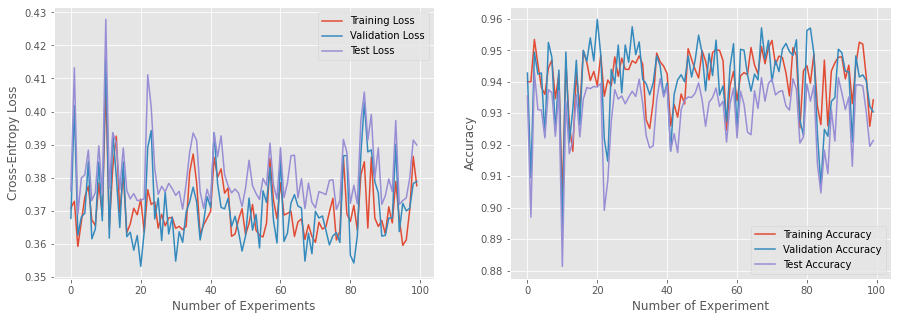

In [11]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(exp_losses_train, label='Training Loss')
plt.plot(exp_losses_val, label='Validation Loss')
plt.plot(test_loss_exp, label='Test Loss')
plt.xlabel('Number of Experiments')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc_exp, label='Training Accuracy')
plt.plot(val_acc_exp, label='Validation Accuracy')
plt.plot(test_accuracy_exp, label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

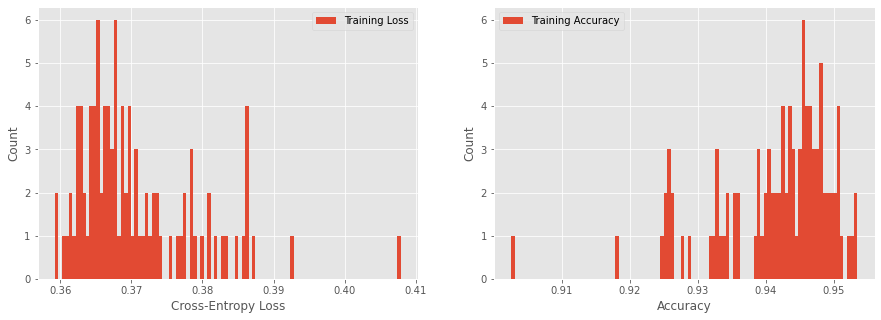

In [12]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.hist(exp_losses_train, label='Training Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(train_acc_exp, label='Training Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

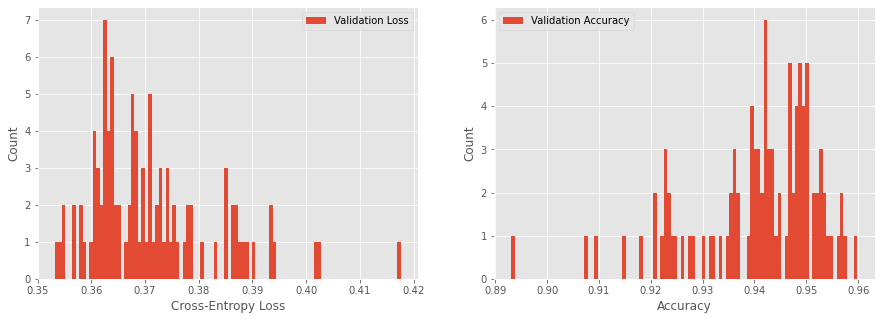

In [13]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(exp_losses_val, label='Validation Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(val_acc_exp, label='Validation Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

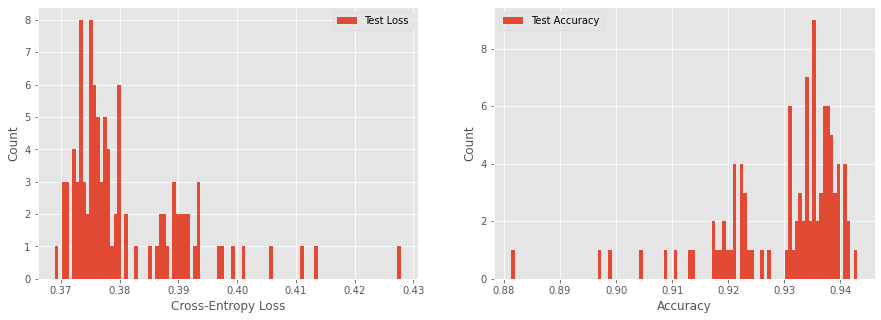

In [14]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(test_loss_exp, label='Test Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(test_accuracy_exp, label='Test Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

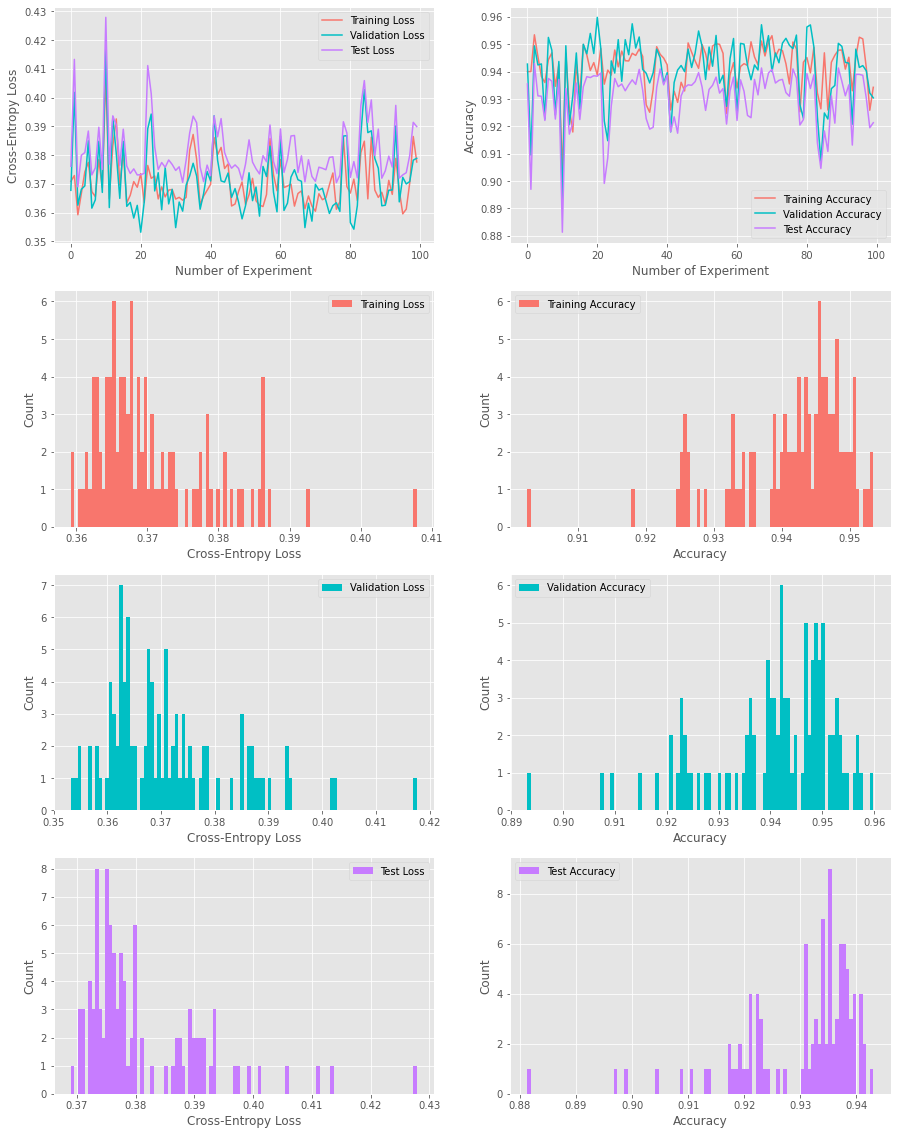

In [15]:
plt.subplots(figsize=(15,20))

plt.subplot(421)
plt.plot(exp_losses_train, label='Training Loss',color='#F8766D')
plt.plot(exp_losses_val, label='Validation Loss',color='#00BFC4')
plt.plot(test_loss_exp, label='Test Loss',color='#C77CFF')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(422)
plt.plot(train_acc_exp, label='Training Accuracy',color='#F8766D')
plt.plot(val_acc_exp, label='Validation Accuracy',color='#00BFC4')
plt.plot(test_accuracy_exp, label='Test Accuracy',color='#C77CFF')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(423)
plt.hist(exp_losses_train, label='Training Loss',color='#F8766D',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(424)
plt.hist(train_acc_exp, label='Training Accuracy',color='#F8766D',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(425)
plt.hist(exp_losses_val, label='Validation Loss',color='#00BFC4',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(426)
plt.hist(val_acc_exp, label='Validation Accuracy',color='#00BFC4',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(427)
plt.hist(test_loss_exp, label='Test Loss',color='#C77CFF',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(428)
plt.hist(test_accuracy_exp, label='Test Accuracy',color='#C77CFF',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()